<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/transfer_learning/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 964, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 964 (delta 0), reused 1 (delta 0), pack-reused 960 (from 1)
Receiving objects: 100% (964/964), 10.05 MiB | 23.02 MiB/s, done.
Resolving deltas: 100% (645/645), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 4) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
5.19% complete (down: 66936.4 kB/s up: 1920.5 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

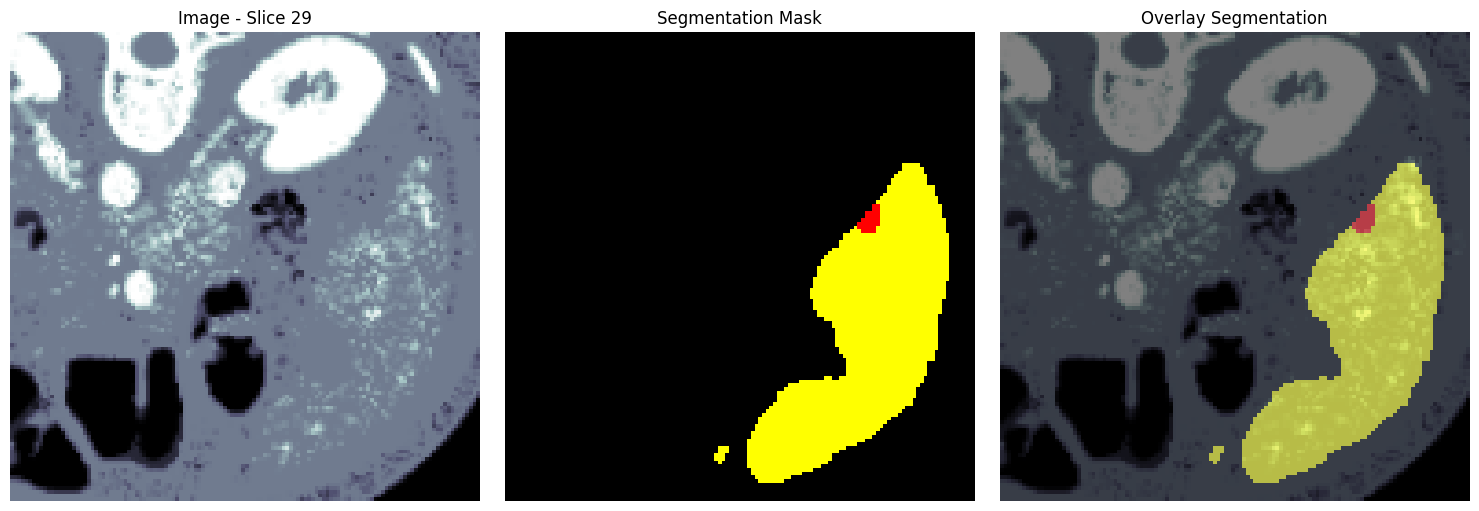

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    label_data = label_sample[0, 0].numpy()  # shape: [128, 128, 128]
    image_data = image_sample[0, 0].numpy()

    # Tìm tất cả slice index có tumor
    tumor_slices = np.any(label_data == 2, axis=(1, 2))


    slice_idx = np.argmax(tumor_slices)

    img_slice = image_data[slice_idx, :, :]
    label_slice = label_data[slice_idx, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break


## Model

In [9]:
model = ModelFactory.get_model("unet3d",in_channels=1, n_classes=3, n_channels=16, pretrained=True).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of network parameters: 49103155


## Training

In [ ]:
encoder_params = []
decoder_params = []

for name, param in model.named_parameters():
    if 'pretrained_model' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

In [ ]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW([
    {"params": encoder_params, "lr": float(config["learning_rate_pretrained"])},
    {"params": decoder_params, "lr": float(config["learning_rate_train"])},
], weight_decay=float(config["weight_decay"]))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    dices_tumor,
    dices_avg,
    loss_epochs,
    trains_epoch,
    ious_liver,
    ious_tumor,
    ious_avg,
    precisions_liver,
    precisions_tumor,
    precisions_avg,
    recalls_liver,
    recalls_tumor,
    recalls_avg,
    time_tmp,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="pretrained"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.8858 time 3.38s
Epoch 1/100 2/105 loss: 0.8378 time 3.64s
Epoch 1/100 3/105 loss: 0.8084 time 2.76s
Epoch 1/100 4/105 loss: 0.7888 time 1.07s
Epoch 1/100 5/105 loss: 0.7775 time 1.44s
Epoch 1/100 6/105 loss: 0.7664 time 4.90s
Epoch 1/100 7/105 loss: 0.7589 time 1.23s
Epoch 1/100 8/105 loss: 0.7535 time 6.68s
Epoch 1/100 9/105 loss: 0.7488 time 2.83s
Epoch 1/100 10/105 loss: 0.7436 time 0.69s
Epoch 1/100 11/105 loss: 0.7399 time 5.11s
Epoch 1/100 12/105 loss: 0.7353 time 5.46s
Epoch 1/100 13/105 loss: 0.7331 time 3.13s
Epoch 1/100 14/105 loss: 0.7296 time 5.00s
Epoch 1/100 15/105 loss: 0.7271 time 5.00s
Epoch 1/100 16/105 loss: 0.7234 time 4.83s
Epoch 1/100 17/105 loss: 0.7207 time 2.78s
Epoch 1/100 18/105 loss: 0.7171 time 5.76s
Epoch 1/100 19/105 loss: 0.7141 time 4.62s
Epoch 1/100 20/105 loss: 0.7122 time 0.75s
Epoch 1/100 21/105 loss: 0.7090 time 0.89s
Epoch 1/100 22/105 loss: 0.7069 time 6.48s
Epoch 1/100 23/105 loss: 0.7046 time 4.23s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.5804] ---[time 413.26s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.5804] ---[time 413.26s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.5804 time 6.22s


Val 1/100 1/26, Dice_Liver: 0.769275, Dice_Tumor: 0.000000, Dice_Avg: 0.384638, time 7.71s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.769275, Dice_Tumor: 0.000000, Dice_Avg: 0.384638, time 7.71s
Val 1/100 2/26, Dice_Liver: 0.792785, Dice_Tumor: 0.000000, Dice_Avg: 0.396392, time 3.24s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.792785, Dice_Tumor: 0.000000, Dice_Avg: 0.396392, time 3.24s
Val 1/100 3/26, Dice_Liver: 0.793763, Dice_Tumor: 0.000000, Dice_Avg: 0.396882, time 1.71s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.793763, Dice_Tumor: 0.000000, Dice_Avg: 0.396882, time 1.71s
Val 1/100 4/26, Dice_Liver: 0.780599, Dice_Tumor: 0.000000, Dice_Avg: 0.390299, time 1.26s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.780599, Dice_Tumor: 0.000000, Dice_Avg: 0.390299, time 1.26s
Val 1/100 5/26, Dice_Liver: 0.787007, Dice_Tumor: 0.000000, Dice_Avg: 0.393504, time 8.20s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.787007, Dice_Tumor: 0.000000, Dice_A

New best (0.000000 --> 0.254596). At epoch 1


Epoch 1/100 ---[loss: 0.5804] ---[val_dice: 0.254596] ---[time 86.20s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.5804] ---[val_dice: 0.254596] ---[time 86.20s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.4812 time 6.19s
Epoch 2/100 2/105 loss: 0.4792 time 6.01s
Epoch 2/100 3/105 loss: 0.4998 time 0.62s
Epoch 2/100 4/105 loss: 0.4900 time 6.35s
Epoch 2/100 5/105 loss: 0.4817 time 2.11s
Epoch 2/100 6/105 loss: 0.4809 time 5.23s
Epoch 2/100 7/105 loss: 0.4775 time 3.98s
Epoch 2/100 8/105 loss: 0.4762 time 0.87s
Epoch 2/100 9/105 loss: 0.4751 time 5.71s
Epoch 2/100 10/105 loss: 0.4757 time 0.78s
Epoch 2/100 11/105 loss: 0.4753 time 4.84s
Epoch 2/100 12/105 loss: 0.4742 time 4.28s
Epoch 2/100 13/105 loss: 0.4743 time 5.16s
Epoch 2/100 14/105 loss: 0.4734 time 4.66s
Epoch 2/100 15/105 loss: 0.4711 time 1.39s
Epoch 2/100 16/105 loss: 0.4695 time 6.35s
Epoch 2/100 17/105 loss: 0.4681 time 4.48s
Epoch 2/100 18/105 loss: 0.4672 time 1.05s
Epoch 2/100 19/105 loss: 0.4678 time 1.09s
Epoch 2/100 20/105 loss: 0.4666 time 5.69s
Epoch 2/100 21/105 loss: 0.4666 time 0.92s
Epoch 2/100 22/105 loss: 0.4671 time 1.35s
Epoch 2/100 23/105 loss: 0.4663 time 5.55s
Epoch 2/100 24/105 l

Final training epochs: 2/100 ---[loss: 0.4455] ---[time 400.14s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.4455] ---[time 400.14s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.4455 time 1.25s


Val 2/100 1/26, Dice_Liver: 0.850298, Dice_Tumor: 0.000000, Dice_Avg: 0.425149, time 6.09s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.850298, Dice_Tumor: 0.000000, Dice_Avg: 0.425149, time 6.09s
Val 2/100 2/26, Dice_Liver: 0.848320, Dice_Tumor: 0.000000, Dice_Avg: 0.424160, time 5.03s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.848320, Dice_Tumor: 0.000000, Dice_Avg: 0.424160, time 5.03s
Val 2/100 3/26, Dice_Liver: 0.808600, Dice_Tumor: 0.000000, Dice_Avg: 0.404300, time 1.66s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.808600, Dice_Tumor: 0.000000, Dice_Avg: 0.404300, time 1.66s
Val 2/100 4/26, Dice_Liver: 0.810434, Dice_Tumor: 0.000000, Dice_Avg: 0.405217, time 1.27s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.810434, Dice_Tumor: 0.000000, Dice_Avg: 0.405217, time 1.27s
Val 2/100 5/26, Dice_Liver: 0.804602, Dice_Tumor: 0.000000, Dice_Avg: 0.402301, time 7.48s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.804602, Dice_Tumor: 0.000000, Dice_A

New best (0.254596 --> 0.323766). At epoch 2



==============================Training epoch 3==============================
INFO:kltn.utils.logger:
==============================Training epoch 3==============================


Epoch 3/100 1/105 loss: 0.4089 time 5.46s
Epoch 3/100 2/105 loss: 0.4089 time 4.39s
Epoch 3/100 3/105 loss: 0.4117 time 7.00s
Epoch 3/100 4/105 loss: 0.4156 time 4.23s
Epoch 3/100 5/105 loss: 0.4129 time 1.07s
Epoch 3/100 6/105 loss: 0.4128 time 5.41s
Epoch 3/100 7/105 loss: 0.4163 time 0.67s
Epoch 3/100 8/105 loss: 0.4144 time 3.99s
Epoch 3/100 9/105 loss: 0.4185 time 4.12s
Epoch 3/100 10/105 loss: 0.4194 time 2.70s
Epoch 3/100 11/105 loss: 0.4196 time 4.24s
Epoch 3/100 12/105 loss: 0.4188 time 5.71s
Epoch 3/100 13/105 loss: 0.4204 time 9.88s
Epoch 3/100 14/105 loss: 0.4208 time 1.09s
Epoch 3/100 15/105 loss: 0.4213 time 2.55s
Epoch 3/100 16/105 loss: 0.4214 time 1.42s
Epoch 3/100 17/105 loss: 0.4226 time 5.97s
Epoch 3/100 18/105 loss: 0.4220 time 5.93s
Epoch 3/100 19/105 loss: 0.4225 time 5.00s
Epoch 3/100 20/105 loss: 0.4216 time 0.98s
Epoch 3/100 21/105 loss: 0.4208 time 2.02s
Epoch 3/100 22/105 loss: 0.4199 time 3.18s
Epoch 3/100 23/105 loss: 0.4227 time 5.62s
Epoch 3/100 24/105 l

Final training epochs: 3/100 ---[loss: 0.4147] ---[time 403.27s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.4147] ---[time 403.27s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.4147 time 2.99s


Val 3/100 1/26, Dice_Liver: 0.775035, Dice_Tumor: 0.000000, Dice_Avg: 0.387518, time 5.93s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.775035, Dice_Tumor: 0.000000, Dice_Avg: 0.387518, time 5.93s
Val 3/100 2/26, Dice_Liver: 0.793210, Dice_Tumor: 0.000000, Dice_Avg: 0.396605, time 5.22s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.793210, Dice_Tumor: 0.000000, Dice_Avg: 0.396605, time 5.22s
Val 3/100 3/26, Dice_Liver: 0.642194, Dice_Tumor: 0.000000, Dice_Avg: 0.321097, time 2.27s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.642194, Dice_Tumor: 0.000000, Dice_Avg: 0.321097, time 2.27s
Val 3/100 4/26, Dice_Liver: 0.664105, Dice_Tumor: 0.000000, Dice_Avg: 0.332052, time 1.43s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.664105, Dice_Tumor: 0.000000, Dice_Avg: 0.332052, time 1.43s
Val 3/100 5/26, Dice_Liver: 0.675717, Dice_Tumor: 0.000000, Dice_Avg: 0.337858, time 7.42s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.675717, Dice_Tumor: 0.000000, Dice_A

Epoch 4/100 1/105 loss: 0.4264 time 3.90s
Epoch 4/100 2/105 loss: 0.4145 time 4.22s
Epoch 4/100 3/105 loss: 0.4187 time 1.13s
Epoch 4/100 4/105 loss: 0.4127 time 2.48s
Epoch 4/100 5/105 loss: 0.4062 time 1.99s
Epoch 4/100 6/105 loss: 0.4092 time 0.66s
Epoch 4/100 7/105 loss: 0.4094 time 5.63s
Epoch 4/100 8/105 loss: 0.4095 time 5.47s
Epoch 4/100 9/105 loss: 0.4084 time 6.17s
Epoch 4/100 10/105 loss: 0.4084 time 4.94s
Epoch 4/100 11/105 loss: 0.4067 time 5.90s
Epoch 4/100 12/105 loss: 0.4044 time 1.72s
Epoch 4/100 13/105 loss: 0.4042 time 0.76s
Epoch 4/100 14/105 loss: 0.4033 time 4.68s
Epoch 4/100 15/105 loss: 0.4043 time 2.67s
Epoch 4/100 16/105 loss: 0.4028 time 6.85s
Epoch 4/100 17/105 loss: 0.4035 time 5.19s
Epoch 4/100 18/105 loss: 0.4044 time 4.82s
Epoch 4/100 19/105 loss: 0.4046 time 7.19s
Epoch 4/100 20/105 loss: 0.4052 time 2.59s
Epoch 4/100 21/105 loss: 0.4049 time 6.67s
Epoch 4/100 22/105 loss: 0.4043 time 1.07s
Epoch 4/100 23/105 loss: 0.4046 time 5.73s
Epoch 4/100 24/105 l

Final training epochs: 4/100 ---[loss: 0.4050] ---[time 421.44s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.4050] ---[time 421.44s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.4050 time 5.50s


Val 4/100 1/26, Dice_Liver: 0.814067, Dice_Tumor: 0.000000, Dice_Avg: 0.407033, time 5.71s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.814067, Dice_Tumor: 0.000000, Dice_Avg: 0.407033, time 5.71s
Val 4/100 2/26, Dice_Liver: 0.830620, Dice_Tumor: 0.000000, Dice_Avg: 0.415310, time 6.34s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.830620, Dice_Tumor: 0.000000, Dice_Avg: 0.415310, time 6.34s
Val 4/100 3/26, Dice_Liver: 0.830813, Dice_Tumor: 0.000000, Dice_Avg: 0.415407, time 1.83s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.830813, Dice_Tumor: 0.000000, Dice_Avg: 0.415407, time 1.83s
Val 4/100 4/26, Dice_Liver: 0.844906, Dice_Tumor: 0.000000, Dice_Avg: 0.422453, time 1.44s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.844906, Dice_Tumor: 0.000000, Dice_Avg: 0.422453, time 1.44s
Val 4/100 5/26, Dice_Liver: 0.844484, Dice_Tumor: 0.000000, Dice_Avg: 0.422242, time 7.44s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.844484, Dice_Tumor: 0.000000, Dice_A

New best (0.323766 --> 0.347796). At epoch 4



==============================Training epoch 5==============================
INFO:kltn.utils.logger:
==============================Training epoch 5==============================


Epoch 5/100 1/105 loss: 0.4174 time 2.06s
Epoch 5/100 2/105 loss: 0.4032 time 5.71s
Epoch 5/100 3/105 loss: 0.4081 time 1.94s
Epoch 5/100 4/105 loss: 0.4017 time 7.38s
Epoch 5/100 5/105 loss: 0.3978 time 7.02s
Epoch 5/100 6/105 loss: 0.3975 time 1.95s
Epoch 5/100 7/105 loss: 0.3985 time 5.33s
Epoch 5/100 8/105 loss: 0.3992 time 7.35s
Epoch 5/100 9/105 loss: 0.3996 time 4.65s
Epoch 5/100 10/105 loss: 0.4002 time 2.87s
Epoch 5/100 11/105 loss: 0.3991 time 6.39s
Epoch 5/100 12/105 loss: 0.3974 time 4.85s
Epoch 5/100 13/105 loss: 0.3954 time 1.54s
Epoch 5/100 14/105 loss: 0.3958 time 6.83s
Epoch 5/100 15/105 loss: 0.3983 time 3.04s
Epoch 5/100 16/105 loss: 0.3997 time 2.97s
Epoch 5/100 17/105 loss: 0.4008 time 2.73s
Epoch 5/100 18/105 loss: 0.3986 time 6.77s
Epoch 5/100 19/105 loss: 0.3982 time 1.69s
Epoch 5/100 20/105 loss: 0.3983 time 6.55s
Epoch 5/100 21/105 loss: 0.3984 time 1.34s
Epoch 5/100 22/105 loss: 0.3983 time 0.95s
Epoch 5/100 23/105 loss: 0.3983 time 5.13s
Epoch 5/100 24/105 l

Final training epochs: 5/100 ---[loss: 0.3967] ---[time 420.65s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3967] ---[time 420.65s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3967 time 0.81s


Val 5/100 1/26, Dice_Liver: 0.799668, Dice_Tumor: 0.000000, Dice_Avg: 0.399834, time 6.00s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.799668, Dice_Tumor: 0.000000, Dice_Avg: 0.399834, time 6.00s
Val 5/100 2/26, Dice_Liver: 0.817343, Dice_Tumor: 0.000000, Dice_Avg: 0.408672, time 5.48s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.817343, Dice_Tumor: 0.000000, Dice_Avg: 0.408672, time 5.48s
Val 5/100 3/26, Dice_Liver: 0.675366, Dice_Tumor: 0.000000, Dice_Avg: 0.337683, time 1.90s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.675366, Dice_Tumor: 0.000000, Dice_Avg: 0.337683, time 1.90s
Val 5/100 4/26, Dice_Liver: 0.712083, Dice_Tumor: 0.000000, Dice_Avg: 0.356042, time 1.39s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.712083, Dice_Tumor: 0.000000, Dice_Avg: 0.356042, time 1.39s
Val 5/100 5/26, Dice_Liver: 0.710957, Dice_Tumor: 0.000000, Dice_Avg: 0.355478, time 8.03s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.710957, Dice_Tumor: 0.000000, Dice_A

New best (0.347796 --> 0.348134). At epoch 5



==============================Training epoch 6==============================
INFO:kltn.utils.logger:
==============================Training epoch 6==============================


Epoch 6/100 1/105 loss: 0.3544 time 2.88s
Epoch 6/100 2/105 loss: 0.3724 time 5.51s
Epoch 6/100 3/105 loss: 0.3975 time 0.81s
Epoch 6/100 4/105 loss: 0.3919 time 4.55s
Epoch 6/100 5/105 loss: 0.3923 time 1.27s
Epoch 6/100 6/105 loss: 0.3915 time 1.11s
Epoch 6/100 7/105 loss: 0.3902 time 1.13s
Epoch 6/100 8/105 loss: 0.3946 time 3.84s
Epoch 6/100 9/105 loss: 0.3921 time 3.46s
Epoch 6/100 10/105 loss: 0.3951 time 1.25s
Epoch 6/100 11/105 loss: 0.3942 time 6.29s
Epoch 6/100 12/105 loss: 0.3961 time 5.89s
Epoch 6/100 13/105 loss: 0.3971 time 0.71s
Epoch 6/100 14/105 loss: 0.3963 time 4.24s
Epoch 6/100 15/105 loss: 0.3970 time 6.27s
Epoch 6/100 16/105 loss: 0.3985 time 2.59s
Epoch 6/100 17/105 loss: 0.3983 time 2.19s
Epoch 6/100 18/105 loss: 0.3991 time 2.05s
Epoch 6/100 19/105 loss: 0.3984 time 5.86s
Epoch 6/100 20/105 loss: 0.3987 time 5.35s
Epoch 6/100 21/105 loss: 0.3982 time 7.50s
Epoch 6/100 22/105 loss: 0.3984 time 6.84s
Epoch 6/100 23/105 loss: 0.3980 time 5.64s
Epoch 6/100 24/105 l

Final training epochs: 6/100 ---[loss: 0.3940] ---[time 430.63s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3940] ---[time 430.63s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3940 time 4.29s


Val 6/100 1/26, Dice_Liver: 0.777353, Dice_Tumor: 0.000000, Dice_Avg: 0.388676, time 6.28s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.777353, Dice_Tumor: 0.000000, Dice_Avg: 0.388676, time 6.28s
Val 6/100 2/26, Dice_Liver: 0.802953, Dice_Tumor: 0.000000, Dice_Avg: 0.401477, time 5.17s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.802953, Dice_Tumor: 0.000000, Dice_Avg: 0.401477, time 5.17s
Val 6/100 3/26, Dice_Liver: 0.788523, Dice_Tumor: 0.000000, Dice_Avg: 0.394262, time 1.84s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.788523, Dice_Tumor: 0.000000, Dice_Avg: 0.394262, time 1.84s
Val 6/100 4/26, Dice_Liver: 0.784482, Dice_Tumor: 0.000000, Dice_Avg: 0.392241, time 1.35s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.784482, Dice_Tumor: 0.000000, Dice_Avg: 0.392241, time 1.35s
Val 6/100 5/26, Dice_Liver: 0.779416, Dice_Tumor: 0.000000, Dice_Avg: 0.389708, time 8.14s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.779416, Dice_Tumor: 0.000000, Dice_A

Epoch 7/100 1/105 loss: 0.3755 time 7.17s
Epoch 7/100 2/105 loss: 0.3701 time 1.21s
Epoch 7/100 3/105 loss: 0.3921 time 5.41s
Epoch 7/100 4/105 loss: 0.3804 time 1.53s
Epoch 7/100 5/105 loss: 0.3787 time 3.34s
Epoch 7/100 6/105 loss: 0.3849 time 5.62s
Epoch 7/100 7/105 loss: 0.3842 time 0.90s
Epoch 7/100 8/105 loss: 0.3861 time 2.89s
Epoch 7/100 9/105 loss: 0.3855 time 6.10s
Epoch 7/100 10/105 loss: 0.3839 time 4.59s
Epoch 7/100 11/105 loss: 0.3867 time 10.85s
Epoch 7/100 12/105 loss: 0.3860 time 2.84s
Epoch 7/100 13/105 loss: 0.3863 time 3.67s
Epoch 7/100 14/105 loss: 0.3859 time 6.40s
Epoch 7/100 15/105 loss: 0.3869 time 1.58s
Epoch 7/100 16/105 loss: 0.3874 time 0.73s
Epoch 7/100 17/105 loss: 0.3869 time 0.79s
Epoch 7/100 18/105 loss: 0.3875 time 10.14s
Epoch 7/100 19/105 loss: 0.3877 time 4.75s
Epoch 7/100 20/105 loss: 0.3873 time 0.81s
Epoch 7/100 21/105 loss: 0.3873 time 6.36s
Epoch 7/100 22/105 loss: 0.3877 time 5.87s
Epoch 7/100 23/105 loss: 0.3894 time 1.87s
Epoch 7/100 24/105

Final training epochs: 7/100 ---[loss: 0.3915] ---[time 421.98s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.3915] ---[time 421.98s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.3915 time 1.70s


Val 7/100 1/26, Dice_Liver: 0.793193, Dice_Tumor: 0.000000, Dice_Avg: 0.396597, time 5.60s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.793193, Dice_Tumor: 0.000000, Dice_Avg: 0.396597, time 5.60s
Val 7/100 2/26, Dice_Liver: 0.809640, Dice_Tumor: 0.000000, Dice_Avg: 0.404820, time 5.34s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.809640, Dice_Tumor: 0.000000, Dice_Avg: 0.404820, time 5.34s
Val 7/100 3/26, Dice_Liver: 0.800786, Dice_Tumor: 0.000000, Dice_Avg: 0.400393, time 2.32s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.800786, Dice_Tumor: 0.000000, Dice_Avg: 0.400393, time 2.32s
Val 7/100 4/26, Dice_Liver: 0.796129, Dice_Tumor: 0.000000, Dice_Avg: 0.398064, time 1.40s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.796129, Dice_Tumor: 0.000000, Dice_Avg: 0.398064, time 1.40s
Val 7/100 5/26, Dice_Liver: 0.797157, Dice_Tumor: 0.000000, Dice_Avg: 0.398578, time 7.42s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.797157, Dice_Tumor: 0.000000, Dice_A

Epoch 8/100 1/105 loss: 0.3805 time 5.57s
Epoch 8/100 2/105 loss: 0.3877 time 2.63s
Epoch 8/100 3/105 loss: 0.3850 time 7.95s
Epoch 8/100 4/105 loss: 0.3872 time 2.27s
Epoch 8/100 5/105 loss: 0.3874 time 0.85s
Epoch 8/100 6/105 loss: 0.3878 time 0.77s
Epoch 8/100 7/105 loss: 0.3889 time 5.13s
Epoch 8/100 8/105 loss: 0.3863 time 5.90s
Epoch 8/100 9/105 loss: 0.3876 time 7.05s
Epoch 8/100 10/105 loss: 0.3907 time 1.75s
Epoch 8/100 11/105 loss: 0.3886 time 1.61s
Epoch 8/100 12/105 loss: 0.3878 time 5.86s
Epoch 8/100 13/105 loss: 0.3864 time 4.58s
Epoch 8/100 14/105 loss: 0.3880 time 5.92s
Epoch 8/100 15/105 loss: 0.3878 time 5.83s
Epoch 8/100 16/105 loss: 0.3891 time 3.26s
Epoch 8/100 17/105 loss: 0.3888 time 1.41s
Epoch 8/100 18/105 loss: 0.3869 time 5.95s
Epoch 8/100 19/105 loss: 0.3858 time 1.98s
Epoch 8/100 20/105 loss: 0.3858 time 5.42s
Epoch 8/100 21/105 loss: 0.3874 time 2.96s
Epoch 8/100 22/105 loss: 0.3868 time 1.55s
Epoch 8/100 23/105 loss: 0.3873 time 6.26s
Epoch 8/100 24/105 l

Final training epochs: 8/100 ---[loss: 0.3886] ---[time 425.73s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.3886] ---[time 425.73s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.3886 time 5.46s


Val 8/100 1/26, Dice_Liver: 0.816054, Dice_Tumor: 0.000000, Dice_Avg: 0.408027, time 6.59s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.816054, Dice_Tumor: 0.000000, Dice_Avg: 0.408027, time 6.59s
Val 8/100 2/26, Dice_Liver: 0.827608, Dice_Tumor: 0.000000, Dice_Avg: 0.413804, time 5.45s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.827608, Dice_Tumor: 0.000000, Dice_Avg: 0.413804, time 5.45s
Val 8/100 3/26, Dice_Liver: 0.756663, Dice_Tumor: 0.000000, Dice_Avg: 0.378331, time 2.01s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.756663, Dice_Tumor: 0.000000, Dice_Avg: 0.378331, time 2.01s
Val 8/100 4/26, Dice_Liver: 0.767011, Dice_Tumor: 0.000000, Dice_Avg: 0.383505, time 1.39s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.767011, Dice_Tumor: 0.000000, Dice_Avg: 0.383505, time 1.39s
Val 8/100 5/26, Dice_Liver: 0.757742, Dice_Tumor: 0.000000, Dice_Avg: 0.378871, time 7.88s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.757742, Dice_Tumor: 0.000000, Dice_A

Epoch 9/100 1/105 loss: 0.3977 time 10.16s
Epoch 9/100 2/105 loss: 0.3788 time 1.01s
Epoch 9/100 3/105 loss: 0.3832 time 2.15s
Epoch 9/100 4/105 loss: 0.3812 time 6.82s
Epoch 9/100 5/105 loss: 0.3790 time 5.19s
Epoch 9/100 6/105 loss: 0.3822 time 2.79s
Epoch 9/100 7/105 loss: 0.3824 time 0.95s
Epoch 9/100 8/105 loss: 0.3848 time 0.92s
Epoch 9/100 9/105 loss: 0.3839 time 2.11s
Epoch 9/100 10/105 loss: 0.3850 time 3.37s
Epoch 9/100 11/105 loss: 0.3845 time 5.77s
Epoch 9/100 12/105 loss: 0.3843 time 6.67s
Epoch 9/100 13/105 loss: 0.3848 time 4.07s
Epoch 9/100 14/105 loss: 0.3850 time 7.74s
Epoch 9/100 15/105 loss: 0.3828 time 4.96s
Epoch 9/100 16/105 loss: 0.3836 time 0.76s
Epoch 9/100 17/105 loss: 0.3826 time 0.98s
Epoch 9/100 18/105 loss: 0.3828 time 1.57s
Epoch 9/100 19/105 loss: 0.3839 time 5.32s
Epoch 9/100 20/105 loss: 0.3824 time 5.65s
Epoch 9/100 21/105 loss: 0.3831 time 1.27s
Epoch 9/100 22/105 loss: 0.3828 time 0.72s
Epoch 9/100 23/105 loss: 0.3835 time 5.08s
Epoch 9/100 24/105 

Final training epochs: 9/100 ---[loss: 0.3864] ---[time 421.65s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.3864] ---[time 421.65s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.3864 time 2.03s


Val 9/100 1/26, Dice_Liver: 0.824647, Dice_Tumor: 0.000000, Dice_Avg: 0.412323, time 5.54s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.824647, Dice_Tumor: 0.000000, Dice_Avg: 0.412323, time 5.54s
Val 9/100 2/26, Dice_Liver: 0.839381, Dice_Tumor: 0.000000, Dice_Avg: 0.419691, time 6.18s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.839381, Dice_Tumor: 0.000000, Dice_Avg: 0.419691, time 6.18s
Val 9/100 3/26, Dice_Liver: 0.829125, Dice_Tumor: 0.000000, Dice_Avg: 0.414562, time 1.85s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.829125, Dice_Tumor: 0.000000, Dice_Avg: 0.414562, time 1.85s
Val 9/100 4/26, Dice_Liver: 0.836087, Dice_Tumor: 0.000000, Dice_Avg: 0.418043, time 1.40s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.836087, Dice_Tumor: 0.000000, Dice_Avg: 0.418043, time 1.40s
Val 9/100 5/26, Dice_Liver: 0.833268, Dice_Tumor: 0.000000, Dice_Avg: 0.416634, time 8.53s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.833268, Dice_Tumor: 0.000000, Dice_A

New best (0.348134 --> 0.375748). At epoch 9



==============================Training epoch 10==============================
INFO:kltn.utils.logger:
==============================Training epoch 10==============================


Epoch 10/100 1/105 loss: 0.3815 time 6.06s
Epoch 10/100 2/105 loss: 0.3806 time 8.04s
Epoch 10/100 3/105 loss: 0.3946 time 5.97s
Epoch 10/100 4/105 loss: 0.3922 time 6.87s
Epoch 10/100 5/105 loss: 0.3897 time 5.98s
Epoch 10/100 6/105 loss: 0.3927 time 0.95s
Epoch 10/100 7/105 loss: 0.3920 time 5.94s
Epoch 10/100 8/105 loss: 0.3932 time 1.98s
Epoch 10/100 9/105 loss: 0.3933 time 1.50s
Epoch 10/100 10/105 loss: 0.3911 time 5.89s
Epoch 10/100 11/105 loss: 0.3907 time 6.69s
Epoch 10/100 12/105 loss: 0.3919 time 9.91s
Epoch 10/100 13/105 loss: 0.3918 time 2.49s
Epoch 10/100 14/105 loss: 0.3922 time 4.71s
Epoch 10/100 15/105 loss: 0.3911 time 0.79s
Epoch 10/100 16/105 loss: 0.3926 time 0.71s
Epoch 10/100 17/105 loss: 0.3926 time 3.98s
Epoch 10/100 18/105 loss: 0.3922 time 6.37s
Epoch 10/100 19/105 loss: 0.3926 time 2.93s
Epoch 10/100 20/105 loss: 0.3921 time 4.91s
Epoch 10/100 21/105 loss: 0.3925 time 6.10s
Epoch 10/100 22/105 loss: 0.3924 time 0.69s
Epoch 10/100 23/105 loss: 0.3917 time 3.2

Final training epochs: 10/100 ---[loss: 0.3852] ---[time 432.05s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.3852] ---[time 432.05s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.3852 time 5.35s


Val 10/100 1/26, Dice_Liver: 0.846176, Dice_Tumor: 0.000000, Dice_Avg: 0.423088, time 5.67s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.846176, Dice_Tumor: 0.000000, Dice_Avg: 0.423088, time 5.67s
Val 10/100 2/26, Dice_Liver: 0.853440, Dice_Tumor: 0.000000, Dice_Avg: 0.426720, time 5.58s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.853440, Dice_Tumor: 0.000000, Dice_Avg: 0.426720, time 5.58s
Val 10/100 3/26, Dice_Liver: 0.829460, Dice_Tumor: 0.000000, Dice_Avg: 0.414730, time 1.78s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.829460, Dice_Tumor: 0.000000, Dice_Avg: 0.414730, time 1.78s
Val 10/100 4/26, Dice_Liver: 0.832953, Dice_Tumor: 0.000000, Dice_Avg: 0.416477, time 1.41s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.832953, Dice_Tumor: 0.000000, Dice_Avg: 0.416477, time 1.41s
Val 10/100 5/26, Dice_Liver: 0.831760, Dice_Tumor: 0.000000, Dice_Avg: 0.415880, time 7.90s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.831760, Dice_Tumor: 0.0000

Epoch 11/100 1/105 loss: 0.3696 time 3.93s
Epoch 11/100 2/105 loss: 0.3797 time 6.76s
Epoch 11/100 3/105 loss: 0.3872 time 1.11s
Epoch 11/100 4/105 loss: 0.3824 time 1.02s
Epoch 11/100 5/105 loss: 0.3788 time 1.47s
Epoch 11/100 6/105 loss: 0.3724 time 5.15s
Epoch 11/100 7/105 loss: 0.3790 time 1.54s
Epoch 11/100 8/105 loss: 0.3806 time 5.35s
Epoch 11/100 9/105 loss: 0.3861 time 8.29s
Epoch 11/100 10/105 loss: 0.3850 time 4.08s
Epoch 11/100 11/105 loss: 0.3813 time 5.55s
Epoch 11/100 12/105 loss: 0.3817 time 5.84s
Epoch 11/100 13/105 loss: 0.3830 time 7.21s
Epoch 11/100 14/105 loss: 0.3847 time 3.51s
Epoch 11/100 15/105 loss: 0.3853 time 5.88s
Epoch 11/100 16/105 loss: 0.3856 time 2.32s
Epoch 11/100 17/105 loss: 0.3826 time 1.39s
Epoch 11/100 18/105 loss: 0.3841 time 5.22s
Epoch 11/100 19/105 loss: 0.3840 time 4.52s
Epoch 11/100 20/105 loss: 0.3833 time 5.89s
Epoch 11/100 21/105 loss: 0.3830 time 4.91s
Epoch 11/100 22/105 loss: 0.3829 time 1.39s
Epoch 11/100 23/105 loss: 0.3832 time 5.1

Final training epochs: 11/100 ---[loss: 0.3864] ---[time 423.97s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.3864] ---[time 423.97s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.3864 time 10.07s


Val 11/100 1/26, Dice_Liver: 0.813681, Dice_Tumor: 0.113322, Dice_Avg: 0.463501, time 4.98s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.813681, Dice_Tumor: 0.113322, Dice_Avg: 0.463501, time 4.98s
Val 11/100 2/26, Dice_Liver: 0.824437, Dice_Tumor: 0.074894, Dice_Avg: 0.449665, time 4.58s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.824437, Dice_Tumor: 0.074894, Dice_Avg: 0.449665, time 4.58s
Val 11/100 3/26, Dice_Liver: 0.716827, Dice_Tumor: 0.059079, Dice_Avg: 0.387953, time 1.99s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.716827, Dice_Tumor: 0.059079, Dice_Avg: 0.387953, time 1.99s
Val 11/100 4/26, Dice_Liver: 0.733779, Dice_Tumor: 0.044309, Dice_Avg: 0.389044, time 1.66s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.733779, Dice_Tumor: 0.044309, Dice_Avg: 0.389044, time 1.66s
Val 11/100 5/26, Dice_Liver: 0.727999, Dice_Tumor: 0.035447, Dice_Avg: 0.381723, time 7.61s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.727999, Dice_Tumor: 0.0354

Epoch 12/100 1/105 loss: 0.3982 time 1.91s
Epoch 12/100 2/105 loss: 0.3864 time 6.77s
Epoch 12/100 3/105 loss: 0.4018 time 6.20s
Epoch 12/100 4/105 loss: 0.4031 time 5.20s
Epoch 12/100 5/105 loss: 0.3907 time 1.01s
Epoch 12/100 6/105 loss: 0.3887 time 0.81s
Epoch 12/100 7/105 loss: 0.3892 time 11.16s
Epoch 12/100 8/105 loss: 0.3884 time 3.89s
Epoch 12/100 9/105 loss: 0.3897 time 2.47s
Epoch 12/100 10/105 loss: 0.3891 time 5.22s
Epoch 12/100 11/105 loss: 0.3857 time 5.47s
Epoch 12/100 12/105 loss: 0.3827 time 6.47s
Epoch 12/100 13/105 loss: 0.3833 time 7.28s
Epoch 12/100 14/105 loss: 0.3891 time 0.63s
Epoch 12/100 15/105 loss: 0.3857 time 0.98s
Epoch 12/100 16/105 loss: 0.3822 time 5.73s
Epoch 12/100 17/105 loss: 0.3810 time 5.62s
Epoch 12/100 18/105 loss: 0.3775 time 6.92s
Epoch 12/100 19/105 loss: 0.3739 time 3.41s
Epoch 12/100 20/105 loss: 0.3746 time 0.66s
Epoch 12/100 21/105 loss: 0.3747 time 1.07s
Epoch 12/100 22/105 loss: 0.3758 time 2.91s
Epoch 12/100 23/105 loss: 0.3768 time 6.

Final training epochs: 12/100 ---[loss: 0.3831] ---[time 421.21s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.3831] ---[time 421.21s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.3831 time 4.69s


Val 12/100 1/26, Dice_Liver: 0.838540, Dice_Tumor: 0.000000, Dice_Avg: 0.419270, time 5.71s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.838540, Dice_Tumor: 0.000000, Dice_Avg: 0.419270, time 5.71s
Val 12/100 2/26, Dice_Liver: 0.843216, Dice_Tumor: 0.000000, Dice_Avg: 0.421608, time 5.62s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.843216, Dice_Tumor: 0.000000, Dice_Avg: 0.421608, time 5.62s
Val 12/100 3/26, Dice_Liver: 0.831415, Dice_Tumor: 0.000000, Dice_Avg: 0.415708, time 1.93s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.831415, Dice_Tumor: 0.000000, Dice_Avg: 0.415708, time 1.93s
Val 12/100 4/26, Dice_Liver: 0.840689, Dice_Tumor: 0.000000, Dice_Avg: 0.420344, time 1.39s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.840689, Dice_Tumor: 0.000000, Dice_Avg: 0.420344, time 1.39s
Val 12/100 5/26, Dice_Liver: 0.838128, Dice_Tumor: 0.000000, Dice_Avg: 0.419064, time 8.01s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.838128, Dice_Tumor: 0.0000

New best (0.375748 --> 0.395004). At epoch 12



==============================Training epoch 13==============================
INFO:kltn.utils.logger:
==============================Training epoch 13==============================


Epoch 13/100 1/105 loss: 0.3636 time 2.54s
Epoch 13/100 2/105 loss: 0.3623 time 6.19s
Epoch 13/100 3/105 loss: 0.3799 time 7.17s
Epoch 13/100 4/105 loss: 0.3706 time 6.37s
Epoch 13/100 5/105 loss: 0.3690 time 3.77s
Epoch 13/100 6/105 loss: 0.3588 time 5.40s
Epoch 13/100 7/105 loss: 0.3637 time 6.94s
Epoch 13/100 8/105 loss: 0.3654 time 2.25s
Epoch 13/100 9/105 loss: 0.3650 time 5.07s
Epoch 13/100 10/105 loss: 0.3700 time 1.26s
Epoch 13/100 11/105 loss: 0.3711 time 3.34s
Epoch 13/100 12/105 loss: 0.3716 time 1.09s
Epoch 13/100 13/105 loss: 0.3716 time 5.68s
Epoch 13/100 14/105 loss: 0.3650 time 1.83s
Epoch 13/100 15/105 loss: 0.3658 time 6.66s
Epoch 13/100 16/105 loss: 0.3660 time 10.18s
Epoch 13/100 17/105 loss: 0.3666 time 4.83s
Epoch 13/100 18/105 loss: 0.3674 time 6.67s
Epoch 13/100 19/105 loss: 0.3690 time 0.70s
Epoch 13/100 20/105 loss: 0.3699 time 1.29s
Epoch 13/100 21/105 loss: 0.3717 time 4.40s
Epoch 13/100 22/105 loss: 0.3726 time 5.21s
Epoch 13/100 23/105 loss: 0.3758 time 0.

Final training epochs: 13/100 ---[loss: 0.3796] ---[time 428.67s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.3796] ---[time 428.67s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.3796 time 3.54s


Val 13/100 1/26, Dice_Liver: 0.819963, Dice_Tumor: 0.400794, Dice_Avg: 0.610378, time 5.59s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.819963, Dice_Tumor: 0.400794, Dice_Avg: 0.610378, time 5.59s
Val 13/100 2/26, Dice_Liver: 0.830206, Dice_Tumor: 0.478086, Dice_Avg: 0.654146, time 5.40s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.830206, Dice_Tumor: 0.478086, Dice_Avg: 0.654146, time 5.40s
Val 13/100 3/26, Dice_Liver: 0.836367, Dice_Tumor: 0.421956, Dice_Avg: 0.629162, time 2.27s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.836367, Dice_Tumor: 0.421956, Dice_Avg: 0.629162, time 2.27s
Val 13/100 4/26, Dice_Liver: 0.839060, Dice_Tumor: 0.316753, Dice_Avg: 0.577906, time 1.38s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.839060, Dice_Tumor: 0.316753, Dice_Avg: 0.577906, time 1.38s
Val 13/100 5/26, Dice_Liver: 0.832483, Dice_Tumor: 0.269588, Dice_Avg: 0.551035, time 7.47s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.832483, Dice_Tumor: 0.2695

Epoch 14/100 1/105 loss: 0.3739 time 5.15s
Epoch 14/100 2/105 loss: 0.3895 time 1.15s
Epoch 14/100 3/105 loss: 0.4006 time 0.75s
Epoch 14/100 4/105 loss: 0.3976 time 0.87s
Epoch 14/100 5/105 loss: 0.3970 time 6.33s
Epoch 14/100 6/105 loss: 0.3930 time 5.56s
Epoch 14/100 7/105 loss: 0.3989 time 2.82s
Epoch 14/100 8/105 loss: 0.3965 time 6.66s
Epoch 14/100 9/105 loss: 0.3964 time 4.44s
Epoch 14/100 10/105 loss: 0.3899 time 4.75s
Epoch 14/100 11/105 loss: 0.3887 time 1.11s
Epoch 14/100 12/105 loss: 0.3920 time 4.43s
Epoch 14/100 13/105 loss: 0.3918 time 4.12s
Epoch 14/100 14/105 loss: 0.3912 time 1.26s
Epoch 14/100 15/105 loss: 0.3894 time 5.64s
Epoch 14/100 16/105 loss: 0.3901 time 4.22s
Epoch 14/100 17/105 loss: 0.3899 time 5.09s
Epoch 14/100 18/105 loss: 0.3895 time 7.79s
Epoch 14/100 19/105 loss: 0.3884 time 4.56s
Epoch 14/100 20/105 loss: 0.3886 time 0.89s
Epoch 14/100 21/105 loss: 0.3863 time 1.20s
Epoch 14/100 22/105 loss: 0.3866 time 5.29s
Epoch 14/100 23/105 loss: 0.3860 time 1.1

Final training epochs: 14/100 ---[loss: 0.3751] ---[time 422.33s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.3751] ---[time 422.33s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.3751 time 5.74s


Val 14/100 1/26, Dice_Liver: 0.761424, Dice_Tumor: 0.560511, Dice_Avg: 0.660967, time 6.20s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.761424, Dice_Tumor: 0.560511, Dice_Avg: 0.660967, time 6.20s
Val 14/100 2/26, Dice_Liver: 0.784519, Dice_Tumor: 0.483767, Dice_Avg: 0.634143, time 5.16s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.784519, Dice_Tumor: 0.483767, Dice_Avg: 0.634143, time 5.16s
Val 14/100 3/26, Dice_Liver: 0.638824, Dice_Tumor: 0.322511, Dice_Avg: 0.480668, time 1.82s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.638824, Dice_Tumor: 0.322511, Dice_Avg: 0.480668, time 1.82s
Val 14/100 4/26, Dice_Liver: 0.674678, Dice_Tumor: 0.241883, Dice_Avg: 0.458281, time 1.39s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.674678, Dice_Tumor: 0.241883, Dice_Avg: 0.458281, time 1.39s
Val 14/100 5/26, Dice_Liver: 0.649142, Dice_Tumor: 0.194182, Dice_Avg: 0.421662, time 7.50s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.649142, Dice_Tumor: 0.1941

Epoch 15/100 1/105 loss: 0.3896 time 1.47s
Epoch 15/100 2/105 loss: 0.3882 time 1.64s
Epoch 15/100 3/105 loss: 0.3874 time 6.37s
Epoch 15/100 4/105 loss: 0.3682 time 2.00s
Epoch 15/100 5/105 loss: 0.3674 time 4.99s
Epoch 15/100 6/105 loss: 0.3713 time 5.30s
Epoch 15/100 7/105 loss: 0.3640 time 4.40s
Epoch 15/100 8/105 loss: 0.3579 time 1.41s
Epoch 15/100 9/105 loss: 0.3623 time 1.18s
Epoch 15/100 10/105 loss: 0.3663 time 8.28s
Epoch 15/100 11/105 loss: 0.3659 time 6.98s
Epoch 15/100 12/105 loss: 0.3673 time 1.41s
Epoch 15/100 13/105 loss: 0.3694 time 3.23s
Epoch 15/100 14/105 loss: 0.3695 time 6.75s
Epoch 15/100 15/105 loss: 0.3708 time 5.27s
Epoch 15/100 16/105 loss: 0.3695 time 5.10s
Epoch 15/100 17/105 loss: 0.3725 time 5.75s
Epoch 15/100 18/105 loss: 0.3739 time 5.11s
Epoch 15/100 19/105 loss: 0.3747 time 2.21s
Epoch 15/100 20/105 loss: 0.3751 time 5.51s
Epoch 15/100 21/105 loss: 0.3763 time 2.70s
Epoch 15/100 22/105 loss: 0.3773 time 7.07s
Epoch 15/100 23/105 loss: 0.3781 time 2.7

Final training epochs: 15/100 ---[loss: 0.3726] ---[time 425.30s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.3726] ---[time 425.30s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.3726 time 6.01s


Val 15/100 1/26, Dice_Liver: 0.782937, Dice_Tumor: 0.000000, Dice_Avg: 0.391469, time 5.58s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.782937, Dice_Tumor: 0.000000, Dice_Avg: 0.391469, time 5.58s
Val 15/100 2/26, Dice_Liver: 0.793756, Dice_Tumor: 0.006095, Dice_Avg: 0.399925, time 5.26s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.793756, Dice_Tumor: 0.006095, Dice_Avg: 0.399925, time 5.26s
Val 15/100 3/26, Dice_Liver: 0.684614, Dice_Tumor: 0.034841, Dice_Avg: 0.359727, time 1.94s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.684614, Dice_Tumor: 0.034841, Dice_Avg: 0.359727, time 1.94s
Val 15/100 4/26, Dice_Liver: 0.701954, Dice_Tumor: 0.026131, Dice_Avg: 0.364042, time 1.37s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.701954, Dice_Tumor: 0.026131, Dice_Avg: 0.364042, time 1.37s
Val 15/100 5/26, Dice_Liver: 0.697967, Dice_Tumor: 0.020905, Dice_Avg: 0.359436, time 7.97s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.697967, Dice_Tumor: 0.0209

Epoch 16/100 1/105 loss: 0.4020 time 6.59s
Epoch 16/100 2/105 loss: 0.3943 time 5.65s
Epoch 16/100 3/105 loss: 0.3880 time 6.53s
Epoch 16/100 4/105 loss: 0.3852 time 7.24s
Epoch 16/100 5/105 loss: 0.3823 time 5.10s
Epoch 16/100 6/105 loss: 0.3848 time 5.72s
Epoch 16/100 7/105 loss: 0.3859 time 5.04s
Epoch 16/100 8/105 loss: 0.3845 time 6.69s
Epoch 16/100 9/105 loss: 0.3836 time 5.99s
Epoch 16/100 10/105 loss: 0.3850 time 8.22s
Epoch 16/100 11/105 loss: 0.3838 time 1.55s
Epoch 16/100 12/105 loss: 0.3834 time 0.85s
Epoch 16/100 13/105 loss: 0.3835 time 0.94s
Epoch 16/100 14/105 loss: 0.3839 time 2.99s
Epoch 16/100 15/105 loss: 0.3835 time 4.51s
Epoch 16/100 16/105 loss: 0.3843 time 2.12s
Epoch 16/100 17/105 loss: 0.3846 time 2.51s
Epoch 16/100 18/105 loss: 0.3844 time 4.76s
Epoch 16/100 19/105 loss: 0.3845 time 1.40s
Epoch 16/100 20/105 loss: 0.3831 time 3.53s
Epoch 16/100 21/105 loss: 0.3841 time 8.79s
Epoch 16/100 22/105 loss: 0.3839 time 1.50s
Epoch 16/100 23/105 loss: 0.3841 time 9.6

Final training epochs: 16/100 ---[loss: 0.3722] ---[time 424.68s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.3722] ---[time 424.68s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.3722 time 4.53s


Val 16/100 1/26, Dice_Liver: 0.838231, Dice_Tumor: 0.537564, Dice_Avg: 0.687898, time 5.69s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.838231, Dice_Tumor: 0.537564, Dice_Avg: 0.687898, time 5.69s
Val 16/100 2/26, Dice_Liver: 0.844064, Dice_Tumor: 0.526690, Dice_Avg: 0.685377, time 5.23s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.844064, Dice_Tumor: 0.526690, Dice_Avg: 0.685377, time 5.23s
Val 16/100 3/26, Dice_Liver: 0.816533, Dice_Tumor: 0.410082, Dice_Avg: 0.613308, time 2.17s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.816533, Dice_Tumor: 0.410082, Dice_Avg: 0.613308, time 2.17s
Val 16/100 4/26, Dice_Liver: 0.825403, Dice_Tumor: 0.307561, Dice_Avg: 0.566482, time 1.38s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.825403, Dice_Tumor: 0.307561, Dice_Avg: 0.566482, time 1.38s
Val 16/100 5/26, Dice_Liver: 0.819180, Dice_Tumor: 0.249390, Dice_Avg: 0.534285, time 7.44s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.819180, Dice_Tumor: 0.2493

Epoch 17/100 1/105 loss: 0.3961 time 6.03s
Epoch 17/100 2/105 loss: 0.3945 time 10.37s
Epoch 17/100 3/105 loss: 0.3991 time 4.36s
Epoch 17/100 4/105 loss: 0.3824 time 4.18s
Epoch 17/100 5/105 loss: 0.3890 time 1.87s
Epoch 17/100 6/105 loss: 0.3864 time 1.27s
Epoch 17/100 7/105 loss: 0.3854 time 6.59s
Epoch 17/100 8/105 loss: 0.3848 time 4.53s
Epoch 17/100 9/105 loss: 0.3856 time 2.67s
Epoch 17/100 10/105 loss: 0.3860 time 3.89s
Epoch 17/100 11/105 loss: 0.3822 time 5.77s
Epoch 17/100 12/105 loss: 0.3718 time 5.27s
Epoch 17/100 13/105 loss: 0.3735 time 0.74s
Epoch 17/100 14/105 loss: 0.3736 time 5.50s
Epoch 17/100 15/105 loss: 0.3750 time 1.90s
Epoch 17/100 16/105 loss: 0.3753 time 6.34s
Epoch 17/100 17/105 loss: 0.3757 time 2.94s
Epoch 17/100 18/105 loss: 0.3730 time 4.81s
Epoch 17/100 19/105 loss: 0.3736 time 6.82s
Epoch 17/100 20/105 loss: 0.3722 time 0.92s
Epoch 17/100 21/105 loss: 0.3706 time 0.86s
Epoch 17/100 22/105 loss: 0.3666 time 6.48s
Epoch 17/100 23/105 loss: 0.3658 time 0.

Final training epochs: 17/100 ---[loss: 0.3704] ---[time 424.21s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.3704] ---[time 424.21s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.3704 time 5.19s


Val 17/100 1/26, Dice_Liver: 0.786783, Dice_Tumor: 0.536411, Dice_Avg: 0.661597, time 6.53s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.786783, Dice_Tumor: 0.536411, Dice_Avg: 0.661597, time 6.53s
Val 17/100 2/26, Dice_Liver: 0.796686, Dice_Tumor: 0.422003, Dice_Avg: 0.609344, time 5.13s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.796686, Dice_Tumor: 0.422003, Dice_Avg: 0.609344, time 5.13s
Val 17/100 3/26, Dice_Liver: 0.682642, Dice_Tumor: 0.281335, Dice_Avg: 0.481989, time 1.81s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.682642, Dice_Tumor: 0.281335, Dice_Avg: 0.481989, time 1.81s
Val 17/100 4/26, Dice_Liver: 0.699869, Dice_Tumor: 0.211001, Dice_Avg: 0.455435, time 1.36s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.699869, Dice_Tumor: 0.211001, Dice_Avg: 0.455435, time 1.36s
Val 17/100 5/26, Dice_Liver: 0.679481, Dice_Tumor: 0.169153, Dice_Avg: 0.424317, time 8.32s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.679481, Dice_Tumor: 0.1691

Epoch 18/100 1/105 loss: 0.3996 time 1.50s
Epoch 18/100 2/105 loss: 0.3782 time 0.96s
Epoch 18/100 3/105 loss: 0.3794 time 0.78s
Epoch 18/100 4/105 loss: 0.3774 time 6.42s
Epoch 18/100 5/105 loss: 0.3808 time 8.03s
Epoch 18/100 6/105 loss: 0.3790 time 6.95s
Epoch 18/100 7/105 loss: 0.3786 time 6.69s
Epoch 18/100 8/105 loss: 0.3798 time 0.85s
Epoch 18/100 9/105 loss: 0.3785 time 3.37s
Epoch 18/100 10/105 loss: 0.3785 time 1.41s
Epoch 18/100 11/105 loss: 0.3793 time 4.66s
Epoch 18/100 12/105 loss: 0.3786 time 6.39s
Epoch 18/100 13/105 loss: 0.3789 time 4.58s
Epoch 18/100 14/105 loss: 0.3813 time 2.84s
Epoch 18/100 15/105 loss: 0.3829 time 0.56s
Epoch 18/100 16/105 loss: 0.3785 time 6.67s
Epoch 18/100 17/105 loss: 0.3776 time 4.65s
Epoch 18/100 18/105 loss: 0.3731 time 3.68s
Epoch 18/100 19/105 loss: 0.3689 time 1.59s
Epoch 18/100 20/105 loss: 0.3705 time 3.11s
Epoch 18/100 21/105 loss: 0.3691 time 5.91s
Epoch 18/100 22/105 loss: 0.3719 time 7.91s
Epoch 18/100 23/105 loss: 0.3672 time 1.9

Final training epochs: 18/100 ---[loss: 0.3675] ---[time 427.83s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.3675] ---[time 427.83s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.3675 time 6.27s


Val 18/100 1/26, Dice_Liver: 0.834896, Dice_Tumor: 0.440186, Dice_Avg: 0.637541, time 5.67s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.834896, Dice_Tumor: 0.440186, Dice_Avg: 0.637541, time 5.67s
Val 18/100 2/26, Dice_Liver: 0.840616, Dice_Tumor: 0.481361, Dice_Avg: 0.660988, time 6.25s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.840616, Dice_Tumor: 0.481361, Dice_Avg: 0.660988, time 6.25s
Val 18/100 3/26, Dice_Liver: 0.838201, Dice_Tumor: 0.530808, Dice_Avg: 0.684505, time 1.71s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.838201, Dice_Tumor: 0.530808, Dice_Avg: 0.684505, time 1.71s
Val 18/100 4/26, Dice_Liver: 0.847634, Dice_Tumor: 0.398106, Dice_Avg: 0.622870, time 1.40s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.847634, Dice_Tumor: 0.398106, Dice_Avg: 0.622870, time 1.40s
Val 18/100 5/26, Dice_Liver: 0.847322, Dice_Tumor: 0.358465, Dice_Avg: 0.602893, time 8.08s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.847322, Dice_Tumor: 0.3584

New best (0.395004 --> 0.450901). At epoch 18



==============================Training epoch 19==============================
INFO:kltn.utils.logger:
==============================Training epoch 19==============================


Epoch 19/100 1/105 loss: 0.3526 time 6.21s
Epoch 19/100 2/105 loss: 0.3574 time 3.24s
Epoch 19/100 3/105 loss: 0.3653 time 8.60s
Epoch 19/100 4/105 loss: 0.3753 time 2.05s
Epoch 19/100 5/105 loss: 0.3747 time 6.55s
Epoch 19/100 6/105 loss: 0.3788 time 4.91s
Epoch 19/100 7/105 loss: 0.3777 time 6.53s
Epoch 19/100 8/105 loss: 0.3798 time 7.35s
Epoch 19/100 9/105 loss: 0.3791 time 8.99s
Epoch 19/100 10/105 loss: 0.3619 time 1.70s
Epoch 19/100 11/105 loss: 0.3636 time 5.73s
Epoch 19/100 12/105 loss: 0.3664 time 5.83s
Epoch 19/100 13/105 loss: 0.3657 time 0.75s
Epoch 19/100 14/105 loss: 0.3658 time 2.28s
Epoch 19/100 15/105 loss: 0.3657 time 7.00s
Epoch 19/100 16/105 loss: 0.3671 time 5.89s
Epoch 19/100 17/105 loss: 0.3691 time 5.92s
Epoch 19/100 18/105 loss: 0.3706 time 0.90s
Epoch 19/100 19/105 loss: 0.3694 time 6.21s
Epoch 19/100 20/105 loss: 0.3729 time 2.95s
Epoch 19/100 21/105 loss: 0.3745 time 2.80s
Epoch 19/100 22/105 loss: 0.3748 time 0.96s
Epoch 19/100 23/105 loss: 0.3743 time 3.4

Final training epochs: 19/100 ---[loss: 0.3647] ---[time 427.07s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.3647] ---[time 427.07s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.3647 time 7.08s


Val 19/100 1/26, Dice_Liver: 0.845579, Dice_Tumor: 0.662874, Dice_Avg: 0.754226, time 5.65s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.845579, Dice_Tumor: 0.662874, Dice_Avg: 0.754226, time 5.65s
Val 19/100 2/26, Dice_Liver: 0.849331, Dice_Tumor: 0.680160, Dice_Avg: 0.764745, time 5.08s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.849331, Dice_Tumor: 0.680160, Dice_Avg: 0.764745, time 5.08s
Val 19/100 3/26, Dice_Liver: 0.844589, Dice_Tumor: 0.685329, Dice_Avg: 0.764959, time 1.91s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.844589, Dice_Tumor: 0.685329, Dice_Avg: 0.764959, time 1.91s
Val 19/100 4/26, Dice_Liver: 0.848163, Dice_Tumor: 0.513997, Dice_Avg: 0.681080, time 1.79s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.848163, Dice_Tumor: 0.513997, Dice_Avg: 0.681080, time 1.79s
Val 19/100 5/26, Dice_Liver: 0.842432, Dice_Tumor: 0.466631, Dice_Avg: 0.654531, time 7.71s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.842432, Dice_Tumor: 0.4666

New best (0.450901 --> 0.468684). At epoch 19



==============================Training epoch 20==============================
INFO:kltn.utils.logger:
==============================Training epoch 20==============================


Epoch 20/100 1/105 loss: 0.3785 time 6.63s
Epoch 20/100 2/105 loss: 0.3741 time 5.74s
Epoch 20/100 3/105 loss: 0.3775 time 3.64s
Epoch 20/100 4/105 loss: 0.3771 time 6.04s
Epoch 20/100 5/105 loss: 0.3728 time 2.44s
Epoch 20/100 6/105 loss: 0.3746 time 0.88s
Epoch 20/100 7/105 loss: 0.3749 time 1.42s
Epoch 20/100 8/105 loss: 0.3685 time 5.95s
Epoch 20/100 9/105 loss: 0.3601 time 4.94s
Epoch 20/100 10/105 loss: 0.3620 time 1.46s
Epoch 20/100 11/105 loss: 0.3625 time 7.40s
Epoch 20/100 12/105 loss: 0.3645 time 0.67s
Epoch 20/100 13/105 loss: 0.3650 time 5.08s
Epoch 20/100 14/105 loss: 0.3673 time 5.27s
Epoch 20/100 15/105 loss: 0.3682 time 1.11s
Epoch 20/100 16/105 loss: 0.3681 time 5.95s
Epoch 20/100 17/105 loss: 0.3686 time 4.32s
Epoch 20/100 18/105 loss: 0.3668 time 5.10s
Epoch 20/100 19/105 loss: 0.3678 time 5.55s
Epoch 20/100 20/105 loss: 0.3688 time 1.37s
Epoch 20/100 21/105 loss: 0.3644 time 1.40s
Epoch 20/100 22/105 loss: 0.3658 time 5.20s
Epoch 20/100 23/105 loss: 0.3667 time 6.6

Final training epochs: 20/100 ---[loss: 0.3598] ---[time 424.22s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.3598] ---[time 424.22s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.3598 time 6.05s


Val 20/100 1/26, Dice_Liver: 0.832322, Dice_Tumor: 0.688121, Dice_Avg: 0.760222, time 6.54s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.832322, Dice_Tumor: 0.688121, Dice_Avg: 0.760222, time 6.54s
Val 20/100 2/26, Dice_Liver: 0.837115, Dice_Tumor: 0.719063, Dice_Avg: 0.778089, time 5.23s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.837115, Dice_Tumor: 0.719063, Dice_Avg: 0.778089, time 5.23s
Val 20/100 3/26, Dice_Liver: 0.776261, Dice_Tumor: 0.721525, Dice_Avg: 0.748893, time 1.76s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.776261, Dice_Tumor: 0.721525, Dice_Avg: 0.748893, time 1.76s
Val 20/100 4/26, Dice_Liver: 0.793825, Dice_Tumor: 0.543447, Dice_Avg: 0.668636, time 1.38s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.793825, Dice_Tumor: 0.543447, Dice_Avg: 0.668636, time 1.38s
Val 20/100 5/26, Dice_Liver: 0.795759, Dice_Tumor: 0.505434, Dice_Avg: 0.650596, time 7.68s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.795759, Dice_Tumor: 0.5054

Epoch 21/100 1/105 loss: 0.3574 time 7.23s
Epoch 21/100 2/105 loss: 0.3758 time 1.46s
Epoch 21/100 3/105 loss: 0.3795 time 7.15s
Epoch 21/100 4/105 loss: 0.3770 time 6.92s
Epoch 21/100 5/105 loss: 0.3766 time 5.60s
Epoch 21/100 6/105 loss: 0.3644 time 4.69s
Epoch 21/100 7/105 loss: 0.3679 time 5.59s
Epoch 21/100 8/105 loss: 0.3600 time 1.55s
Epoch 21/100 9/105 loss: 0.3600 time 6.65s
Epoch 21/100 10/105 loss: 0.3568 time 4.72s
Epoch 21/100 11/105 loss: 0.3587 time 2.55s
Epoch 21/100 12/105 loss: 0.3456 time 1.47s
Epoch 21/100 13/105 loss: 0.3426 time 5.52s
Epoch 21/100 14/105 loss: 0.3459 time 7.75s
Epoch 21/100 15/105 loss: 0.3470 time 9.00s
Epoch 21/100 16/105 loss: 0.3493 time 5.03s
Epoch 21/100 17/105 loss: 0.3532 time 6.11s
Epoch 21/100 18/105 loss: 0.3487 time 4.86s
Epoch 21/100 19/105 loss: 0.3511 time 3.18s
Epoch 21/100 20/105 loss: 0.3529 time 2.66s
Epoch 21/100 21/105 loss: 0.3517 time 10.99s
Epoch 21/100 22/105 loss: 0.3526 time 2.45s
Epoch 21/100 23/105 loss: 0.3510 time 6.

Final training epochs: 21/100 ---[loss: 0.3591] ---[time 421.99s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.3591] ---[time 421.99s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.3591 time 0.94s


Val 21/100 1/26, Dice_Liver: 0.810059, Dice_Tumor: 0.489222, Dice_Avg: 0.649641, time 5.86s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.810059, Dice_Tumor: 0.489222, Dice_Avg: 0.649641, time 5.86s
Val 21/100 2/26, Dice_Liver: 0.821309, Dice_Tumor: 0.516894, Dice_Avg: 0.669101, time 5.18s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.821309, Dice_Tumor: 0.516894, Dice_Avg: 0.669101, time 5.18s
Val 21/100 3/26, Dice_Liver: 0.760787, Dice_Tumor: 0.488751, Dice_Avg: 0.624769, time 2.26s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.760787, Dice_Tumor: 0.488751, Dice_Avg: 0.624769, time 2.26s
Val 21/100 4/26, Dice_Liver: 0.779492, Dice_Tumor: 0.367206, Dice_Avg: 0.573349, time 1.46s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.779492, Dice_Tumor: 0.367206, Dice_Avg: 0.573349, time 1.46s
Val 21/100 5/26, Dice_Liver: 0.773468, Dice_Tumor: 0.329033, Dice_Avg: 0.551251, time 7.52s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.773468, Dice_Tumor: 0.3290

Epoch 22/100 1/105 loss: 0.3857 time 4.46s
Epoch 22/100 2/105 loss: 0.3855 time 1.18s
Epoch 22/100 3/105 loss: 0.3560 time 5.60s
Epoch 22/100 4/105 loss: 0.3576 time 6.96s
Epoch 22/100 5/105 loss: 0.3371 time 4.65s
Epoch 22/100 6/105 loss: 0.3378 time 5.56s
Epoch 22/100 7/105 loss: 0.3418 time 7.31s
Epoch 22/100 8/105 loss: 0.3473 time 2.11s
Epoch 22/100 9/105 loss: 0.3498 time 1.53s
Epoch 22/100 10/105 loss: 0.3529 time 6.09s
Epoch 22/100 11/105 loss: 0.3572 time 2.59s
Epoch 22/100 12/105 loss: 0.3517 time 9.81s
Epoch 22/100 13/105 loss: 0.3547 time 2.03s
Epoch 22/100 14/105 loss: 0.3451 time 4.21s
Epoch 22/100 15/105 loss: 0.3496 time 5.70s
Epoch 22/100 16/105 loss: 0.3462 time 2.08s
Epoch 22/100 17/105 loss: 0.3477 time 4.33s
Epoch 22/100 18/105 loss: 0.3492 time 7.89s
Epoch 22/100 19/105 loss: 0.3462 time 7.14s
Epoch 22/100 20/105 loss: 0.3488 time 2.50s
Epoch 22/100 21/105 loss: 0.3504 time 5.57s
Epoch 22/100 22/105 loss: 0.3500 time 2.62s
Epoch 22/100 23/105 loss: 0.3478 time 11.

Final training epochs: 22/100 ---[loss: 0.3564] ---[time 423.08s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.3564] ---[time 423.08s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.3564 time 1.89s


Val 22/100 1/26, Dice_Liver: 0.806910, Dice_Tumor: 0.595793, Dice_Avg: 0.701351, time 5.69s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.806910, Dice_Tumor: 0.595793, Dice_Avg: 0.701351, time 5.69s
Val 22/100 2/26, Dice_Liver: 0.831359, Dice_Tumor: 0.666633, Dice_Avg: 0.748996, time 5.83s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.831359, Dice_Tumor: 0.666633, Dice_Avg: 0.748996, time 5.83s
Val 22/100 3/26, Dice_Liver: 0.684768, Dice_Tumor: 0.492564, Dice_Avg: 0.588666, time 1.93s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.684768, Dice_Tumor: 0.492564, Dice_Avg: 0.588666, time 1.93s
Val 22/100 4/26, Dice_Liver: 0.709985, Dice_Tumor: 0.371618, Dice_Avg: 0.540802, time 1.42s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.709985, Dice_Tumor: 0.371618, Dice_Avg: 0.540802, time 1.42s
Val 22/100 5/26, Dice_Liver: 0.674952, Dice_Tumor: 0.300566, Dice_Avg: 0.487759, time 7.53s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.674952, Dice_Tumor: 0.3005

Epoch 23/100 1/105 loss: 0.3008 time 7.69s
Epoch 23/100 2/105 loss: 0.3163 time 0.84s
Epoch 23/100 3/105 loss: 0.3359 time 7.14s
Epoch 23/100 4/105 loss: 0.3257 time 4.27s
Epoch 23/100 5/105 loss: 0.3378 time 2.10s
Epoch 23/100 6/105 loss: 0.3258 time 5.50s
Epoch 23/100 7/105 loss: 0.3359 time 0.74s
Epoch 23/100 8/105 loss: 0.3435 time 6.00s
Epoch 23/100 9/105 loss: 0.3296 time 1.50s
Epoch 23/100 10/105 loss: 0.3359 time 2.62s
Epoch 23/100 11/105 loss: 0.3402 time 5.05s
Epoch 23/100 12/105 loss: 0.3449 time 4.95s
Epoch 23/100 13/105 loss: 0.3471 time 6.44s
Epoch 23/100 14/105 loss: 0.3434 time 1.03s
Epoch 23/100 15/105 loss: 0.3417 time 5.06s
Epoch 23/100 16/105 loss: 0.3446 time 1.03s
Epoch 23/100 17/105 loss: 0.3471 time 1.92s
Epoch 23/100 18/105 loss: 0.3513 time 3.41s
Epoch 23/100 19/105 loss: 0.3464 time 4.98s
Epoch 23/100 20/105 loss: 0.3473 time 1.48s
Epoch 23/100 21/105 loss: 0.3484 time 1.33s
Epoch 23/100 22/105 loss: 0.3495 time 0.70s
Epoch 23/100 23/105 loss: 0.3497 time 1.0

Final training epochs: 23/100 ---[loss: 0.3574] ---[time 417.33s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.3574] ---[time 417.33s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.3574 time 3.32s


Val 23/100 1/26, Dice_Liver: 0.809748, Dice_Tumor: 0.678509, Dice_Avg: 0.744129, time 5.71s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.809748, Dice_Tumor: 0.678509, Dice_Avg: 0.744129, time 5.71s
Val 23/100 2/26, Dice_Liver: 0.816417, Dice_Tumor: 0.698479, Dice_Avg: 0.757448, time 6.29s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.816417, Dice_Tumor: 0.698479, Dice_Avg: 0.757448, time 6.29s
Val 23/100 3/26, Dice_Liver: 0.813647, Dice_Tumor: 0.732619, Dice_Avg: 0.773133, time 1.93s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.813647, Dice_Tumor: 0.732619, Dice_Avg: 0.773133, time 1.93s
Val 23/100 4/26, Dice_Liver: 0.814180, Dice_Tumor: 0.549464, Dice_Avg: 0.681822, time 1.36s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.814180, Dice_Tumor: 0.549464, Dice_Avg: 0.681822, time 1.36s
Val 23/100 5/26, Dice_Liver: 0.815954, Dice_Tumor: 0.496032, Dice_Avg: 0.655993, time 8.06s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.815954, Dice_Tumor: 0.4960

Epoch 24/100 1/105 loss: 0.3779 time 2.56s
Epoch 24/100 2/105 loss: 0.3842 time 5.35s
Epoch 24/100 3/105 loss: 0.3810 time 2.76s
Epoch 24/100 4/105 loss: 0.3801 time 0.89s
Epoch 24/100 5/105 loss: 0.3797 time 6.10s
Epoch 24/100 6/105 loss: 0.3572 time 4.28s
Epoch 24/100 7/105 loss: 0.3632 time 8.17s
Epoch 24/100 8/105 loss: 0.3693 time 0.73s
Epoch 24/100 9/105 loss: 0.3604 time 1.44s
Epoch 24/100 10/105 loss: 0.3653 time 2.18s
Epoch 24/100 11/105 loss: 0.3676 time 6.72s
Epoch 24/100 12/105 loss: 0.3630 time 5.61s
Epoch 24/100 13/105 loss: 0.3654 time 0.72s
Epoch 24/100 14/105 loss: 0.3649 time 7.32s
Epoch 24/100 15/105 loss: 0.3663 time 1.04s
Epoch 24/100 16/105 loss: 0.3668 time 6.34s
Epoch 24/100 17/105 loss: 0.3685 time 5.27s
Epoch 24/100 18/105 loss: 0.3679 time 0.75s
Epoch 24/100 19/105 loss: 0.3689 time 3.28s
Epoch 24/100 20/105 loss: 0.3665 time 2.12s
Epoch 24/100 21/105 loss: 0.3671 time 0.88s
Epoch 24/100 22/105 loss: 0.3659 time 6.64s
Epoch 24/100 23/105 loss: 0.3641 time 4.2

Final training epochs: 24/100 ---[loss: 0.3580] ---[time 418.28s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.3580] ---[time 418.28s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.3580 time 10.89s


Val 24/100 1/26, Dice_Liver: 0.848154, Dice_Tumor: 0.591768, Dice_Avg: 0.719961, time 4.72s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.848154, Dice_Tumor: 0.591768, Dice_Avg: 0.719961, time 4.72s
Val 24/100 2/26, Dice_Liver: 0.852922, Dice_Tumor: 0.591718, Dice_Avg: 0.722320, time 5.47s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.852922, Dice_Tumor: 0.591718, Dice_Avg: 0.722320, time 5.47s
Val 24/100 3/26, Dice_Liver: 0.839646, Dice_Tumor: 0.636723, Dice_Avg: 0.738184, time 1.75s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.839646, Dice_Tumor: 0.636723, Dice_Avg: 0.738184, time 1.75s
Val 24/100 4/26, Dice_Liver: 0.837220, Dice_Tumor: 0.477889, Dice_Avg: 0.657554, time 1.36s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.837220, Dice_Tumor: 0.477889, Dice_Avg: 0.657554, time 1.36s
Val 24/100 5/26, Dice_Liver: 0.834087, Dice_Tumor: 0.420573, Dice_Avg: 0.627330, time 7.44s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.834087, Dice_Tumor: 0.4205

Epoch 25/100 1/105 loss: 0.3716 time 5.51s
Epoch 25/100 2/105 loss: 0.3565 time 0.71s
Epoch 25/100 3/105 loss: 0.3379 time 2.98s
Epoch 25/100 4/105 loss: 0.3468 time 6.08s
Epoch 25/100 5/105 loss: 0.3420 time 3.05s
Epoch 25/100 6/105 loss: 0.3497 time 1.00s
Epoch 25/100 7/105 loss: 0.3600 time 5.12s
Epoch 25/100 8/105 loss: 0.3617 time 7.04s
Epoch 25/100 9/105 loss: 0.3655 time 5.82s
Epoch 25/100 10/105 loss: 0.3662 time 5.62s
Epoch 25/100 11/105 loss: 0.3681 time 1.38s
Epoch 25/100 12/105 loss: 0.3705 time 2.87s
Epoch 25/100 13/105 loss: 0.3729 time 6.61s
Epoch 25/100 14/105 loss: 0.3728 time 1.05s
Epoch 25/100 15/105 loss: 0.3730 time 6.47s
Epoch 25/100 16/105 loss: 0.3746 time 3.15s
Epoch 25/100 17/105 loss: 0.3708 time 1.17s
Epoch 25/100 18/105 loss: 0.3722 time 5.12s
Epoch 25/100 19/105 loss: 0.3736 time 2.18s
Epoch 25/100 20/105 loss: 0.3711 time 6.36s
Epoch 25/100 21/105 loss: 0.3719 time 5.20s
Epoch 25/100 22/105 loss: 0.3721 time 2.16s
Epoch 25/100 23/105 loss: 0.3724 time 5.3

Final training epochs: 25/100 ---[loss: 0.3533] ---[time 420.52s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.3533] ---[time 420.52s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.3533 time 2.02s


Val 25/100 1/26, Dice_Liver: 0.842678, Dice_Tumor: 0.347206, Dice_Avg: 0.594942, time 5.72s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.842678, Dice_Tumor: 0.347206, Dice_Avg: 0.594942, time 5.72s
Val 25/100 2/26, Dice_Liver: 0.847722, Dice_Tumor: 0.497149, Dice_Avg: 0.672436, time 5.34s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.847722, Dice_Tumor: 0.497149, Dice_Avg: 0.672436, time 5.34s
Val 25/100 3/26, Dice_Liver: 0.848050, Dice_Tumor: 0.596621, Dice_Avg: 0.722335, time 1.76s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.848050, Dice_Tumor: 0.596621, Dice_Avg: 0.722335, time 1.76s
Val 25/100 4/26, Dice_Liver: 0.854897, Dice_Tumor: 0.451931, Dice_Avg: 0.653414, time 1.31s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.854897, Dice_Tumor: 0.451931, Dice_Avg: 0.653414, time 1.31s
Val 25/100 5/26, Dice_Liver: 0.854438, Dice_Tumor: 0.442380, Dice_Avg: 0.648409, time 8.33s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.854438, Dice_Tumor: 0.4423

Epoch 26/100 1/105 loss: 0.3204 time 1.41s
Epoch 26/100 2/105 loss: 0.2827 time 4.73s
Epoch 26/100 3/105 loss: 0.3206 time 1.43s
Epoch 26/100 4/105 loss: 0.3419 time 0.66s
Epoch 26/100 5/105 loss: 0.3557 time 2.86s
Epoch 26/100 6/105 loss: 0.3598 time 6.84s
Epoch 26/100 7/105 loss: 0.3485 time 6.82s
Epoch 26/100 8/105 loss: 0.3514 time 5.51s
Epoch 26/100 9/105 loss: 0.3534 time 3.85s
Epoch 26/100 10/105 loss: 0.3569 time 4.95s
Epoch 26/100 11/105 loss: 0.3594 time 4.81s
Epoch 26/100 12/105 loss: 0.3607 time 8.26s
Epoch 26/100 13/105 loss: 0.3592 time 4.48s
Epoch 26/100 14/105 loss: 0.3605 time 5.90s
Epoch 26/100 15/105 loss: 0.3613 time 2.82s
Epoch 26/100 16/105 loss: 0.3627 time 1.07s
Epoch 26/100 17/105 loss: 0.3635 time 7.24s
Epoch 26/100 18/105 loss: 0.3672 time 3.52s
Epoch 26/100 19/105 loss: 0.3678 time 2.26s
Epoch 26/100 20/105 loss: 0.3678 time 5.92s
Epoch 26/100 21/105 loss: 0.3653 time 6.30s
Epoch 26/100 22/105 loss: 0.3628 time 2.72s
Epoch 26/100 23/105 loss: 0.3639 time 2.7

Final training epochs: 26/100 ---[loss: 0.3535] ---[time 424.74s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.3535] ---[time 424.74s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.3535 time 4.45s


Val 26/100 1/26, Dice_Liver: 0.841483, Dice_Tumor: 0.462297, Dice_Avg: 0.651890, time 6.01s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.841483, Dice_Tumor: 0.462297, Dice_Avg: 0.651890, time 6.01s
Val 26/100 2/26, Dice_Liver: 0.851261, Dice_Tumor: 0.541489, Dice_Avg: 0.696375, time 5.30s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.851261, Dice_Tumor: 0.541489, Dice_Avg: 0.696375, time 5.30s
Val 26/100 3/26, Dice_Liver: 0.767771, Dice_Tumor: 0.595907, Dice_Avg: 0.681839, time 1.80s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.767771, Dice_Tumor: 0.595907, Dice_Avg: 0.681839, time 1.80s
Val 26/100 4/26, Dice_Liver: 0.791085, Dice_Tumor: 0.446930, Dice_Avg: 0.619008, time 1.64s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.791085, Dice_Tumor: 0.446930, Dice_Avg: 0.619008, time 1.64s
Val 26/100 5/26, Dice_Liver: 0.779379, Dice_Tumor: 0.431438, Dice_Avg: 0.605409, time 7.74s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.779379, Dice_Tumor: 0.4314

Epoch 27/100 1/105 loss: 0.3710 time 7.81s
Epoch 27/100 2/105 loss: 0.3883 time 2.88s
Epoch 27/100 3/105 loss: 0.3823 time 6.83s
Epoch 27/100 4/105 loss: 0.3804 time 7.07s
Epoch 27/100 5/105 loss: 0.3698 time 2.52s
Epoch 27/100 6/105 loss: 0.3714 time 0.67s
Epoch 27/100 7/105 loss: 0.3619 time 5.52s
Epoch 27/100 8/105 loss: 0.3642 time 6.48s
Epoch 27/100 9/105 loss: 0.3594 time 0.99s
Epoch 27/100 10/105 loss: 0.3633 time 0.74s
Epoch 27/100 11/105 loss: 0.3568 time 3.75s
Epoch 27/100 12/105 loss: 0.3600 time 2.95s
Epoch 27/100 13/105 loss: 0.3578 time 0.75s
Epoch 27/100 14/105 loss: 0.3557 time 5.16s
Epoch 27/100 15/105 loss: 0.3576 time 1.52s
Epoch 27/100 16/105 loss: 0.3582 time 4.55s
Epoch 27/100 17/105 loss: 0.3586 time 5.19s
Epoch 27/100 18/105 loss: 0.3597 time 0.95s
Epoch 27/100 19/105 loss: 0.3607 time 6.05s
Epoch 27/100 20/105 loss: 0.3587 time 1.03s
Epoch 27/100 21/105 loss: 0.3605 time 8.62s
Epoch 27/100 22/105 loss: 0.3629 time 1.78s
Epoch 27/100 23/105 loss: 0.3641 time 5.0

Final training epochs: 27/100 ---[loss: 0.3524] ---[time 430.53s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.3524] ---[time 430.53s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.3524 time 1.81s


Val 27/100 1/26, Dice_Liver: 0.845569, Dice_Tumor: 0.580852, Dice_Avg: 0.713211, time 5.97s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.845569, Dice_Tumor: 0.580852, Dice_Avg: 0.713211, time 5.97s
Val 27/100 2/26, Dice_Liver: 0.854931, Dice_Tumor: 0.667222, Dice_Avg: 0.761077, time 5.23s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.854931, Dice_Tumor: 0.667222, Dice_Avg: 0.761077, time 5.23s
Val 27/100 3/26, Dice_Liver: 0.845285, Dice_Tumor: 0.698910, Dice_Avg: 0.772097, time 1.83s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.845285, Dice_Tumor: 0.698910, Dice_Avg: 0.772097, time 1.83s
Val 27/100 4/26, Dice_Liver: 0.848213, Dice_Tumor: 0.526889, Dice_Avg: 0.687551, time 1.67s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.848213, Dice_Tumor: 0.526889, Dice_Avg: 0.687551, time 1.67s
Val 27/100 5/26, Dice_Liver: 0.846522, Dice_Tumor: 0.497211, Dice_Avg: 0.671866, time 7.57s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.846522, Dice_Tumor: 0.4972

New best (0.468684 --> 0.490343). At epoch 27



==============================Training epoch 28==============================
INFO:kltn.utils.logger:
==============================Training epoch 28==============================


Epoch 28/100 1/105 loss: 0.4113 time 3.55s
Epoch 28/100 2/105 loss: 0.3507 time 5.48s
Epoch 28/100 3/105 loss: 0.3591 time 8.98s
Epoch 28/100 4/105 loss: 0.3229 time 2.39s
Epoch 28/100 5/105 loss: 0.3335 time 0.82s
Epoch 28/100 6/105 loss: 0.3417 time 1.17s
Epoch 28/100 7/105 loss: 0.3489 time 4.99s
Epoch 28/100 8/105 loss: 0.3302 time 1.48s
Epoch 28/100 9/105 loss: 0.3368 time 0.93s
Epoch 28/100 10/105 loss: 0.3345 time 1.25s
Epoch 28/100 11/105 loss: 0.3318 time 1.16s
Epoch 28/100 12/105 loss: 0.3325 time 2.32s
Epoch 28/100 13/105 loss: 0.3355 time 0.74s
Epoch 28/100 14/105 loss: 0.3408 time 6.23s
Epoch 28/100 15/105 loss: 0.3351 time 3.89s
Epoch 28/100 16/105 loss: 0.3379 time 5.38s
Epoch 28/100 17/105 loss: 0.3398 time 1.39s
Epoch 28/100 18/105 loss: 0.3377 time 0.75s
Epoch 28/100 19/105 loss: 0.3339 time 1.45s
Epoch 28/100 20/105 loss: 0.3351 time 1.11s
Epoch 28/100 21/105 loss: 0.3369 time 3.16s
Epoch 28/100 22/105 loss: 0.3377 time 1.48s
Epoch 28/100 23/105 loss: 0.3376 time 4.5

Final training epochs: 28/100 ---[loss: 0.3480] ---[time 425.42s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.3480] ---[time 425.42s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.3480 time 7.11s


Val 28/100 1/26, Dice_Liver: 0.825614, Dice_Tumor: 0.086908, Dice_Avg: 0.456261, time 5.51s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.825614, Dice_Tumor: 0.086908, Dice_Avg: 0.456261, time 5.51s
Val 28/100 2/26, Dice_Liver: 0.828634, Dice_Tumor: 0.293758, Dice_Avg: 0.561196, time 5.99s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.828634, Dice_Tumor: 0.293758, Dice_Avg: 0.561196, time 5.99s
Val 28/100 3/26, Dice_Liver: 0.824841, Dice_Tumor: 0.401663, Dice_Avg: 0.613252, time 1.69s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.824841, Dice_Tumor: 0.401663, Dice_Avg: 0.613252, time 1.69s
Val 28/100 4/26, Dice_Liver: 0.830508, Dice_Tumor: 0.301247, Dice_Avg: 0.565877, time 1.45s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.830508, Dice_Tumor: 0.301247, Dice_Avg: 0.565877, time 1.45s
Val 28/100 5/26, Dice_Liver: 0.828410, Dice_Tumor: 0.283038, Dice_Avg: 0.555724, time 7.92s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.828410, Dice_Tumor: 0.2830

Epoch 29/100 1/105 loss: 0.4217 time 4.02s
Epoch 29/100 2/105 loss: 0.3686 time 5.13s
Epoch 29/100 3/105 loss: 0.3768 time 2.72s
Epoch 29/100 4/105 loss: 0.3743 time 1.65s
Epoch 29/100 5/105 loss: 0.3747 time 4.66s
Epoch 29/100 6/105 loss: 0.3750 time 1.46s
Epoch 29/100 7/105 loss: 0.3787 time 0.61s
Epoch 29/100 8/105 loss: 0.3769 time 6.75s
Epoch 29/100 9/105 loss: 0.3767 time 0.76s
Epoch 29/100 10/105 loss: 0.3756 time 7.86s
Epoch 29/100 11/105 loss: 0.3675 time 4.79s
Epoch 29/100 12/105 loss: 0.3667 time 1.29s
Epoch 29/100 13/105 loss: 0.3683 time 0.63s
Epoch 29/100 14/105 loss: 0.3658 time 2.74s
Epoch 29/100 15/105 loss: 0.3669 time 3.24s
Epoch 29/100 16/105 loss: 0.3618 time 4.14s
Epoch 29/100 17/105 loss: 0.3629 time 4.82s
Epoch 29/100 18/105 loss: 0.3652 time 2.64s
Epoch 29/100 19/105 loss: 0.3656 time 1.07s
Epoch 29/100 20/105 loss: 0.3660 time 0.81s
Epoch 29/100 21/105 loss: 0.3619 time 1.84s
Epoch 29/100 22/105 loss: 0.3621 time 6.88s
Epoch 29/100 23/105 loss: 0.3623 time 5.6

Final training epochs: 29/100 ---[loss: 0.3459] ---[time 422.04s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.3459] ---[time 422.04s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.3459 time 4.74s


Val 29/100 1/26, Dice_Liver: 0.791900, Dice_Tumor: 0.309352, Dice_Avg: 0.550626, time 5.71s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.791900, Dice_Tumor: 0.309352, Dice_Avg: 0.550626, time 5.71s
Val 29/100 2/26, Dice_Liver: 0.803204, Dice_Tumor: 0.466342, Dice_Avg: 0.634773, time 5.42s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.803204, Dice_Tumor: 0.466342, Dice_Avg: 0.634773, time 5.42s
Val 29/100 3/26, Dice_Liver: 0.790088, Dice_Tumor: 0.589565, Dice_Avg: 0.689826, time 1.91s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.790088, Dice_Tumor: 0.589565, Dice_Avg: 0.689826, time 1.91s
Val 29/100 4/26, Dice_Liver: 0.799194, Dice_Tumor: 0.444682, Dice_Avg: 0.621938, time 1.39s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.799194, Dice_Tumor: 0.444682, Dice_Avg: 0.621938, time 1.39s
Val 29/100 5/26, Dice_Liver: 0.800645, Dice_Tumor: 0.466123, Dice_Avg: 0.633384, time 8.17s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.800645, Dice_Tumor: 0.4661

Epoch 30/100 1/105 loss: 0.3112 time 6.55s
Epoch 30/100 2/105 loss: 0.2784 time 5.32s
Epoch 30/100 3/105 loss: 0.3115 time 1.22s
Epoch 30/100 4/105 loss: 0.3272 time 2.52s
Epoch 30/100 5/105 loss: 0.3383 time 4.10s
Epoch 30/100 6/105 loss: 0.3450 time 0.72s
Epoch 30/100 7/105 loss: 0.3498 time 3.64s
Epoch 30/100 8/105 loss: 0.3513 time 1.54s
Epoch 30/100 9/105 loss: 0.3557 time 5.86s
Epoch 30/100 10/105 loss: 0.3501 time 5.06s
Epoch 30/100 11/105 loss: 0.3413 time 1.42s
Epoch 30/100 12/105 loss: 0.3430 time 4.00s
Epoch 30/100 13/105 loss: 0.3489 time 1.54s
Epoch 30/100 14/105 loss: 0.3515 time 5.60s
Epoch 30/100 15/105 loss: 0.3524 time 6.25s
Epoch 30/100 16/105 loss: 0.3529 time 5.83s
Epoch 30/100 17/105 loss: 0.3487 time 5.29s
Epoch 30/100 18/105 loss: 0.3503 time 0.81s
Epoch 30/100 19/105 loss: 0.3524 time 2.72s
Epoch 30/100 20/105 loss: 0.3530 time 6.73s
Epoch 30/100 21/105 loss: 0.3497 time 3.12s
Epoch 30/100 22/105 loss: 0.3490 time 6.42s
Epoch 30/100 23/105 loss: 0.3506 time 1.3

Final training epochs: 30/100 ---[loss: 0.3464] ---[time 422.83s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.3464] ---[time 422.83s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.3464 time 4.61s


Val 30/100 1/26, Dice_Liver: 0.822662, Dice_Tumor: 0.441219, Dice_Avg: 0.631941, time 5.90s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.822662, Dice_Tumor: 0.441219, Dice_Avg: 0.631941, time 5.90s
Val 30/100 2/26, Dice_Liver: 0.833073, Dice_Tumor: 0.598883, Dice_Avg: 0.715978, time 5.19s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.833073, Dice_Tumor: 0.598883, Dice_Avg: 0.715978, time 5.19s
Val 30/100 3/26, Dice_Liver: 0.829671, Dice_Tumor: 0.679130, Dice_Avg: 0.754401, time 1.85s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.829671, Dice_Tumor: 0.679130, Dice_Avg: 0.754401, time 1.85s
Val 30/100 4/26, Dice_Liver: 0.838557, Dice_Tumor: 0.511535, Dice_Avg: 0.675046, time 1.35s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.838557, Dice_Tumor: 0.511535, Dice_Avg: 0.675046, time 1.35s
Val 30/100 5/26, Dice_Liver: 0.836736, Dice_Tumor: 0.507259, Dice_Avg: 0.671998, time 7.99s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.836736, Dice_Tumor: 0.5072

Epoch 31/100 1/105 loss: 0.3519 time 8.28s
Epoch 31/100 2/105 loss: 0.3521 time 5.65s
Epoch 31/100 3/105 loss: 0.3280 time 3.01s
Epoch 31/100 4/105 loss: 0.3259 time 9.03s
Epoch 31/100 5/105 loss: 0.3463 time 2.81s
Epoch 31/100 6/105 loss: 0.3484 time 3.98s
Epoch 31/100 7/105 loss: 0.3453 time 5.66s
Epoch 31/100 8/105 loss: 0.3488 time 7.59s
Epoch 31/100 9/105 loss: 0.3537 time 4.21s
Epoch 31/100 10/105 loss: 0.3554 time 5.59s
Epoch 31/100 11/105 loss: 0.3593 time 1.51s
Epoch 31/100 12/105 loss: 0.3505 time 6.96s
Epoch 31/100 13/105 loss: 0.3457 time 5.98s
Epoch 31/100 14/105 loss: 0.3449 time 2.49s
Epoch 31/100 15/105 loss: 0.3464 time 2.85s
Epoch 31/100 16/105 loss: 0.3476 time 5.61s
Epoch 31/100 17/105 loss: 0.3493 time 1.16s
Epoch 31/100 18/105 loss: 0.3411 time 1.85s
Epoch 31/100 19/105 loss: 0.3386 time 0.79s
Epoch 31/100 20/105 loss: 0.3415 time 2.99s
Epoch 31/100 21/105 loss: 0.3369 time 5.11s
Epoch 31/100 22/105 loss: 0.3322 time 5.39s
Epoch 31/100 23/105 loss: 0.3355 time 1.1

Final training epochs: 31/100 ---[loss: 0.3439] ---[time 422.12s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.3439] ---[time 422.12s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.3439 time 3.25s


Val 31/100 1/26, Dice_Liver: 0.813001, Dice_Tumor: 0.066167, Dice_Avg: 0.439584, time 5.60s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.813001, Dice_Tumor: 0.066167, Dice_Avg: 0.439584, time 5.60s
Val 31/100 2/26, Dice_Liver: 0.832556, Dice_Tumor: 0.351943, Dice_Avg: 0.592250, time 5.31s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.832556, Dice_Tumor: 0.351943, Dice_Avg: 0.592250, time 5.31s
Val 31/100 3/26, Dice_Liver: 0.839883, Dice_Tumor: 0.414405, Dice_Avg: 0.627144, time 2.29s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.839883, Dice_Tumor: 0.414405, Dice_Avg: 0.627144, time 2.29s
Val 31/100 4/26, Dice_Liver: 0.844763, Dice_Tumor: 0.311525, Dice_Avg: 0.578144, time 1.34s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.844763, Dice_Tumor: 0.311525, Dice_Avg: 0.578144, time 1.34s
Val 31/100 5/26, Dice_Liver: 0.845304, Dice_Tumor: 0.326088, Dice_Avg: 0.585696, time 7.81s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.845304, Dice_Tumor: 0.3260

Epoch 32/100 1/105 loss: 0.3832 time 1.35s
Epoch 32/100 2/105 loss: 0.3732 time 0.89s
Epoch 32/100 3/105 loss: 0.3565 time 5.47s
Epoch 32/100 4/105 loss: 0.3641 time 2.79s
Epoch 32/100 5/105 loss: 0.3674 time 5.43s
Epoch 32/100 6/105 loss: 0.3709 time 5.03s
Epoch 32/100 7/105 loss: 0.3713 time 0.71s
Epoch 32/100 8/105 loss: 0.3738 time 2.46s
Epoch 32/100 9/105 loss: 0.3625 time 4.46s
Epoch 32/100 10/105 loss: 0.3587 time 6.76s
Epoch 32/100 11/105 loss: 0.3595 time 2.32s
Epoch 32/100 12/105 loss: 0.3486 time 5.05s
Epoch 32/100 13/105 loss: 0.3482 time 5.63s
Epoch 32/100 14/105 loss: 0.3503 time 1.31s
Epoch 32/100 15/105 loss: 0.3507 time 1.70s
Epoch 32/100 16/105 loss: 0.3524 time 4.91s
Epoch 32/100 17/105 loss: 0.3549 time 1.23s
Epoch 32/100 18/105 loss: 0.3568 time 5.03s
Epoch 32/100 19/105 loss: 0.3560 time 1.75s
Epoch 32/100 20/105 loss: 0.3571 time 6.31s
Epoch 32/100 21/105 loss: 0.3580 time 1.13s
Epoch 32/100 22/105 loss: 0.3559 time 7.23s
Epoch 32/100 23/105 loss: 0.3567 time 2.0

Final training epochs: 32/100 ---[loss: 0.3435] ---[time 434.04s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.3435] ---[time 434.04s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.3435 time 1.36s


Val 32/100 1/26, Dice_Liver: 0.827367, Dice_Tumor: 0.352161, Dice_Avg: 0.589764, time 5.54s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.827367, Dice_Tumor: 0.352161, Dice_Avg: 0.589764, time 5.54s
Val 32/100 2/26, Dice_Liver: 0.842067, Dice_Tumor: 0.493737, Dice_Avg: 0.667902, time 5.70s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.842067, Dice_Tumor: 0.493737, Dice_Avg: 0.667902, time 5.70s
Val 32/100 3/26, Dice_Liver: 0.838697, Dice_Tumor: 0.609440, Dice_Avg: 0.724068, time 1.91s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.838697, Dice_Tumor: 0.609440, Dice_Avg: 0.724068, time 1.91s
Val 32/100 4/26, Dice_Liver: 0.847260, Dice_Tumor: 0.460741, Dice_Avg: 0.654000, time 1.30s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.847260, Dice_Tumor: 0.460741, Dice_Avg: 0.654000, time 1.30s
Val 32/100 5/26, Dice_Liver: 0.843886, Dice_Tumor: 0.451120, Dice_Avg: 0.647503, time 8.40s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.843886, Dice_Tumor: 0.4511

Epoch 33/100 1/105 loss: 0.3136 time 1.62s
Epoch 33/100 2/105 loss: 0.3486 time 2.89s
Epoch 33/100 3/105 loss: 0.3486 time 6.15s
Epoch 33/100 4/105 loss: 0.3373 time 0.83s
Epoch 33/100 5/105 loss: 0.3286 time 7.56s
Epoch 33/100 6/105 loss: 0.3244 time 1.01s
Epoch 33/100 7/105 loss: 0.3337 time 3.01s
Epoch 33/100 8/105 loss: 0.3339 time 4.86s
Epoch 33/100 9/105 loss: 0.3278 time 7.63s
Epoch 33/100 10/105 loss: 0.3345 time 0.93s
Epoch 33/100 11/105 loss: 0.3375 time 5.13s
Epoch 33/100 12/105 loss: 0.3411 time 1.18s
Epoch 33/100 13/105 loss: 0.3449 time 2.89s
Epoch 33/100 14/105 loss: 0.3469 time 6.29s
Epoch 33/100 15/105 loss: 0.3499 time 2.89s
Epoch 33/100 16/105 loss: 0.3542 time 3.31s
Epoch 33/100 17/105 loss: 0.3472 time 5.64s
Epoch 33/100 18/105 loss: 0.3478 time 5.79s
Epoch 33/100 19/105 loss: 0.3456 time 5.14s
Epoch 33/100 20/105 loss: 0.3475 time 4.07s
Epoch 33/100 21/105 loss: 0.3487 time 2.22s
Epoch 33/100 22/105 loss: 0.3494 time 1.53s
Epoch 33/100 23/105 loss: 0.3505 time 0.8

Final training epochs: 33/100 ---[loss: 0.3442] ---[time 426.19s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.3442] ---[time 426.19s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.3442 time 0.98s


Val 33/100 1/26, Dice_Liver: 0.817725, Dice_Tumor: 0.075827, Dice_Avg: 0.446776, time 5.49s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.817725, Dice_Tumor: 0.075827, Dice_Avg: 0.446776, time 5.49s
Val 33/100 2/26, Dice_Liver: 0.820205, Dice_Tumor: 0.211970, Dice_Avg: 0.516088, time 6.11s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.820205, Dice_Tumor: 0.211970, Dice_Avg: 0.516088, time 6.11s
Val 33/100 3/26, Dice_Liver: 0.762808, Dice_Tumor: 0.337607, Dice_Avg: 0.550208, time 1.87s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.762808, Dice_Tumor: 0.337607, Dice_Avg: 0.550208, time 1.87s
Val 33/100 4/26, Dice_Liver: 0.773658, Dice_Tumor: 0.253205, Dice_Avg: 0.513432, time 1.35s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.773658, Dice_Tumor: 0.253205, Dice_Avg: 0.513432, time 1.35s
Val 33/100 5/26, Dice_Liver: 0.774602, Dice_Tumor: 0.215231, Dice_Avg: 0.494916, time 8.54s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.774602, Dice_Tumor: 0.2152

Epoch 34/100 1/105 loss: 0.3615 time 6.52s
Epoch 34/100 2/105 loss: 0.3172 time 4.68s
Epoch 34/100 3/105 loss: 0.2965 time 5.19s
Epoch 34/100 4/105 loss: 0.3193 time 2.48s
Epoch 34/100 5/105 loss: 0.2971 time 1.61s
Epoch 34/100 6/105 loss: 0.3059 time 7.39s
Epoch 34/100 7/105 loss: 0.3187 time 7.84s
Epoch 34/100 8/105 loss: 0.3265 time 5.38s
Epoch 34/100 9/105 loss: 0.3335 time 0.61s
Epoch 34/100 10/105 loss: 0.3369 time 5.16s
Epoch 34/100 11/105 loss: 0.3313 time 4.92s
Epoch 34/100 12/105 loss: 0.3259 time 5.39s
Epoch 34/100 13/105 loss: 0.3293 time 3.86s
Epoch 34/100 14/105 loss: 0.3342 time 4.82s
Epoch 34/100 15/105 loss: 0.3276 time 4.82s
Epoch 34/100 16/105 loss: 0.3231 time 4.46s
Epoch 34/100 17/105 loss: 0.3280 time 3.16s
Epoch 34/100 18/105 loss: 0.3311 time 0.80s
Epoch 34/100 19/105 loss: 0.3342 time 5.05s
Epoch 34/100 20/105 loss: 0.3370 time 5.95s
Epoch 34/100 21/105 loss: 0.3410 time 3.09s
Epoch 34/100 22/105 loss: 0.3389 time 3.17s
Epoch 34/100 23/105 loss: 0.3408 time 5.5

Final training epochs: 34/100 ---[loss: 0.3450] ---[time 425.99s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.3450] ---[time 425.99s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.3450 time 4.38s


Val 34/100 1/26, Dice_Liver: 0.828816, Dice_Tumor: 0.311760, Dice_Avg: 0.570288, time 6.50s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.828816, Dice_Tumor: 0.311760, Dice_Avg: 0.570288, time 6.50s
Val 34/100 2/26, Dice_Liver: 0.835978, Dice_Tumor: 0.461130, Dice_Avg: 0.648554, time 5.35s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.835978, Dice_Tumor: 0.461130, Dice_Avg: 0.648554, time 5.35s
Val 34/100 3/26, Dice_Liver: 0.820786, Dice_Tumor: 0.484800, Dice_Avg: 0.652793, time 1.85s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.820786, Dice_Tumor: 0.484800, Dice_Avg: 0.652793, time 1.85s
Val 34/100 4/26, Dice_Liver: 0.835600, Dice_Tumor: 0.376477, Dice_Avg: 0.606039, time 1.33s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.835600, Dice_Tumor: 0.376477, Dice_Avg: 0.606039, time 1.33s
Val 34/100 5/26, Dice_Liver: 0.829863, Dice_Tumor: 0.344992, Dice_Avg: 0.587428, time 8.05s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.829863, Dice_Tumor: 0.3449

Epoch 35/100 1/105 loss: 0.3860 time 1.66s
Epoch 35/100 2/105 loss: 0.3301 time 6.59s
Epoch 35/100 3/105 loss: 0.3469 time 1.16s
Epoch 35/100 4/105 loss: 0.3433 time 3.07s
Epoch 35/100 5/105 loss: 0.3185 time 4.60s
Epoch 35/100 6/105 loss: 0.3148 time 7.31s
Epoch 35/100 7/105 loss: 0.3230 time 5.59s
Epoch 35/100 8/105 loss: 0.3119 time 7.47s
Epoch 35/100 9/105 loss: 0.3151 time 4.80s
Epoch 35/100 10/105 loss: 0.3213 time 1.32s
Epoch 35/100 11/105 loss: 0.3236 time 6.05s
Epoch 35/100 12/105 loss: 0.3273 time 5.81s
Epoch 35/100 13/105 loss: 0.3269 time 5.24s
Epoch 35/100 14/105 loss: 0.3278 time 1.46s
Epoch 35/100 15/105 loss: 0.3264 time 2.91s
Epoch 35/100 16/105 loss: 0.3231 time 0.90s
Epoch 35/100 17/105 loss: 0.3269 time 6.20s
Epoch 35/100 18/105 loss: 0.3307 time 2.57s
Epoch 35/100 19/105 loss: 0.3322 time 7.95s
Epoch 35/100 20/105 loss: 0.3343 time 2.69s
Epoch 35/100 21/105 loss: 0.3310 time 4.37s
Epoch 35/100 22/105 loss: 0.3328 time 5.24s
Epoch 35/100 23/105 loss: 0.3287 time 5.0

Final training epochs: 35/100 ---[loss: 0.3384] ---[time 428.87s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.3384] ---[time 428.87s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.3384 time 2.32s


Val 35/100 1/26, Dice_Liver: 0.845323, Dice_Tumor: 0.432860, Dice_Avg: 0.639091, time 5.90s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.845323, Dice_Tumor: 0.432860, Dice_Avg: 0.639091, time 5.90s
Val 35/100 2/26, Dice_Liver: 0.852202, Dice_Tumor: 0.524545, Dice_Avg: 0.688373, time 5.31s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.852202, Dice_Tumor: 0.524545, Dice_Avg: 0.688373, time 5.31s
Val 35/100 3/26, Dice_Liver: 0.771732, Dice_Tumor: 0.386498, Dice_Avg: 0.579115, time 1.76s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.771732, Dice_Tumor: 0.386498, Dice_Avg: 0.579115, time 1.76s
Val 35/100 4/26, Dice_Liver: 0.791629, Dice_Tumor: 0.289873, Dice_Avg: 0.540751, time 1.30s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.791629, Dice_Tumor: 0.289873, Dice_Avg: 0.540751, time 1.30s
Val 35/100 5/26, Dice_Liver: 0.791483, Dice_Tumor: 0.256764, Dice_Avg: 0.524124, time 8.12s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.791483, Dice_Tumor: 0.2567

Epoch 36/100 1/105 loss: 0.3866 time 3.91s
Epoch 36/100 2/105 loss: 0.3690 time 6.35s
Epoch 36/100 3/105 loss: 0.3732 time 0.86s
Epoch 36/100 4/105 loss: 0.3794 time 0.79s
Epoch 36/100 5/105 loss: 0.3704 time 4.77s
Epoch 36/100 6/105 loss: 0.3605 time 5.42s
Epoch 36/100 7/105 loss: 0.3651 time 3.86s
Epoch 36/100 8/105 loss: 0.3441 time 1.58s
Epoch 36/100 9/105 loss: 0.3499 time 5.95s
Epoch 36/100 10/105 loss: 0.3384 time 3.71s
Epoch 36/100 11/105 loss: 0.3427 time 5.18s
Epoch 36/100 12/105 loss: 0.3467 time 1.19s
Epoch 36/100 13/105 loss: 0.3488 time 8.11s
Epoch 36/100 14/105 loss: 0.3439 time 4.65s
Epoch 36/100 15/105 loss: 0.3468 time 5.00s
Epoch 36/100 16/105 loss: 0.3470 time 5.91s
Epoch 36/100 17/105 loss: 0.3401 time 4.84s
Epoch 36/100 18/105 loss: 0.3424 time 6.68s
Epoch 36/100 19/105 loss: 0.3441 time 2.27s
Epoch 36/100 20/105 loss: 0.3447 time 5.33s
Epoch 36/100 21/105 loss: 0.3449 time 6.36s
Epoch 36/100 22/105 loss: 0.3397 time 4.27s
Epoch 36/100 23/105 loss: 0.3412 time 3.6

Final training epochs: 36/100 ---[loss: 0.3389] ---[time 421.26s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.3389] ---[time 421.26s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.3389 time 5.75s


Val 36/100 1/26, Dice_Liver: 0.837924, Dice_Tumor: 0.507404, Dice_Avg: 0.672664, time 5.84s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.837924, Dice_Tumor: 0.507404, Dice_Avg: 0.672664, time 5.84s
Val 36/100 2/26, Dice_Liver: 0.849029, Dice_Tumor: 0.567716, Dice_Avg: 0.708373, time 5.43s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.849029, Dice_Tumor: 0.567716, Dice_Avg: 0.708373, time 5.43s
Val 36/100 3/26, Dice_Liver: 0.786143, Dice_Tumor: 0.571034, Dice_Avg: 0.678589, time 1.83s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.786143, Dice_Tumor: 0.571034, Dice_Avg: 0.678589, time 1.83s
Val 36/100 4/26, Dice_Liver: 0.805402, Dice_Tumor: 0.432094, Dice_Avg: 0.618748, time 1.33s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.805402, Dice_Tumor: 0.432094, Dice_Avg: 0.618748, time 1.33s
Val 36/100 5/26, Dice_Liver: 0.802956, Dice_Tumor: 0.406158, Dice_Avg: 0.604557, time 8.57s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.802956, Dice_Tumor: 0.4061

Epoch 37/100 1/105 loss: 0.3825 time 1.75s
Epoch 37/100 2/105 loss: 0.3149 time 5.68s
Epoch 37/100 3/105 loss: 0.3132 time 6.29s
Epoch 37/100 4/105 loss: 0.3239 time 1.93s
Epoch 37/100 5/105 loss: 0.3350 time 4.53s
Epoch 37/100 6/105 loss: 0.3365 time 5.54s
Epoch 37/100 7/105 loss: 0.3428 time 3.95s
Epoch 37/100 8/105 loss: 0.3339 time 4.91s
Epoch 37/100 9/105 loss: 0.3422 time 6.60s
Epoch 37/100 10/105 loss: 0.3456 time 2.65s
Epoch 37/100 11/105 loss: 0.3409 time 0.84s
Epoch 37/100 12/105 loss: 0.3372 time 3.18s
Epoch 37/100 13/105 loss: 0.3346 time 6.77s
Epoch 37/100 14/105 loss: 0.3333 time 2.58s
Epoch 37/100 15/105 loss: 0.3309 time 9.49s
Epoch 37/100 16/105 loss: 0.3338 time 4.11s
Epoch 37/100 17/105 loss: 0.3321 time 6.13s
Epoch 37/100 18/105 loss: 0.3340 time 0.69s
Epoch 37/100 19/105 loss: 0.3337 time 0.91s
Epoch 37/100 20/105 loss: 0.3319 time 5.93s
Epoch 37/100 21/105 loss: 0.3346 time 5.81s
Epoch 37/100 22/105 loss: 0.3365 time 0.90s
Epoch 37/100 23/105 loss: 0.3350 time 1.7

Final training epochs: 37/100 ---[loss: 0.3394] ---[time 423.86s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.3394] ---[time 423.86s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.3394 time 5.61s


Val 37/100 1/26, Dice_Liver: 0.815335, Dice_Tumor: 0.125542, Dice_Avg: 0.470439, time 5.91s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.815335, Dice_Tumor: 0.125542, Dice_Avg: 0.470439, time 5.91s
Val 37/100 2/26, Dice_Liver: 0.832637, Dice_Tumor: 0.352314, Dice_Avg: 0.592476, time 5.07s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.832637, Dice_Tumor: 0.352314, Dice_Avg: 0.592476, time 5.07s
Val 37/100 3/26, Dice_Liver: 0.837075, Dice_Tumor: 0.516469, Dice_Avg: 0.676772, time 1.75s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.837075, Dice_Tumor: 0.516469, Dice_Avg: 0.676772, time 1.75s
Val 37/100 4/26, Dice_Liver: 0.842721, Dice_Tumor: 0.390163, Dice_Avg: 0.616442, time 1.36s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.842721, Dice_Tumor: 0.390163, Dice_Avg: 0.616442, time 1.36s
Val 37/100 5/26, Dice_Liver: 0.838943, Dice_Tumor: 0.370025, Dice_Avg: 0.604484, time 7.79s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.838943, Dice_Tumor: 0.3700

Epoch 38/100 1/105 loss: 0.3833 time 5.52s
Epoch 38/100 2/105 loss: 0.3646 time 4.78s
Epoch 38/100 3/105 loss: 0.3139 time 4.66s
Epoch 38/100 4/105 loss: 0.3047 time 0.87s
Epoch 38/100 5/105 loss: 0.2890 time 2.18s
Epoch 38/100 6/105 loss: 0.3060 time 6.75s
Epoch 38/100 7/105 loss: 0.3179 time 0.71s
Epoch 38/100 8/105 loss: 0.3148 time 6.84s
Epoch 38/100 9/105 loss: 0.3148 time 2.98s
Epoch 38/100 10/105 loss: 0.3210 time 7.89s
Epoch 38/100 11/105 loss: 0.3268 time 1.22s
Epoch 38/100 12/105 loss: 0.3229 time 2.78s
Epoch 38/100 13/105 loss: 0.3252 time 5.88s
Epoch 38/100 14/105 loss: 0.3201 time 3.52s
Epoch 38/100 15/105 loss: 0.3211 time 3.00s
Epoch 38/100 16/105 loss: 0.3189 time 6.68s
Epoch 38/100 17/105 loss: 0.3239 time 2.38s
Epoch 38/100 18/105 loss: 0.3267 time 6.99s
Epoch 38/100 19/105 loss: 0.3272 time 6.19s
Epoch 38/100 20/105 loss: 0.3310 time 3.04s
Epoch 38/100 21/105 loss: 0.3337 time 6.00s
Epoch 38/100 22/105 loss: 0.3330 time 5.28s
Epoch 38/100 23/105 loss: 0.3322 time 5.3

Final training epochs: 38/100 ---[loss: 0.3370] ---[time 424.83s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.3370] ---[time 424.83s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.3370 time 11.33s


Val 38/100 1/26, Dice_Liver: 0.819503, Dice_Tumor: 0.225549, Dice_Avg: 0.522526, time 4.83s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.819503, Dice_Tumor: 0.225549, Dice_Avg: 0.522526, time 4.83s
Val 38/100 2/26, Dice_Liver: 0.835692, Dice_Tumor: 0.400312, Dice_Avg: 0.618002, time 5.25s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.835692, Dice_Tumor: 0.400312, Dice_Avg: 0.618002, time 5.25s
Val 38/100 3/26, Dice_Liver: 0.814113, Dice_Tumor: 0.465083, Dice_Avg: 0.639598, time 1.79s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.814113, Dice_Tumor: 0.465083, Dice_Avg: 0.639598, time 1.79s
Val 38/100 4/26, Dice_Liver: 0.824408, Dice_Tumor: 0.354182, Dice_Avg: 0.589295, time 1.34s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.824408, Dice_Tumor: 0.354182, Dice_Avg: 0.589295, time 1.34s
Val 38/100 5/26, Dice_Liver: 0.827930, Dice_Tumor: 0.352827, Dice_Avg: 0.590379, time 7.55s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.827930, Dice_Tumor: 0.3528

Epoch 39/100 1/105 loss: 0.3874 time 3.73s
Epoch 39/100 2/105 loss: 0.3777 time 5.31s
Epoch 39/100 3/105 loss: 0.3796 time 5.36s
Epoch 39/100 4/105 loss: 0.3518 time 5.38s
Epoch 39/100 5/105 loss: 0.3387 time 0.95s
Epoch 39/100 6/105 loss: 0.3227 time 1.37s
Epoch 39/100 7/105 loss: 0.3223 time 6.74s
Epoch 39/100 8/105 loss: 0.3157 time 5.30s
Epoch 39/100 9/105 loss: 0.3220 time 7.97s
Epoch 39/100 10/105 loss: 0.3254 time 5.82s
Epoch 39/100 11/105 loss: 0.3212 time 5.29s
Epoch 39/100 12/105 loss: 0.3170 time 2.81s
Epoch 39/100 13/105 loss: 0.3220 time 2.80s
Epoch 39/100 14/105 loss: 0.3273 time 2.75s
Epoch 39/100 15/105 loss: 0.3234 time 0.98s
Epoch 39/100 16/105 loss: 0.3272 time 2.86s
Epoch 39/100 17/105 loss: 0.3299 time 5.79s
Epoch 39/100 18/105 loss: 0.3298 time 5.91s
Epoch 39/100 19/105 loss: 0.3331 time 5.58s
Epoch 39/100 20/105 loss: 0.3343 time 6.48s
Epoch 39/100 21/105 loss: 0.3341 time 1.74s
Epoch 39/100 22/105 loss: 0.3364 time 3.17s
Epoch 39/100 23/105 loss: 0.3351 time 6.0

Final training epochs: 39/100 ---[loss: 0.3416] ---[time 426.91s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.3416] ---[time 426.91s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.3416 time 1.35s


Val 39/100 1/26, Dice_Liver: 0.848025, Dice_Tumor: 0.666833, Dice_Avg: 0.757429, time 6.44s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.848025, Dice_Tumor: 0.666833, Dice_Avg: 0.757429, time 6.44s
Val 39/100 2/26, Dice_Liver: 0.860527, Dice_Tumor: 0.693483, Dice_Avg: 0.777005, time 5.29s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.860527, Dice_Tumor: 0.693483, Dice_Avg: 0.777005, time 5.29s
Val 39/100 3/26, Dice_Liver: 0.806351, Dice_Tumor: 0.598509, Dice_Avg: 0.702430, time 1.88s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.806351, Dice_Tumor: 0.598509, Dice_Avg: 0.702430, time 1.88s
Val 39/100 4/26, Dice_Liver: 0.817365, Dice_Tumor: 0.449676, Dice_Avg: 0.633520, time 1.30s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.817365, Dice_Tumor: 0.449676, Dice_Avg: 0.633520, time 1.30s
Val 39/100 5/26, Dice_Liver: 0.820173, Dice_Tumor: 0.432188, Dice_Avg: 0.626181, time 7.93s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.820173, Dice_Tumor: 0.4321

Epoch 40/100 1/105 loss: 0.3597 time 2.18s
Epoch 40/100 2/105 loss: 0.3776 time 5.98s
Epoch 40/100 3/105 loss: 0.3856 time 5.83s
Epoch 40/100 4/105 loss: 0.3749 time 6.93s
Epoch 40/100 5/105 loss: 0.3536 time 5.75s
Epoch 40/100 6/105 loss: 0.3272 time 4.36s
Epoch 40/100 7/105 loss: 0.3302 time 1.85s
Epoch 40/100 8/105 loss: 0.3357 time 0.80s
Epoch 40/100 9/105 loss: 0.3286 time 3.74s
Epoch 40/100 10/105 loss: 0.3264 time 7.50s
Epoch 40/100 11/105 loss: 0.3284 time 1.03s
Epoch 40/100 12/105 loss: 0.3319 time 1.47s
Epoch 40/100 13/105 loss: 0.3247 time 9.65s
Epoch 40/100 14/105 loss: 0.3232 time 4.67s
Epoch 40/100 15/105 loss: 0.3264 time 5.05s
Epoch 40/100 16/105 loss: 0.3301 time 0.89s
Epoch 40/100 17/105 loss: 0.3318 time 6.78s
Epoch 40/100 18/105 loss: 0.3359 time 2.95s
Epoch 40/100 19/105 loss: 0.3302 time 4.74s
Epoch 40/100 20/105 loss: 0.3292 time 0.95s
Epoch 40/100 21/105 loss: 0.3304 time 6.29s
Epoch 40/100 22/105 loss: 0.3313 time 1.11s
Epoch 40/100 23/105 loss: 0.3296 time 0.9

Final training epochs: 40/100 ---[loss: 0.3356] ---[time 421.48s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.3356] ---[time 421.48s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.3356 time 6.12s


Val 40/100 1/26, Dice_Liver: 0.845816, Dice_Tumor: 0.451203, Dice_Avg: 0.648510, time 5.70s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.845816, Dice_Tumor: 0.451203, Dice_Avg: 0.648510, time 5.70s
Val 40/100 2/26, Dice_Liver: 0.857413, Dice_Tumor: 0.585973, Dice_Avg: 0.721693, time 5.15s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.857413, Dice_Tumor: 0.585973, Dice_Avg: 0.721693, time 5.15s
Val 40/100 3/26, Dice_Liver: 0.796794, Dice_Tumor: 0.580816, Dice_Avg: 0.688805, time 1.88s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.796794, Dice_Tumor: 0.580816, Dice_Avg: 0.688805, time 1.88s
Val 40/100 4/26, Dice_Liver: 0.816675, Dice_Tumor: 0.437817, Dice_Avg: 0.627246, time 1.62s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.816675, Dice_Tumor: 0.437817, Dice_Avg: 0.627246, time 1.62s
Val 40/100 5/26, Dice_Liver: 0.653340, Dice_Tumor: 0.350253, Dice_Avg: 0.501796, time 7.42s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.653340, Dice_Tumor: 0.3502

Epoch 41/100 1/105 loss: 0.2676 time 7.38s
Epoch 41/100 2/105 loss: 0.3212 time 6.88s
Epoch 41/100 3/105 loss: 0.3393 time 0.92s
Epoch 41/100 4/105 loss: 0.3248 time 1.24s
Epoch 41/100 5/105 loss: 0.3345 time 5.99s
Epoch 41/100 6/105 loss: 0.3294 time 2.83s
Epoch 41/100 7/105 loss: 0.3266 time 1.33s
Epoch 41/100 8/105 loss: 0.3336 time 5.70s
Epoch 41/100 9/105 loss: 0.3368 time 1.41s
Epoch 41/100 10/105 loss: 0.3217 time 1.43s
Epoch 41/100 11/105 loss: 0.3242 time 5.54s
Epoch 41/100 12/105 loss: 0.3217 time 3.04s
Epoch 41/100 13/105 loss: 0.3238 time 5.63s
Epoch 41/100 14/105 loss: 0.3282 time 1.28s
Epoch 41/100 15/105 loss: 0.3321 time 1.86s
Epoch 41/100 16/105 loss: 0.3329 time 2.68s
Epoch 41/100 17/105 loss: 0.3313 time 5.79s
Epoch 41/100 18/105 loss: 0.3331 time 5.68s
Epoch 41/100 19/105 loss: 0.3351 time 6.57s
Epoch 41/100 20/105 loss: 0.3333 time 4.41s
Epoch 41/100 21/105 loss: 0.3364 time 3.03s
Epoch 41/100 22/105 loss: 0.3347 time 6.64s
Epoch 41/100 23/105 loss: 0.3350 time 5.4

Final training epochs: 41/100 ---[loss: 0.3340] ---[time 424.80s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.3340] ---[time 424.80s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.3340 time 1.61s


Val 41/100 1/26, Dice_Liver: 0.830757, Dice_Tumor: 0.525082, Dice_Avg: 0.677919, time 5.87s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.830757, Dice_Tumor: 0.525082, Dice_Avg: 0.677919, time 5.87s
Val 41/100 2/26, Dice_Liver: 0.845730, Dice_Tumor: 0.623575, Dice_Avg: 0.734652, time 5.57s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.845730, Dice_Tumor: 0.623575, Dice_Avg: 0.734652, time 5.57s
Val 41/100 3/26, Dice_Liver: 0.739764, Dice_Tumor: 0.584657, Dice_Avg: 0.662210, time 1.79s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.739764, Dice_Tumor: 0.584657, Dice_Avg: 0.662210, time 1.79s
Val 41/100 4/26, Dice_Liver: 0.759314, Dice_Tumor: 0.442023, Dice_Avg: 0.600669, time 1.34s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.759314, Dice_Tumor: 0.442023, Dice_Avg: 0.600669, time 1.34s
Val 41/100 5/26, Dice_Liver: 0.755985, Dice_Tumor: 0.397013, Dice_Avg: 0.576499, time 7.73s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.755985, Dice_Tumor: 0.3970

Epoch 42/100 1/105 loss: 0.3952 time 4.95s
Epoch 42/100 2/105 loss: 0.3010 time 4.76s
Epoch 42/100 3/105 loss: 0.2984 time 2.17s
Epoch 42/100 4/105 loss: 0.3184 time 0.88s
Epoch 42/100 5/105 loss: 0.3255 time 2.92s
Epoch 42/100 6/105 loss: 0.3302 time 7.01s
Epoch 42/100 7/105 loss: 0.3381 time 6.02s
Epoch 42/100 8/105 loss: 0.3382 time 6.61s
Epoch 42/100 9/105 loss: 0.3267 time 4.94s
Epoch 42/100 10/105 loss: 0.3309 time 0.79s
Epoch 42/100 11/105 loss: 0.3363 time 2.64s
Epoch 42/100 12/105 loss: 0.3293 time 10.67s
Epoch 42/100 13/105 loss: 0.3338 time 0.70s
Epoch 42/100 14/105 loss: 0.3303 time 6.19s
Epoch 42/100 15/105 loss: 0.3329 time 5.19s
Epoch 42/100 16/105 loss: 0.3281 time 1.56s
Epoch 42/100 17/105 loss: 0.3300 time 0.72s
Epoch 42/100 18/105 loss: 0.3326 time 1.43s
Epoch 42/100 19/105 loss: 0.3330 time 2.19s
Epoch 42/100 20/105 loss: 0.3359 time 1.54s
Epoch 42/100 21/105 loss: 0.3318 time 5.86s
Epoch 42/100 22/105 loss: 0.3297 time 5.55s
Epoch 42/100 23/105 loss: 0.3249 time 5.

Final training epochs: 42/100 ---[loss: 0.3350] ---[time 420.09s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.3350] ---[time 420.09s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.3350 time 4.08s


Val 42/100 1/26, Dice_Liver: 0.821343, Dice_Tumor: 0.326765, Dice_Avg: 0.574054, time 6.59s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.821343, Dice_Tumor: 0.326765, Dice_Avg: 0.574054, time 6.59s
Val 42/100 2/26, Dice_Liver: 0.842647, Dice_Tumor: 0.425917, Dice_Avg: 0.634282, time 5.22s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.842647, Dice_Tumor: 0.425917, Dice_Avg: 0.634282, time 5.22s
Val 42/100 3/26, Dice_Liver: 0.787899, Dice_Tumor: 0.332621, Dice_Avg: 0.560260, time 1.79s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.787899, Dice_Tumor: 0.332621, Dice_Avg: 0.560260, time 1.79s
Val 42/100 4/26, Dice_Liver: 0.807514, Dice_Tumor: 0.254770, Dice_Avg: 0.531142, time 1.32s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.807514, Dice_Tumor: 0.254770, Dice_Avg: 0.531142, time 1.32s
Val 42/100 5/26, Dice_Liver: 0.804834, Dice_Tumor: 0.236768, Dice_Avg: 0.520801, time 7.88s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.804834, Dice_Tumor: 0.2367

Epoch 43/100 1/105 loss: 0.3090 time 10.01s
Epoch 43/100 2/105 loss: 0.2872 time 3.05s
Epoch 43/100 3/105 loss: 0.3177 time 4.22s
Epoch 43/100 4/105 loss: 0.2895 time 4.75s
Epoch 43/100 5/105 loss: 0.3104 time 2.17s
Epoch 43/100 6/105 loss: 0.3152 time 1.49s
Epoch 43/100 7/105 loss: 0.3153 time 1.85s
Epoch 43/100 8/105 loss: 0.3228 time 1.54s
Epoch 43/100 9/105 loss: 0.3138 time 2.31s
Epoch 43/100 10/105 loss: 0.3203 time 5.02s
Epoch 43/100 11/105 loss: 0.3119 time 1.36s
Epoch 43/100 12/105 loss: 0.3139 time 6.21s
Epoch 43/100 13/105 loss: 0.3198 time 4.57s
Epoch 43/100 14/105 loss: 0.3234 time 3.69s
Epoch 43/100 15/105 loss: 0.3147 time 1.44s
Epoch 43/100 16/105 loss: 0.3115 time 7.30s
Epoch 43/100 17/105 loss: 0.3061 time 1.87s
Epoch 43/100 18/105 loss: 0.3101 time 5.31s
Epoch 43/100 19/105 loss: 0.3094 time 5.94s
Epoch 43/100 20/105 loss: 0.3080 time 0.94s
Epoch 43/100 21/105 loss: 0.3049 time 7.24s
Epoch 43/100 22/105 loss: 0.3090 time 2.45s
Epoch 43/100 23/105 loss: 0.3121 time 6.

Final training epochs: 43/100 ---[loss: 0.3295] ---[time 425.25s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.3295] ---[time 425.25s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.3295 time 0.99s


Val 43/100 1/26, Dice_Liver: 0.817013, Dice_Tumor: 0.161094, Dice_Avg: 0.489054, time 5.57s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.817013, Dice_Tumor: 0.161094, Dice_Avg: 0.489054, time 5.57s
Val 43/100 2/26, Dice_Liver: 0.832055, Dice_Tumor: 0.365615, Dice_Avg: 0.598835, time 5.78s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.832055, Dice_Tumor: 0.365615, Dice_Avg: 0.598835, time 5.78s
Val 43/100 3/26, Dice_Liver: 0.717021, Dice_Tumor: 0.243743, Dice_Avg: 0.480382, time 1.82s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.717021, Dice_Tumor: 0.243743, Dice_Avg: 0.480382, time 1.82s
Val 43/100 4/26, Dice_Liver: 0.742948, Dice_Tumor: 0.197266, Dice_Avg: 0.470107, time 1.33s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.742948, Dice_Tumor: 0.197266, Dice_Avg: 0.470107, time 1.33s
Val 43/100 5/26, Dice_Liver: 0.729100, Dice_Tumor: 0.176684, Dice_Avg: 0.452892, time 8.22s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.729100, Dice_Tumor: 0.1766

Epoch 44/100 1/105 loss: 0.3862 time 3.81s
Epoch 44/100 2/105 loss: 0.3758 time 5.07s
Epoch 44/100 3/105 loss: 0.3470 time 6.45s
Epoch 44/100 4/105 loss: 0.3125 time 4.76s
Epoch 44/100 5/105 loss: 0.3275 time 2.14s
Epoch 44/100 6/105 loss: 0.3103 time 5.13s
Epoch 44/100 7/105 loss: 0.3026 time 1.48s
Epoch 44/100 8/105 loss: 0.3027 time 0.78s
Epoch 44/100 9/105 loss: 0.2989 time 8.21s
Epoch 44/100 10/105 loss: 0.3073 time 4.76s
Epoch 44/100 11/105 loss: 0.3138 time 0.81s
Epoch 44/100 12/105 loss: 0.3092 time 6.00s
Epoch 44/100 13/105 loss: 0.3165 time 2.82s
Epoch 44/100 14/105 loss: 0.3135 time 0.89s
Epoch 44/100 15/105 loss: 0.3153 time 5.22s
Epoch 44/100 16/105 loss: 0.3181 time 1.12s
Epoch 44/100 17/105 loss: 0.3150 time 9.92s
Epoch 44/100 18/105 loss: 0.3204 time 2.92s
Epoch 44/100 19/105 loss: 0.3229 time 6.04s
Epoch 44/100 20/105 loss: 0.3264 time 2.61s
Epoch 44/100 21/105 loss: 0.3294 time 4.40s
Epoch 44/100 22/105 loss: 0.3230 time 5.43s
Epoch 44/100 23/105 loss: 0.3232 time 7.8

Final training epochs: 44/100 ---[loss: 0.3334] ---[time 412.46s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.3334] ---[time 412.46s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.3334 time 3.29s


Val 44/100 1/26, Dice_Liver: 0.858037, Dice_Tumor: 0.443472, Dice_Avg: 0.650755, time 5.75s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.858037, Dice_Tumor: 0.443472, Dice_Avg: 0.650755, time 5.75s
Val 44/100 2/26, Dice_Liver: 0.866355, Dice_Tumor: 0.556442, Dice_Avg: 0.711398, time 6.19s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.866355, Dice_Tumor: 0.556442, Dice_Avg: 0.711398, time 6.19s
Val 44/100 3/26, Dice_Liver: 0.756579, Dice_Tumor: 0.571912, Dice_Avg: 0.664245, time 1.94s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.756579, Dice_Tumor: 0.571912, Dice_Avg: 0.664245, time 1.94s
Val 44/100 4/26, Dice_Liver: 0.777565, Dice_Tumor: 0.429520, Dice_Avg: 0.603543, time 1.36s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.777565, Dice_Tumor: 0.429520, Dice_Avg: 0.603543, time 1.36s
Val 44/100 5/26, Dice_Liver: 0.778444, Dice_Tumor: 0.413046, Dice_Avg: 0.595745, time 7.36s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.778444, Dice_Tumor: 0.4130

Epoch 45/100 1/105 loss: 0.3483 time 2.53s
Epoch 45/100 2/105 loss: 0.3570 time 5.41s
Epoch 45/100 3/105 loss: 0.3235 time 1.47s
Epoch 45/100 4/105 loss: 0.3282 time 6.93s
Epoch 45/100 5/105 loss: 0.3178 time 0.80s
Epoch 45/100 6/105 loss: 0.3304 time 1.81s
Epoch 45/100 7/105 loss: 0.3193 time 4.90s
Epoch 45/100 8/105 loss: 0.3260 time 5.97s
Epoch 45/100 9/105 loss: 0.3234 time 2.98s
Epoch 45/100 10/105 loss: 0.3179 time 5.17s
Epoch 45/100 11/105 loss: 0.3239 time 5.47s
Epoch 45/100 12/105 loss: 0.3170 time 4.66s
Epoch 45/100 13/105 loss: 0.3218 time 5.36s
Epoch 45/100 14/105 loss: 0.3189 time 5.92s
Epoch 45/100 15/105 loss: 0.3229 time 1.09s
Epoch 45/100 16/105 loss: 0.3155 time 5.26s
Epoch 45/100 17/105 loss: 0.3180 time 0.81s
Epoch 45/100 18/105 loss: 0.3216 time 2.27s
Epoch 45/100 19/105 loss: 0.3190 time 5.81s
Epoch 45/100 20/105 loss: 0.3219 time 5.58s
Epoch 45/100 21/105 loss: 0.3261 time 2.80s
Epoch 45/100 22/105 loss: 0.3302 time 5.34s
Epoch 45/100 23/105 loss: 0.3328 time 6.6

Final training epochs: 45/100 ---[loss: 0.3347] ---[time 420.16s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.3347] ---[time 420.16s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.3347 time 2.18s


Val 45/100 1/26, Dice_Liver: 0.824875, Dice_Tumor: 0.392769, Dice_Avg: 0.608822, time 5.38s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.824875, Dice_Tumor: 0.392769, Dice_Avg: 0.608822, time 5.38s
Val 45/100 2/26, Dice_Liver: 0.839408, Dice_Tumor: 0.515602, Dice_Avg: 0.677505, time 5.84s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.839408, Dice_Tumor: 0.515602, Dice_Avg: 0.677505, time 5.84s
Val 45/100 3/26, Dice_Liver: 0.777639, Dice_Tumor: 0.343735, Dice_Avg: 0.560687, time 1.82s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.777639, Dice_Tumor: 0.343735, Dice_Avg: 0.560687, time 1.82s
Val 45/100 4/26, Dice_Liver: 0.801261, Dice_Tumor: 0.258404, Dice_Avg: 0.529833, time 1.37s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.801261, Dice_Tumor: 0.258404, Dice_Avg: 0.529833, time 1.37s
Val 45/100 5/26, Dice_Liver: 0.799872, Dice_Tumor: 0.251684, Dice_Avg: 0.525778, time 8.61s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.799872, Dice_Tumor: 0.2516

Epoch 46/100 1/105 loss: 0.3773 time 1.49s
Epoch 46/100 2/105 loss: 0.3569 time 6.89s
Epoch 46/100 3/105 loss: 0.3598 time 0.73s
Epoch 46/100 4/105 loss: 0.3506 time 6.19s
Epoch 46/100 5/105 loss: 0.3391 time 0.92s
Epoch 46/100 6/105 loss: 0.3410 time 1.50s
Epoch 46/100 7/105 loss: 0.3255 time 5.28s
Epoch 46/100 8/105 loss: 0.3230 time 3.02s
Epoch 46/100 9/105 loss: 0.3189 time 1.36s
Epoch 46/100 10/105 loss: 0.3246 time 2.65s
Epoch 46/100 11/105 loss: 0.3290 time 6.95s
Epoch 46/100 12/105 loss: 0.3208 time 3.32s
Epoch 46/100 13/105 loss: 0.3131 time 1.90s
Epoch 46/100 14/105 loss: 0.3170 time 5.71s
Epoch 46/100 15/105 loss: 0.3176 time 6.76s
Epoch 46/100 16/105 loss: 0.3121 time 4.66s
Epoch 46/100 17/105 loss: 0.3163 time 5.62s
Epoch 46/100 18/105 loss: 0.3132 time 0.78s
Epoch 46/100 19/105 loss: 0.3142 time 1.37s
Epoch 46/100 20/105 loss: 0.3149 time 4.43s
Epoch 46/100 21/105 loss: 0.3184 time 5.97s
Epoch 46/100 22/105 loss: 0.3208 time 2.37s
Epoch 46/100 23/105 loss: 0.3232 time 4.5

Final training epochs: 46/100 ---[loss: 0.3308] ---[time 425.92s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.3308] ---[time 425.92s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.3308 time 5.85s


Val 46/100 1/26, Dice_Liver: 0.825977, Dice_Tumor: 0.368782, Dice_Avg: 0.597380, time 5.50s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.825977, Dice_Tumor: 0.368782, Dice_Avg: 0.597380, time 5.50s
Val 46/100 2/26, Dice_Liver: 0.839240, Dice_Tumor: 0.455335, Dice_Avg: 0.647287, time 5.42s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.839240, Dice_Tumor: 0.455335, Dice_Avg: 0.647287, time 5.42s
Val 46/100 3/26, Dice_Liver: 0.769706, Dice_Tumor: 0.474539, Dice_Avg: 0.622122, time 2.29s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.769706, Dice_Tumor: 0.474539, Dice_Avg: 0.622122, time 2.29s
Val 46/100 4/26, Dice_Liver: 0.791867, Dice_Tumor: 0.359258, Dice_Avg: 0.575563, time 1.66s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.791867, Dice_Tumor: 0.359258, Dice_Avg: 0.575563, time 1.66s
Val 46/100 5/26, Dice_Liver: 0.794007, Dice_Tumor: 0.349647, Dice_Avg: 0.571827, time 7.44s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.794007, Dice_Tumor: 0.3496

Epoch 47/100 1/105 loss: 0.3503 time 6.43s
Epoch 47/100 2/105 loss: 0.3679 time 3.32s
Epoch 47/100 3/105 loss: 0.3772 time 2.20s
Epoch 47/100 4/105 loss: 0.3733 time 0.71s
Epoch 47/100 5/105 loss: 0.3738 time 1.54s
Epoch 47/100 6/105 loss: 0.3746 time 1.40s
Epoch 47/100 7/105 loss: 0.3732 time 5.25s
Epoch 47/100 8/105 loss: 0.3598 time 4.77s
Epoch 47/100 9/105 loss: 0.3438 time 5.16s
Epoch 47/100 10/105 loss: 0.3485 time 2.72s
Epoch 47/100 11/105 loss: 0.3501 time 5.94s
Epoch 47/100 12/105 loss: 0.3521 time 7.07s
Epoch 47/100 13/105 loss: 0.3549 time 5.25s
Epoch 47/100 14/105 loss: 0.3542 time 5.34s
Epoch 47/100 15/105 loss: 0.3513 time 3.18s
Epoch 47/100 16/105 loss: 0.3465 time 0.71s
Epoch 47/100 17/105 loss: 0.3493 time 2.74s
Epoch 47/100 18/105 loss: 0.3481 time 4.09s
Epoch 47/100 19/105 loss: 0.3456 time 6.26s
Epoch 47/100 20/105 loss: 0.3444 time 1.21s
Epoch 47/100 21/105 loss: 0.3406 time 0.94s
Epoch 47/100 22/105 loss: 0.3428 time 7.08s
Epoch 47/100 23/105 loss: 0.3390 time 6.3

Final training epochs: 47/100 ---[loss: 0.3336] ---[time 426.00s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.3336] ---[time 426.00s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.3336 time 1.14s


Val 47/100 1/26, Dice_Liver: 0.839777, Dice_Tumor: 0.346625, Dice_Avg: 0.593201, time 5.81s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.839777, Dice_Tumor: 0.346625, Dice_Avg: 0.593201, time 5.81s
Val 47/100 2/26, Dice_Liver: 0.850384, Dice_Tumor: 0.501238, Dice_Avg: 0.675811, time 5.47s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.850384, Dice_Tumor: 0.501238, Dice_Avg: 0.675811, time 5.47s
Val 47/100 3/26, Dice_Liver: 0.794320, Dice_Tumor: 0.616345, Dice_Avg: 0.705333, time 1.95s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.794320, Dice_Tumor: 0.616345, Dice_Avg: 0.705333, time 1.95s
Val 47/100 4/26, Dice_Liver: 0.810418, Dice_Tumor: 0.465438, Dice_Avg: 0.637928, time 1.33s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.810418, Dice_Tumor: 0.465438, Dice_Avg: 0.637928, time 1.33s
Val 47/100 5/26, Dice_Liver: 0.808786, Dice_Tumor: 0.445002, Dice_Avg: 0.626894, time 8.16s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.808786, Dice_Tumor: 0.4450

Epoch 48/100 1/105 loss: 0.3453 time 2.54s
Epoch 48/100 2/105 loss: 0.3156 time 5.02s
Epoch 48/100 3/105 loss: 0.3105 time 1.07s
Epoch 48/100 4/105 loss: 0.3251 time 2.72s
Epoch 48/100 5/105 loss: 0.3141 time 3.06s
Epoch 48/100 6/105 loss: 0.3239 time 5.99s
Epoch 48/100 7/105 loss: 0.3267 time 5.98s
Epoch 48/100 8/105 loss: 0.3227 time 5.31s
Epoch 48/100 9/105 loss: 0.3099 time 5.56s
Epoch 48/100 10/105 loss: 0.3168 time 4.63s
Epoch 48/100 11/105 loss: 0.3232 time 2.94s
Epoch 48/100 12/105 loss: 0.3261 time 7.20s
Epoch 48/100 13/105 loss: 0.3250 time 8.65s
Epoch 48/100 14/105 loss: 0.3198 time 4.95s
Epoch 48/100 15/105 loss: 0.3153 time 4.93s
Epoch 48/100 16/105 loss: 0.3097 time 5.76s
Epoch 48/100 17/105 loss: 0.3114 time 5.53s
Epoch 48/100 18/105 loss: 0.3045 time 4.27s
Epoch 48/100 19/105 loss: 0.3081 time 1.64s
Epoch 48/100 20/105 loss: 0.3117 time 1.31s
Epoch 48/100 21/105 loss: 0.3131 time 5.88s
Epoch 48/100 22/105 loss: 0.3154 time 5.44s
Epoch 48/100 23/105 loss: 0.3141 time 4.6

Final training epochs: 48/100 ---[loss: 0.3280] ---[time 426.99s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.3280] ---[time 426.99s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.3280 time 6.81s


Val 48/100 1/26, Dice_Liver: 0.821229, Dice_Tumor: 0.436351, Dice_Avg: 0.628790, time 5.54s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.821229, Dice_Tumor: 0.436351, Dice_Avg: 0.628790, time 5.54s
Val 48/100 2/26, Dice_Liver: 0.832316, Dice_Tumor: 0.516739, Dice_Avg: 0.674528, time 5.69s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.832316, Dice_Tumor: 0.516739, Dice_Avg: 0.674528, time 5.69s
Val 48/100 3/26, Dice_Liver: 0.750713, Dice_Tumor: 0.417533, Dice_Avg: 0.584123, time 2.02s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.750713, Dice_Tumor: 0.417533, Dice_Avg: 0.584123, time 2.02s
Val 48/100 4/26, Dice_Liver: 0.773333, Dice_Tumor: 0.316489, Dice_Avg: 0.544911, time 1.33s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.773333, Dice_Tumor: 0.316489, Dice_Avg: 0.544911, time 1.33s
Val 48/100 5/26, Dice_Liver: 0.738938, Dice_Tumor: 0.276934, Dice_Avg: 0.507936, time 7.97s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.738938, Dice_Tumor: 0.2769

Epoch 49/100 1/105 loss: 0.3719 time 7.27s
Epoch 49/100 2/105 loss: 0.3415 time 0.85s
Epoch 49/100 3/105 loss: 0.3510 time 0.86s
Epoch 49/100 4/105 loss: 0.3621 time 4.91s
Epoch 49/100 5/105 loss: 0.3670 time 1.27s
Epoch 49/100 6/105 loss: 0.3612 time 6.59s
Epoch 49/100 7/105 loss: 0.3404 time 5.68s
Epoch 49/100 8/105 loss: 0.3452 time 0.95s
Epoch 49/100 9/105 loss: 0.3457 time 5.84s
Epoch 49/100 10/105 loss: 0.3499 time 7.36s
Epoch 49/100 11/105 loss: 0.3478 time 5.82s
Epoch 49/100 12/105 loss: 0.3472 time 6.84s
Epoch 49/100 13/105 loss: 0.3501 time 1.91s
Epoch 49/100 14/105 loss: 0.3519 time 0.66s
Epoch 49/100 15/105 loss: 0.3420 time 4.72s
Epoch 49/100 16/105 loss: 0.3375 time 6.40s
Epoch 49/100 17/105 loss: 0.3336 time 9.16s
Epoch 49/100 18/105 loss: 0.3282 time 4.52s
Epoch 49/100 19/105 loss: 0.3284 time 5.43s
Epoch 49/100 20/105 loss: 0.3315 time 2.93s
Epoch 49/100 21/105 loss: 0.3332 time 0.68s
Epoch 49/100 22/105 loss: 0.3352 time 6.24s
Epoch 49/100 23/105 loss: 0.3326 time 6.1

Final training epochs: 49/100 ---[loss: 0.3280] ---[time 429.68s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.3280] ---[time 429.68s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.3280 time 4.51s


Val 49/100 1/26, Dice_Liver: 0.825310, Dice_Tumor: 0.237781, Dice_Avg: 0.531546, time 5.54s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.825310, Dice_Tumor: 0.237781, Dice_Avg: 0.531546, time 5.54s
Val 49/100 2/26, Dice_Liver: 0.846903, Dice_Tumor: 0.389478, Dice_Avg: 0.618191, time 5.31s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.846903, Dice_Tumor: 0.389478, Dice_Avg: 0.618191, time 5.31s
Val 49/100 3/26, Dice_Liver: 0.812197, Dice_Tumor: 0.259652, Dice_Avg: 0.535924, time 1.99s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.812197, Dice_Tumor: 0.259652, Dice_Avg: 0.535924, time 1.99s
Val 49/100 4/26, Dice_Liver: 0.829770, Dice_Tumor: 0.201824, Dice_Avg: 0.515797, time 1.62s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.829770, Dice_Tumor: 0.201824, Dice_Avg: 0.515797, time 1.62s
Val 49/100 5/26, Dice_Liver: 0.825082, Dice_Tumor: 0.194239, Dice_Avg: 0.509661, time 7.50s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.825082, Dice_Tumor: 0.1942

Epoch 50/100 1/105 loss: 0.3873 time 7.00s
Epoch 50/100 2/105 loss: 0.3623 time 5.52s
Epoch 50/100 3/105 loss: 0.3392 time 1.45s
Epoch 50/100 4/105 loss: 0.3527 time 3.23s
Epoch 50/100 5/105 loss: 0.3565 time 1.13s
Epoch 50/100 6/105 loss: 0.3392 time 4.63s
Epoch 50/100 7/105 loss: 0.3299 time 1.49s
Epoch 50/100 8/105 loss: 0.3269 time 2.83s
Epoch 50/100 9/105 loss: 0.3330 time 1.21s
Epoch 50/100 10/105 loss: 0.3292 time 6.58s
Epoch 50/100 11/105 loss: 0.3299 time 2.96s
Epoch 50/100 12/105 loss: 0.3344 time 4.70s
Epoch 50/100 13/105 loss: 0.3350 time 1.12s
Epoch 50/100 14/105 loss: 0.3301 time 1.18s
Epoch 50/100 15/105 loss: 0.3319 time 3.88s
Epoch 50/100 16/105 loss: 0.3356 time 6.00s
Epoch 50/100 17/105 loss: 0.3321 time 7.44s
Epoch 50/100 18/105 loss: 0.3343 time 4.44s
Epoch 50/100 19/105 loss: 0.3347 time 6.34s
Epoch 50/100 20/105 loss: 0.3329 time 5.11s
Epoch 50/100 21/105 loss: 0.3316 time 5.36s
Epoch 50/100 22/105 loss: 0.3343 time 2.64s
Epoch 50/100 23/105 loss: 0.3367 time 2.2

Final training epochs: 50/100 ---[loss: 0.3266] ---[time 420.11s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.3266] ---[time 420.11s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.3266 time 5.04s


Val 50/100 1/26, Dice_Liver: 0.832904, Dice_Tumor: 0.571330, Dice_Avg: 0.702117, time 5.37s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.832904, Dice_Tumor: 0.571330, Dice_Avg: 0.702117, time 5.37s
Val 50/100 2/26, Dice_Liver: 0.845888, Dice_Tumor: 0.560924, Dice_Avg: 0.703406, time 5.05s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.845888, Dice_Tumor: 0.560924, Dice_Avg: 0.703406, time 5.05s
Val 50/100 3/26, Dice_Liver: 0.817379, Dice_Tumor: 0.449979, Dice_Avg: 0.633679, time 1.82s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.817379, Dice_Tumor: 0.449979, Dice_Avg: 0.633679, time 1.82s
Val 50/100 4/26, Dice_Liver: 0.825849, Dice_Tumor: 0.342290, Dice_Avg: 0.584069, time 1.63s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.825849, Dice_Tumor: 0.342290, Dice_Avg: 0.584069, time 1.63s
Val 50/100 5/26, Dice_Liver: 0.823970, Dice_Tumor: 0.350707, Dice_Avg: 0.587339, time 7.73s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.823970, Dice_Tumor: 0.3507

Epoch 51/100 1/105 loss: 0.3930 time 6.32s
Epoch 51/100 2/105 loss: 0.3434 time 1.43s
Epoch 51/100 3/105 loss: 0.3529 time 7.33s
Epoch 51/100 4/105 loss: 0.3613 time 4.41s
Epoch 51/100 5/105 loss: 0.3564 time 6.13s
Epoch 51/100 6/105 loss: 0.3332 time 1.93s
Epoch 51/100 7/105 loss: 0.3430 time 1.55s
Epoch 51/100 8/105 loss: 0.3324 time 5.77s
Epoch 51/100 9/105 loss: 0.3360 time 4.95s
Epoch 51/100 10/105 loss: 0.3277 time 10.12s
Epoch 51/100 11/105 loss: 0.3260 time 5.03s
Epoch 51/100 12/105 loss: 0.3303 time 1.76s
Epoch 51/100 13/105 loss: 0.3343 time 1.01s
Epoch 51/100 14/105 loss: 0.3387 time 0.63s
Epoch 51/100 15/105 loss: 0.3371 time 5.86s
Epoch 51/100 16/105 loss: 0.3329 time 5.38s
Epoch 51/100 17/105 loss: 0.3335 time 6.40s
Epoch 51/100 18/105 loss: 0.3311 time 2.86s
Epoch 51/100 19/105 loss: 0.3281 time 0.89s
Epoch 51/100 20/105 loss: 0.3310 time 6.01s
Epoch 51/100 21/105 loss: 0.3334 time 2.33s
Epoch 51/100 22/105 loss: 0.3352 time 6.79s
Epoch 51/100 23/105 loss: 0.3374 time 1.

Final training epochs: 51/100 ---[loss: 0.3269] ---[time 426.83s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.3269] ---[time 426.83s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.3269 time 2.36s


Val 51/100 1/26, Dice_Liver: 0.831892, Dice_Tumor: 0.251645, Dice_Avg: 0.541768, time 6.49s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.831892, Dice_Tumor: 0.251645, Dice_Avg: 0.541768, time 6.49s
Val 51/100 2/26, Dice_Liver: 0.844641, Dice_Tumor: 0.406640, Dice_Avg: 0.625640, time 5.10s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.844641, Dice_Tumor: 0.406640, Dice_Avg: 0.625640, time 5.10s
Val 51/100 3/26, Dice_Liver: 0.790421, Dice_Tumor: 0.271093, Dice_Avg: 0.530757, time 1.82s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.790421, Dice_Tumor: 0.271093, Dice_Avg: 0.530757, time 1.82s
Val 51/100 4/26, Dice_Liver: 0.810768, Dice_Tumor: 0.207699, Dice_Avg: 0.509233, time 1.31s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.810768, Dice_Tumor: 0.207699, Dice_Avg: 0.509233, time 1.31s
Val 51/100 5/26, Dice_Liver: 0.809004, Dice_Tumor: 0.206047, Dice_Avg: 0.507526, time 8.34s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.809004, Dice_Tumor: 0.2060

Epoch 52/100 1/105 loss: 0.3908 time 5.89s
Epoch 52/100 2/105 loss: 0.3838 time 0.73s
Epoch 52/100 3/105 loss: 0.3813 time 5.87s
Epoch 52/100 4/105 loss: 0.3618 time 5.50s
Epoch 52/100 5/105 loss: 0.3647 time 0.88s
Epoch 52/100 6/105 loss: 0.3561 time 5.60s
Epoch 52/100 7/105 loss: 0.3572 time 1.51s
Epoch 52/100 8/105 loss: 0.3379 time 4.32s
Epoch 52/100 9/105 loss: 0.3413 time 5.59s
Epoch 52/100 10/105 loss: 0.3289 time 2.33s
Epoch 52/100 11/105 loss: 0.3192 time 6.94s
Epoch 52/100 12/105 loss: 0.3235 time 6.12s
Epoch 52/100 13/105 loss: 0.3260 time 0.69s
Epoch 52/100 14/105 loss: 0.3294 time 2.11s
Epoch 52/100 15/105 loss: 0.3316 time 5.45s
Epoch 52/100 16/105 loss: 0.3341 time 1.03s
Epoch 52/100 17/105 loss: 0.3365 time 3.09s
Epoch 52/100 18/105 loss: 0.3335 time 8.89s
Epoch 52/100 19/105 loss: 0.3366 time 5.84s
Epoch 52/100 20/105 loss: 0.3289 time 1.45s
Epoch 52/100 21/105 loss: 0.3310 time 0.78s
Epoch 52/100 22/105 loss: 0.3315 time 5.51s
Epoch 52/100 23/105 loss: 0.3340 time 4.5

Final training epochs: 52/100 ---[loss: 0.3221] ---[time 418.42s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.3221] ---[time 418.42s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.3221 time 5.17s


Val 52/100 1/26, Dice_Liver: 0.840951, Dice_Tumor: 0.060059, Dice_Avg: 0.450505, time 5.60s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.840951, Dice_Tumor: 0.060059, Dice_Avg: 0.450505, time 5.60s
Val 52/100 2/26, Dice_Liver: 0.838920, Dice_Tumor: 0.221166, Dice_Avg: 0.530043, time 5.64s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.838920, Dice_Tumor: 0.221166, Dice_Avg: 0.530043, time 5.64s
Val 52/100 3/26, Dice_Liver: 0.788630, Dice_Tumor: 0.294639, Dice_Avg: 0.541634, time 1.83s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.788630, Dice_Tumor: 0.294639, Dice_Avg: 0.541634, time 1.83s
Val 52/100 4/26, Dice_Liver: 0.812100, Dice_Tumor: 0.220979, Dice_Avg: 0.516539, time 1.32s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.812100, Dice_Tumor: 0.220979, Dice_Avg: 0.516539, time 1.32s
Val 52/100 5/26, Dice_Liver: 0.809266, Dice_Tumor: 0.203747, Dice_Avg: 0.506507, time 8.48s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.809266, Dice_Tumor: 0.2037

Epoch 53/100 1/105 loss: 0.2394 time 7.37s
Epoch 53/100 2/105 loss: 0.2657 time 3.78s
Epoch 53/100 3/105 loss: 0.2807 time 0.98s
Epoch 53/100 4/105 loss: 0.2816 time 4.85s
Epoch 53/100 5/105 loss: 0.2993 time 5.67s
Epoch 53/100 6/105 loss: 0.3160 time 2.73s
Epoch 53/100 7/105 loss: 0.3260 time 1.25s
Epoch 53/100 8/105 loss: 0.3102 time 4.87s
Epoch 53/100 9/105 loss: 0.3214 time 2.89s
Epoch 53/100 10/105 loss: 0.3270 time 5.65s
Epoch 53/100 11/105 loss: 0.3232 time 5.32s
Epoch 53/100 12/105 loss: 0.3213 time 0.82s
Epoch 53/100 13/105 loss: 0.3232 time 7.30s
Epoch 53/100 14/105 loss: 0.3274 time 5.12s
Epoch 53/100 15/105 loss: 0.3312 time 2.74s
Epoch 53/100 16/105 loss: 0.3354 time 0.91s
Epoch 53/100 17/105 loss: 0.3381 time 5.20s
Epoch 53/100 18/105 loss: 0.3406 time 4.96s
Epoch 53/100 19/105 loss: 0.3434 time 2.66s
Epoch 53/100 20/105 loss: 0.3389 time 5.35s
Epoch 53/100 21/105 loss: 0.3390 time 4.55s
Epoch 53/100 22/105 loss: 0.3396 time 2.01s
Epoch 53/100 23/105 loss: 0.3421 time 5.9

Final training epochs: 53/100 ---[loss: 0.3242] ---[time 419.29s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.3242] ---[time 419.29s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.3242 time 1.58s


Val 53/100 1/26, Dice_Liver: 0.845697, Dice_Tumor: 0.016724, Dice_Avg: 0.431210, time 5.48s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.845697, Dice_Tumor: 0.016724, Dice_Avg: 0.431210, time 5.48s
Val 53/100 2/26, Dice_Liver: 0.854729, Dice_Tumor: 0.264070, Dice_Avg: 0.559400, time 6.11s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.854729, Dice_Tumor: 0.264070, Dice_Avg: 0.559400, time 6.11s
Val 53/100 3/26, Dice_Liver: 0.767288, Dice_Tumor: 0.325389, Dice_Avg: 0.546339, time 1.92s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.767288, Dice_Tumor: 0.325389, Dice_Avg: 0.546339, time 1.92s
Val 53/100 4/26, Dice_Liver: 0.794660, Dice_Tumor: 0.279731, Dice_Avg: 0.537195, time 1.30s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.794660, Dice_Tumor: 0.279731, Dice_Avg: 0.537195, time 1.30s
Val 53/100 5/26, Dice_Liver: 0.790624, Dice_Tumor: 0.268707, Dice_Avg: 0.529665, time 7.92s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.790624, Dice_Tumor: 0.2687

Epoch 54/100 1/105 loss: 0.2567 time 4.21s
Epoch 54/100 2/105 loss: 0.3117 time 5.51s
Epoch 54/100 3/105 loss: 0.3315 time 2.76s
Epoch 54/100 4/105 loss: 0.3393 time 1.12s
Epoch 54/100 5/105 loss: 0.3305 time 1.05s
Epoch 54/100 6/105 loss: 0.3319 time 6.13s
Epoch 54/100 7/105 loss: 0.3199 time 1.42s
Epoch 54/100 8/105 loss: 0.3039 time 1.47s
Epoch 54/100 9/105 loss: 0.3093 time 7.08s
Epoch 54/100 10/105 loss: 0.3043 time 4.48s
Epoch 54/100 11/105 loss: 0.3010 time 5.98s
Epoch 54/100 12/105 loss: 0.3002 time 3.24s
Epoch 54/100 13/105 loss: 0.2977 time 10.28s
Epoch 54/100 14/105 loss: 0.3043 time 0.67s
Epoch 54/100 15/105 loss: 0.3071 time 1.58s
Epoch 54/100 16/105 loss: 0.3122 time 2.53s
Epoch 54/100 17/105 loss: 0.3091 time 0.91s
Epoch 54/100 18/105 loss: 0.3122 time 8.80s
Epoch 54/100 19/105 loss: 0.3164 time 1.41s
Epoch 54/100 20/105 loss: 0.3192 time 5.93s
Epoch 54/100 21/105 loss: 0.3147 time 5.16s
Epoch 54/100 22/105 loss: 0.3112 time 5.55s
Epoch 54/100 23/105 loss: 0.3087 time 5.

Final training epochs: 54/100 ---[loss: 0.3277] ---[time 423.82s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.3277] ---[time 423.82s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.3277 time 1.38s


Val 54/100 1/26, Dice_Liver: 0.851547, Dice_Tumor: 0.369514, Dice_Avg: 0.610531, time 5.64s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.851547, Dice_Tumor: 0.369514, Dice_Avg: 0.610531, time 5.64s
Val 54/100 2/26, Dice_Liver: 0.862477, Dice_Tumor: 0.462515, Dice_Avg: 0.662496, time 5.52s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.862477, Dice_Tumor: 0.462515, Dice_Avg: 0.662496, time 5.52s
Val 54/100 3/26, Dice_Liver: 0.792451, Dice_Tumor: 0.490535, Dice_Avg: 0.641493, time 1.78s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.792451, Dice_Tumor: 0.490535, Dice_Avg: 0.641493, time 1.78s
Val 54/100 4/26, Dice_Liver: 0.812446, Dice_Tumor: 0.374087, Dice_Avg: 0.593266, time 1.36s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.812446, Dice_Tumor: 0.374087, Dice_Avg: 0.593266, time 1.36s
Val 54/100 5/26, Dice_Liver: 0.813481, Dice_Tumor: 0.344949, Dice_Avg: 0.579215, time 8.40s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.813481, Dice_Tumor: 0.3449

Epoch 55/100 1/105 loss: 0.3257 time 6.09s
Epoch 55/100 2/105 loss: 0.3237 time 0.85s
Epoch 55/100 3/105 loss: 0.3035 time 8.62s
Epoch 55/100 4/105 loss: 0.3043 time 0.95s
Epoch 55/100 5/105 loss: 0.3222 time 7.14s
Epoch 55/100 6/105 loss: 0.3211 time 6.60s
Epoch 55/100 7/105 loss: 0.3141 time 0.95s
Epoch 55/100 8/105 loss: 0.3059 time 6.61s
Epoch 55/100 9/105 loss: 0.3096 time 5.87s
Epoch 55/100 10/105 loss: 0.3162 time 2.57s
Epoch 55/100 11/105 loss: 0.3174 time 5.20s
Epoch 55/100 12/105 loss: 0.3216 time 1.07s
Epoch 55/100 13/105 loss: 0.3242 time 5.80s
Epoch 55/100 14/105 loss: 0.3293 time 5.62s
Epoch 55/100 15/105 loss: 0.3268 time 2.76s
Epoch 55/100 16/105 loss: 0.3202 time 5.39s
Epoch 55/100 17/105 loss: 0.3153 time 4.91s
Epoch 55/100 18/105 loss: 0.3131 time 4.42s
Epoch 55/100 19/105 loss: 0.3112 time 7.22s
Epoch 55/100 20/105 loss: 0.3107 time 5.13s
Epoch 55/100 21/105 loss: 0.3137 time 2.22s
Epoch 55/100 22/105 loss: 0.3145 time 0.91s
Epoch 55/100 23/105 loss: 0.3120 time 7.0

Final training epochs: 55/100 ---[loss: 0.3222] ---[time 437.35s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.3222] ---[time 437.35s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.3222 time 5.95s


Val 55/100 1/26, Dice_Liver: 0.837296, Dice_Tumor: 0.363530, Dice_Avg: 0.600413, time 6.14s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.837296, Dice_Tumor: 0.363530, Dice_Avg: 0.600413, time 6.14s
Val 55/100 2/26, Dice_Liver: 0.849449, Dice_Tumor: 0.417817, Dice_Avg: 0.633633, time 5.21s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.849449, Dice_Tumor: 0.417817, Dice_Avg: 0.633633, time 5.21s
Val 55/100 3/26, Dice_Liver: 0.809436, Dice_Tumor: 0.469333, Dice_Avg: 0.639384, time 1.89s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.809436, Dice_Tumor: 0.469333, Dice_Avg: 0.639384, time 1.89s
Val 55/100 4/26, Dice_Liver: 0.821204, Dice_Tumor: 0.359312, Dice_Avg: 0.590258, time 1.71s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.821204, Dice_Tumor: 0.359312, Dice_Avg: 0.590258, time 1.71s
Val 55/100 5/26, Dice_Liver: 0.817025, Dice_Tumor: 0.336139, Dice_Avg: 0.576582, time 7.83s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.817025, Dice_Tumor: 0.3361

Epoch 56/100 1/105 loss: 0.3729 time 7.28s
Epoch 56/100 2/105 loss: 0.3214 time 2.57s
Epoch 56/100 3/105 loss: 0.3055 time 1.41s
Epoch 56/100 4/105 loss: 0.3255 time 6.45s
Epoch 56/100 5/105 loss: 0.3197 time 1.09s
Epoch 56/100 6/105 loss: 0.3270 time 5.97s
Epoch 56/100 7/105 loss: 0.3352 time 2.65s
Epoch 56/100 8/105 loss: 0.3219 time 7.83s
Epoch 56/100 9/105 loss: 0.3270 time 1.14s
Epoch 56/100 10/105 loss: 0.3329 time 2.51s
Epoch 56/100 11/105 loss: 0.3284 time 5.94s
Epoch 56/100 12/105 loss: 0.3299 time 5.23s
Epoch 56/100 13/105 loss: 0.3223 time 3.43s
Epoch 56/100 14/105 loss: 0.3266 time 6.81s
Epoch 56/100 15/105 loss: 0.3233 time 2.88s
Epoch 56/100 16/105 loss: 0.3262 time 5.81s
Epoch 56/100 17/105 loss: 0.3206 time 4.99s
Epoch 56/100 18/105 loss: 0.3207 time 1.09s
Epoch 56/100 19/105 loss: 0.3186 time 6.31s
Epoch 56/100 20/105 loss: 0.3155 time 10.20s
Epoch 56/100 21/105 loss: 0.3138 time 8.64s
Epoch 56/100 22/105 loss: 0.3136 time 1.46s
Epoch 56/100 23/105 loss: 0.3160 time 2.

Final training epochs: 56/100 ---[loss: 0.3187] ---[time 422.91s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.3187] ---[time 422.91s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.3187 time 2.59s


Val 56/100 1/26, Dice_Liver: 0.835335, Dice_Tumor: 0.517534, Dice_Avg: 0.676435, time 5.73s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.835335, Dice_Tumor: 0.517534, Dice_Avg: 0.676435, time 5.73s
Val 56/100 2/26, Dice_Liver: 0.851826, Dice_Tumor: 0.553427, Dice_Avg: 0.702627, time 5.11s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.851826, Dice_Tumor: 0.553427, Dice_Avg: 0.702627, time 5.11s
Val 56/100 3/26, Dice_Liver: 0.805539, Dice_Tumor: 0.509181, Dice_Avg: 0.657360, time 2.25s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.805539, Dice_Tumor: 0.509181, Dice_Avg: 0.657360, time 2.25s
Val 56/100 4/26, Dice_Liver: 0.822807, Dice_Tumor: 0.386120, Dice_Avg: 0.604464, time 1.67s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.822807, Dice_Tumor: 0.386120, Dice_Avg: 0.604464, time 1.67s
Val 56/100 5/26, Dice_Liver: 0.812227, Dice_Tumor: 0.339087, Dice_Avg: 0.575657, time 7.78s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.812227, Dice_Tumor: 0.3390

Epoch 57/100 1/105 loss: 0.3782 time 5.86s
Epoch 57/100 2/105 loss: 0.3590 time 0.68s
Epoch 57/100 3/105 loss: 0.3282 time 9.30s
Epoch 57/100 4/105 loss: 0.3418 time 4.44s
Epoch 57/100 5/105 loss: 0.3350 time 5.24s
Epoch 57/100 6/105 loss: 0.3099 time 4.68s
Epoch 57/100 7/105 loss: 0.3182 time 2.20s
Epoch 57/100 8/105 loss: 0.3077 time 1.44s
Epoch 57/100 9/105 loss: 0.2988 time 5.31s
Epoch 57/100 10/105 loss: 0.3071 time 5.47s
Epoch 57/100 11/105 loss: 0.3150 time 5.83s
Epoch 57/100 12/105 loss: 0.3104 time 4.77s
Epoch 57/100 13/105 loss: 0.3069 time 3.38s
Epoch 57/100 14/105 loss: 0.3019 time 5.60s
Epoch 57/100 15/105 loss: 0.3035 time 4.85s
Epoch 57/100 16/105 loss: 0.3068 time 2.67s
Epoch 57/100 17/105 loss: 0.3040 time 3.81s
Epoch 57/100 18/105 loss: 0.3032 time 1.89s
Epoch 57/100 19/105 loss: 0.3078 time 3.00s
Epoch 57/100 20/105 loss: 0.3071 time 1.42s
Epoch 57/100 21/105 loss: 0.3108 time 2.50s
Epoch 57/100 22/105 loss: 0.3082 time 7.70s
Epoch 57/100 23/105 loss: 0.3040 time 1.9

Final training epochs: 57/100 ---[loss: 0.3181] ---[time 421.13s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.3181] ---[time 421.13s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.3181 time 5.48s


Val 57/100 1/26, Dice_Liver: 0.855352, Dice_Tumor: 0.401970, Dice_Avg: 0.628661, time 6.36s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.855352, Dice_Tumor: 0.401970, Dice_Avg: 0.628661, time 6.36s
Val 57/100 2/26, Dice_Liver: 0.864060, Dice_Tumor: 0.466983, Dice_Avg: 0.665522, time 5.25s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.864060, Dice_Tumor: 0.466983, Dice_Avg: 0.665522, time 5.25s
Val 57/100 3/26, Dice_Liver: 0.852874, Dice_Tumor: 0.469542, Dice_Avg: 0.661208, time 1.74s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.852874, Dice_Tumor: 0.469542, Dice_Avg: 0.661208, time 1.74s
Val 57/100 4/26, Dice_Liver: 0.864435, Dice_Tumor: 0.368679, Dice_Avg: 0.616557, time 1.32s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.864435, Dice_Tumor: 0.368679, Dice_Avg: 0.616557, time 1.32s
Val 57/100 5/26, Dice_Liver: 0.863348, Dice_Tumor: 0.346640, Dice_Avg: 0.604994, time 8.26s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.863348, Dice_Tumor: 0.3466

Epoch 58/100 1/105 loss: 0.3330 time 1.39s
Epoch 58/100 2/105 loss: 0.2753 time 5.90s
Epoch 58/100 3/105 loss: 0.3010 time 5.18s
Epoch 58/100 4/105 loss: 0.2879 time 5.54s
Epoch 58/100 5/105 loss: 0.2793 time 5.20s
Epoch 58/100 6/105 loss: 0.2963 time 2.02s
Epoch 58/100 7/105 loss: 0.2921 time 0.78s
Epoch 58/100 8/105 loss: 0.2847 time 6.21s
Epoch 58/100 9/105 loss: 0.2843 time 6.42s
Epoch 58/100 10/105 loss: 0.2924 time 1.20s
Epoch 58/100 11/105 loss: 0.2997 time 0.89s
Epoch 58/100 12/105 loss: 0.3015 time 4.88s
Epoch 58/100 13/105 loss: 0.2999 time 1.21s
Epoch 58/100 14/105 loss: 0.2947 time 4.53s
Epoch 58/100 15/105 loss: 0.2877 time 4.79s
Epoch 58/100 16/105 loss: 0.2883 time 0.91s
Epoch 58/100 17/105 loss: 0.2877 time 1.70s
Epoch 58/100 18/105 loss: 0.2860 time 1.70s
Epoch 58/100 19/105 loss: 0.2862 time 3.34s
Epoch 58/100 20/105 loss: 0.2904 time 2.41s
Epoch 58/100 21/105 loss: 0.2964 time 4.43s
Epoch 58/100 22/105 loss: 0.3011 time 6.01s
Epoch 58/100 23/105 loss: 0.3041 time 8.1

Final training epochs: 58/100 ---[loss: 0.3188] ---[time 430.58s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.3188] ---[time 430.58s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.3188 time 1.54s


Val 58/100 1/26, Dice_Liver: 0.848281, Dice_Tumor: 0.391406, Dice_Avg: 0.619843, time 4.96s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.848281, Dice_Tumor: 0.391406, Dice_Avg: 0.619843, time 4.96s
Val 58/100 2/26, Dice_Liver: 0.856069, Dice_Tumor: 0.469826, Dice_Avg: 0.662948, time 5.06s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.856069, Dice_Tumor: 0.469826, Dice_Avg: 0.662948, time 5.06s
Val 58/100 3/26, Dice_Liver: 0.757520, Dice_Tumor: 0.459529, Dice_Avg: 0.608525, time 2.10s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.757520, Dice_Tumor: 0.459529, Dice_Avg: 0.608525, time 2.10s
Val 58/100 4/26, Dice_Liver: 0.775733, Dice_Tumor: 0.346853, Dice_Avg: 0.561293, time 1.58s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.775733, Dice_Tumor: 0.346853, Dice_Avg: 0.561293, time 1.58s
Val 58/100 5/26, Dice_Liver: 0.764850, Dice_Tumor: 0.304959, Dice_Avg: 0.534904, time 7.41s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.764850, Dice_Tumor: 0.3049

Epoch 59/100 1/105 loss: 0.3911 time 6.47s
Epoch 59/100 2/105 loss: 0.3833 time 2.15s
Epoch 59/100 3/105 loss: 0.3585 time 1.49s
Epoch 59/100 4/105 loss: 0.3629 time 2.78s
Epoch 59/100 5/105 loss: 0.3537 time 5.26s
Epoch 59/100 6/105 loss: 0.3580 time 1.24s
Epoch 59/100 7/105 loss: 0.3598 time 0.69s
Epoch 59/100 8/105 loss: 0.3502 time 0.93s
Epoch 59/100 9/105 loss: 0.3558 time 4.87s
Epoch 59/100 10/105 loss: 0.3394 time 4.75s
Epoch 59/100 11/105 loss: 0.3392 time 5.11s
Epoch 59/100 12/105 loss: 0.3423 time 5.14s
Epoch 59/100 13/105 loss: 0.3309 time 4.76s
Epoch 59/100 14/105 loss: 0.3304 time 1.43s
Epoch 59/100 15/105 loss: 0.3349 time 3.18s
Epoch 59/100 16/105 loss: 0.3351 time 0.86s
Epoch 59/100 17/105 loss: 0.3346 time 6.21s
Epoch 59/100 18/105 loss: 0.3328 time 0.90s
Epoch 59/100 19/105 loss: 0.3266 time 1.84s
Epoch 59/100 20/105 loss: 0.3287 time 7.75s
Epoch 59/100 21/105 loss: 0.3312 time 5.00s
Epoch 59/100 22/105 loss: 0.3329 time 5.09s
Epoch 59/100 23/105 loss: 0.3316 time 0.9

Final training epochs: 59/100 ---[loss: 0.3155] ---[time 427.27s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.3155] ---[time 427.27s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.3155 time 2.20s


Val 59/100 1/26, Dice_Liver: 0.847278, Dice_Tumor: 0.396398, Dice_Avg: 0.621838, time 5.83s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.847278, Dice_Tumor: 0.396398, Dice_Avg: 0.621838, time 5.83s
Val 59/100 2/26, Dice_Liver: 0.857179, Dice_Tumor: 0.399610, Dice_Avg: 0.628394, time 5.22s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.857179, Dice_Tumor: 0.399610, Dice_Avg: 0.628394, time 5.22s
Val 59/100 3/26, Dice_Liver: 0.765403, Dice_Tumor: 0.419514, Dice_Avg: 0.592459, time 2.01s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.765403, Dice_Tumor: 0.419514, Dice_Avg: 0.592459, time 2.01s
Val 59/100 4/26, Dice_Liver: 0.791535, Dice_Tumor: 0.324219, Dice_Avg: 0.557877, time 1.61s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.791535, Dice_Tumor: 0.324219, Dice_Avg: 0.557877, time 1.61s
Val 59/100 5/26, Dice_Liver: 0.791532, Dice_Tumor: 0.313241, Dice_Avg: 0.552386, time 7.32s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.791532, Dice_Tumor: 0.3132

Epoch 60/100 1/105 loss: 0.2678 time 8.48s
Epoch 60/100 2/105 loss: 0.3230 time 4.25s
Epoch 60/100 3/105 loss: 0.2993 time 6.95s
Epoch 60/100 4/105 loss: 0.2939 time 2.45s
Epoch 60/100 5/105 loss: 0.3094 time 6.51s
Epoch 60/100 6/105 loss: 0.3118 time 4.76s
Epoch 60/100 7/105 loss: 0.3226 time 5.16s
Epoch 60/100 8/105 loss: 0.3298 time 1.31s
Epoch 60/100 9/105 loss: 0.3217 time 7.09s
Epoch 60/100 10/105 loss: 0.3121 time 1.81s
Epoch 60/100 11/105 loss: 0.3188 time 6.85s
Epoch 60/100 12/105 loss: 0.3180 time 1.92s
Epoch 60/100 13/105 loss: 0.3202 time 5.04s
Epoch 60/100 14/105 loss: 0.3240 time 6.95s
Epoch 60/100 15/105 loss: 0.3250 time 0.82s
Epoch 60/100 16/105 loss: 0.3286 time 5.02s
Epoch 60/100 17/105 loss: 0.3261 time 1.14s
Epoch 60/100 18/105 loss: 0.3213 time 6.25s
Epoch 60/100 19/105 loss: 0.3196 time 1.41s
Epoch 60/100 20/105 loss: 0.3223 time 0.65s
Epoch 60/100 21/105 loss: 0.3194 time 1.35s
Epoch 60/100 22/105 loss: 0.3218 time 2.25s
Epoch 60/100 23/105 loss: 0.3204 time 0.8

Final training epochs: 60/100 ---[loss: 0.3199] ---[time 418.00s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.3199] ---[time 418.00s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.3199 time 5.78s


Val 60/100 1/26, Dice_Liver: 0.842762, Dice_Tumor: 0.434142, Dice_Avg: 0.638452, time 5.79s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.842762, Dice_Tumor: 0.434142, Dice_Avg: 0.638452, time 5.79s
Val 60/100 2/26, Dice_Liver: 0.852764, Dice_Tumor: 0.536919, Dice_Avg: 0.694842, time 5.94s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.852764, Dice_Tumor: 0.536919, Dice_Avg: 0.694842, time 5.94s
Val 60/100 3/26, Dice_Liver: 0.743351, Dice_Tumor: 0.548342, Dice_Avg: 0.645846, time 1.81s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.743351, Dice_Tumor: 0.548342, Dice_Avg: 0.645846, time 1.81s
Val 60/100 4/26, Dice_Liver: 0.763346, Dice_Tumor: 0.414061, Dice_Avg: 0.588703, time 1.34s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.763346, Dice_Tumor: 0.414061, Dice_Avg: 0.588703, time 1.34s
Val 60/100 5/26, Dice_Liver: 0.741440, Dice_Tumor: 0.370684, Dice_Avg: 0.556062, time 8.28s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.741440, Dice_Tumor: 0.3706

Epoch 61/100 1/105 loss: 0.3679 time 6.47s
Epoch 61/100 2/105 loss: 0.3542 time 1.65s
Epoch 61/100 3/105 loss: 0.3610 time 0.94s
Epoch 61/100 4/105 loss: 0.3610 time 0.87s
Epoch 61/100 5/105 loss: 0.3537 time 5.55s
Epoch 61/100 6/105 loss: 0.3366 time 5.98s
Epoch 61/100 7/105 loss: 0.3239 time 5.81s
Epoch 61/100 8/105 loss: 0.3320 time 3.88s
Epoch 61/100 9/105 loss: 0.3221 time 5.24s
Epoch 61/100 10/105 loss: 0.3221 time 4.79s
Epoch 61/100 11/105 loss: 0.3203 time 0.86s
Epoch 61/100 12/105 loss: 0.3179 time 9.60s
Epoch 61/100 13/105 loss: 0.3146 time 1.44s
Epoch 61/100 14/105 loss: 0.3085 time 1.82s
Epoch 61/100 15/105 loss: 0.3118 time 5.40s
Epoch 61/100 16/105 loss: 0.3160 time 4.83s
Epoch 61/100 17/105 loss: 0.3137 time 2.72s
Epoch 61/100 18/105 loss: 0.3149 time 5.63s
Epoch 61/100 19/105 loss: 0.3086 time 5.01s
Epoch 61/100 20/105 loss: 0.3117 time 1.25s
Epoch 61/100 21/105 loss: 0.3092 time 11.05s
Epoch 61/100 22/105 loss: 0.3105 time 5.25s
Epoch 61/100 23/105 loss: 0.3107 time 4.

Final training epochs: 61/100 ---[loss: 0.3129] ---[time 417.28s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.3129] ---[time 417.28s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.3129 time 1.89s


Val 61/100 1/26, Dice_Liver: 0.838864, Dice_Tumor: 0.427022, Dice_Avg: 0.632943, time 6.55s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.838864, Dice_Tumor: 0.427022, Dice_Avg: 0.632943, time 6.55s
Val 61/100 2/26, Dice_Liver: 0.852072, Dice_Tumor: 0.509186, Dice_Avg: 0.680629, time 5.40s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.852072, Dice_Tumor: 0.509186, Dice_Avg: 0.680629, time 5.40s
Val 61/100 3/26, Dice_Liver: 0.733895, Dice_Tumor: 0.428006, Dice_Avg: 0.580950, time 1.88s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.733895, Dice_Tumor: 0.428006, Dice_Avg: 0.580950, time 1.88s
Val 61/100 4/26, Dice_Liver: 0.760636, Dice_Tumor: 0.329716, Dice_Avg: 0.545176, time 1.30s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.760636, Dice_Tumor: 0.329716, Dice_Avg: 0.545176, time 1.30s
Val 61/100 5/26, Dice_Liver: 0.743048, Dice_Tumor: 0.295735, Dice_Avg: 0.519391, time 7.62s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.743048, Dice_Tumor: 0.2957

Epoch 62/100 1/105 loss: 0.1935 time 6.33s
Epoch 62/100 2/105 loss: 0.2126 time 5.37s
Epoch 62/100 3/105 loss: 0.2050 time 4.69s
Epoch 62/100 4/105 loss: 0.2496 time 2.22s
Epoch 62/100 5/105 loss: 0.2545 time 1.30s
Epoch 62/100 6/105 loss: 0.2787 time 0.85s
Epoch 62/100 7/105 loss: 0.2935 time 6.17s
Epoch 62/100 8/105 loss: 0.3031 time 6.60s
Epoch 62/100 9/105 loss: 0.2930 time 3.26s
Epoch 62/100 10/105 loss: 0.2904 time 7.22s
Epoch 62/100 11/105 loss: 0.2889 time 1.14s
Epoch 62/100 12/105 loss: 0.2952 time 1.28s
Epoch 62/100 13/105 loss: 0.3017 time 2.20s
Epoch 62/100 14/105 loss: 0.3054 time 5.45s
Epoch 62/100 15/105 loss: 0.3026 time 5.88s
Epoch 62/100 16/105 loss: 0.3007 time 4.74s
Epoch 62/100 17/105 loss: 0.3050 time 2.04s
Epoch 62/100 18/105 loss: 0.3070 time 7.07s
Epoch 62/100 19/105 loss: 0.3050 time 6.05s
Epoch 62/100 20/105 loss: 0.3041 time 0.84s
Epoch 62/100 21/105 loss: 0.3005 time 1.43s
Epoch 62/100 22/105 loss: 0.3053 time 3.86s
Epoch 62/100 23/105 loss: 0.3082 time 0.8

Final training epochs: 62/100 ---[loss: 0.3139] ---[time 425.19s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.3139] ---[time 425.19s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.3139 time 5.46s


Val 62/100 1/26, Dice_Liver: 0.857754, Dice_Tumor: 0.356398, Dice_Avg: 0.607076, time 5.72s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.857754, Dice_Tumor: 0.356398, Dice_Avg: 0.607076, time 5.72s
Val 62/100 2/26, Dice_Liver: 0.866384, Dice_Tumor: 0.434561, Dice_Avg: 0.650473, time 6.00s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.866384, Dice_Tumor: 0.434561, Dice_Avg: 0.650473, time 6.00s
Val 62/100 3/26, Dice_Liver: 0.778221, Dice_Tumor: 0.490110, Dice_Avg: 0.634165, time 1.76s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.778221, Dice_Tumor: 0.490110, Dice_Avg: 0.634165, time 1.76s
Val 62/100 4/26, Dice_Liver: 0.803164, Dice_Tumor: 0.372020, Dice_Avg: 0.587592, time 1.32s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.803164, Dice_Tumor: 0.372020, Dice_Avg: 0.587592, time 1.32s
Val 62/100 5/26, Dice_Liver: 0.788447, Dice_Tumor: 0.347228, Dice_Avg: 0.567837, time 8.29s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.788447, Dice_Tumor: 0.3472

Epoch 63/100 1/105 loss: 0.3935 time 2.33s
Epoch 63/100 2/105 loss: 0.3892 time 6.11s
Epoch 63/100 3/105 loss: 0.3639 time 6.16s
Epoch 63/100 4/105 loss: 0.3342 time 5.49s
Epoch 63/100 5/105 loss: 0.3051 time 5.23s
Epoch 63/100 6/105 loss: 0.3165 time 2.23s
Epoch 63/100 7/105 loss: 0.3183 time 0.67s
Epoch 63/100 8/105 loss: 0.3257 time 4.61s
Epoch 63/100 9/105 loss: 0.3328 time 4.46s
Epoch 63/100 10/105 loss: 0.3388 time 5.72s
Epoch 63/100 11/105 loss: 0.3262 time 4.23s
Epoch 63/100 12/105 loss: 0.3150 time 5.56s
Epoch 63/100 13/105 loss: 0.3149 time 5.05s
Epoch 63/100 14/105 loss: 0.3123 time 6.61s
Epoch 63/100 15/105 loss: 0.3162 time 1.01s
Epoch 63/100 16/105 loss: 0.3155 time 1.61s
Epoch 63/100 17/105 loss: 0.3135 time 5.16s
Epoch 63/100 18/105 loss: 0.3171 time 2.72s
Epoch 63/100 19/105 loss: 0.3198 time 2.82s
Epoch 63/100 20/105 loss: 0.3195 time 2.53s
Epoch 63/100 21/105 loss: 0.3143 time 2.06s
Epoch 63/100 22/105 loss: 0.3127 time 1.47s
Epoch 63/100 23/105 loss: 0.3094 time 5.7

Final training epochs: 63/100 ---[loss: 0.3130] ---[time 424.71s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.3130] ---[time 424.71s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.3130 time 3.99s


Val 63/100 1/26, Dice_Liver: 0.828736, Dice_Tumor: 0.309431, Dice_Avg: 0.569083, time 5.58s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.828736, Dice_Tumor: 0.309431, Dice_Avg: 0.569083, time 5.58s
Val 63/100 2/26, Dice_Liver: 0.852232, Dice_Tumor: 0.419860, Dice_Avg: 0.636046, time 5.22s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.852232, Dice_Tumor: 0.419860, Dice_Avg: 0.636046, time 5.22s
Val 63/100 3/26, Dice_Liver: 0.822397, Dice_Tumor: 0.344531, Dice_Avg: 0.583464, time 2.16s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.822397, Dice_Tumor: 0.344531, Dice_Avg: 0.583464, time 2.16s
Val 63/100 4/26, Dice_Liver: 0.841032, Dice_Tumor: 0.266778, Dice_Avg: 0.553905, time 1.33s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.841032, Dice_Tumor: 0.266778, Dice_Avg: 0.553905, time 1.33s
Val 63/100 5/26, Dice_Liver: 0.833538, Dice_Tumor: 0.274968, Dice_Avg: 0.554253, time 7.76s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.833538, Dice_Tumor: 0.2749

Epoch 64/100 1/105 loss: 0.2673 time 4.92s
Epoch 64/100 2/105 loss: 0.2843 time 5.62s
Epoch 64/100 3/105 loss: 0.3135 time 5.15s
Epoch 64/100 4/105 loss: 0.3276 time 2.49s
Epoch 64/100 5/105 loss: 0.3163 time 7.22s
Epoch 64/100 6/105 loss: 0.2941 time 4.54s
Epoch 64/100 7/105 loss: 0.3019 time 6.23s
Epoch 64/100 8/105 loss: 0.3116 time 5.86s
Epoch 64/100 9/105 loss: 0.3099 time 1.06s
Epoch 64/100 10/105 loss: 0.3061 time 7.17s
Epoch 64/100 11/105 loss: 0.2981 time 2.20s
Epoch 64/100 12/105 loss: 0.3041 time 6.21s
Epoch 64/100 13/105 loss: 0.3009 time 1.36s
Epoch 64/100 14/105 loss: 0.3064 time 6.54s
Epoch 64/100 15/105 loss: 0.3107 time 0.95s
Epoch 64/100 16/105 loss: 0.3158 time 0.63s
Epoch 64/100 17/105 loss: 0.3194 time 2.28s
Epoch 64/100 18/105 loss: 0.3216 time 5.41s
Epoch 64/100 19/105 loss: 0.3222 time 1.03s
Epoch 64/100 20/105 loss: 0.3192 time 5.16s
Epoch 64/100 21/105 loss: 0.3194 time 1.37s
Epoch 64/100 22/105 loss: 0.3220 time 1.49s
Epoch 64/100 23/105 loss: 0.3242 time 2.3

Final training epochs: 64/100 ---[loss: 0.3110] ---[time 418.53s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.3110] ---[time 418.53s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.3110 time 0.70s


Val 64/100 1/26, Dice_Liver: 0.858629, Dice_Tumor: 0.342460, Dice_Avg: 0.600544, time 5.96s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.858629, Dice_Tumor: 0.342460, Dice_Avg: 0.600544, time 5.96s
Val 64/100 2/26, Dice_Liver: 0.863973, Dice_Tumor: 0.442729, Dice_Avg: 0.653351, time 5.26s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.863973, Dice_Tumor: 0.442729, Dice_Avg: 0.653351, time 5.26s
Val 64/100 3/26, Dice_Liver: 0.780454, Dice_Tumor: 0.533052, Dice_Avg: 0.656753, time 1.78s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.780454, Dice_Tumor: 0.533052, Dice_Avg: 0.656753, time 1.78s
Val 64/100 4/26, Dice_Liver: 0.797561, Dice_Tumor: 0.405322, Dice_Avg: 0.601442, time 1.32s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.797561, Dice_Tumor: 0.405322, Dice_Avg: 0.601442, time 1.32s
Val 64/100 5/26, Dice_Liver: 0.794915, Dice_Tumor: 0.377264, Dice_Avg: 0.586089, time 8.49s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.794915, Dice_Tumor: 0.3772

Epoch 65/100 1/105 loss: 0.3754 time 5.25s
Epoch 65/100 2/105 loss: 0.3235 time 1.03s
Epoch 65/100 3/105 loss: 0.3181 time 5.90s
Epoch 65/100 4/105 loss: 0.3307 time 5.65s
Epoch 65/100 5/105 loss: 0.3250 time 6.62s
Epoch 65/100 6/105 loss: 0.3111 time 5.26s
Epoch 65/100 7/105 loss: 0.3100 time 7.16s
Epoch 65/100 8/105 loss: 0.2955 time 4.36s
Epoch 65/100 9/105 loss: 0.2878 time 4.78s
Epoch 65/100 10/105 loss: 0.2961 time 2.74s
Epoch 65/100 11/105 loss: 0.2915 time 6.95s
Epoch 65/100 12/105 loss: 0.2856 time 6.94s
Epoch 65/100 13/105 loss: 0.2916 time 1.03s
Epoch 65/100 14/105 loss: 0.2893 time 5.80s
Epoch 65/100 15/105 loss: 0.2952 time 5.95s
Epoch 65/100 16/105 loss: 0.2964 time 4.78s
Epoch 65/100 17/105 loss: 0.2964 time 5.91s
Epoch 65/100 18/105 loss: 0.2995 time 1.49s
Epoch 65/100 19/105 loss: 0.2956 time 5.92s
Epoch 65/100 20/105 loss: 0.2918 time 1.45s
Epoch 65/100 21/105 loss: 0.2939 time 1.27s
Epoch 65/100 22/105 loss: 0.2889 time 5.04s
Epoch 65/100 23/105 loss: 0.2862 time 1.3

Final training epochs: 65/100 ---[loss: 0.3124] ---[time 407.65s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.3124] ---[time 407.65s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.3124 time 4.65s


Val 65/100 1/26, Dice_Liver: 0.860737, Dice_Tumor: 0.047752, Dice_Avg: 0.454244, time 5.29s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.860737, Dice_Tumor: 0.047752, Dice_Avg: 0.454244, time 5.29s
Val 65/100 2/26, Dice_Liver: 0.869223, Dice_Tumor: 0.311007, Dice_Avg: 0.590115, time 6.11s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.869223, Dice_Tumor: 0.311007, Dice_Avg: 0.590115, time 6.11s
Val 65/100 3/26, Dice_Liver: 0.778942, Dice_Tumor: 0.304871, Dice_Avg: 0.541906, time 1.87s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.778942, Dice_Tumor: 0.304871, Dice_Avg: 0.541906, time 1.87s
Val 65/100 4/26, Dice_Liver: 0.808562, Dice_Tumor: 0.231670, Dice_Avg: 0.520116, time 1.29s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.808562, Dice_Tumor: 0.231670, Dice_Avg: 0.520116, time 1.29s
Val 65/100 5/26, Dice_Liver: 0.790521, Dice_Tumor: 0.227529, Dice_Avg: 0.509025, time 7.50s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.790521, Dice_Tumor: 0.2275

Epoch 66/100 1/105 loss: 0.3110 time 6.68s
Epoch 66/100 2/105 loss: 0.3467 time 1.84s
Epoch 66/100 3/105 loss: 0.3059 time 1.37s
Epoch 66/100 4/105 loss: 0.2955 time 0.88s
Epoch 66/100 5/105 loss: 0.2732 time 5.13s
Epoch 66/100 6/105 loss: 0.2742 time 2.84s
Epoch 66/100 7/105 loss: 0.2790 time 4.78s
Epoch 66/100 8/105 loss: 0.2761 time 0.82s
Epoch 66/100 9/105 loss: 0.2789 time 6.46s
Epoch 66/100 10/105 loss: 0.2783 time 6.11s
Epoch 66/100 11/105 loss: 0.2822 time 5.25s
Epoch 66/100 12/105 loss: 0.2769 time 1.29s
Epoch 66/100 13/105 loss: 0.2740 time 4.73s
Epoch 66/100 14/105 loss: 0.2819 time 6.25s
Epoch 66/100 15/105 loss: 0.2906 time 2.88s
Epoch 66/100 16/105 loss: 0.2887 time 1.60s
Epoch 66/100 17/105 loss: 0.2882 time 4.20s
Epoch 66/100 18/105 loss: 0.2919 time 1.62s
Epoch 66/100 19/105 loss: 0.2876 time 2.02s
Epoch 66/100 20/105 loss: 0.2940 time 3.07s
Epoch 66/100 21/105 loss: 0.2984 time 5.92s
Epoch 66/100 22/105 loss: 0.3019 time 1.05s
Epoch 66/100 23/105 loss: 0.3051 time 5.8

Final training epochs: 66/100 ---[loss: 0.3101] ---[time 407.63s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.3101] ---[time 407.63s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.3101 time 0.62s


Val 66/100 1/26, Dice_Liver: 0.854139, Dice_Tumor: 0.133477, Dice_Avg: 0.493808, time 5.73s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.854139, Dice_Tumor: 0.133477, Dice_Avg: 0.493808, time 5.73s
Val 66/100 2/26, Dice_Liver: 0.858840, Dice_Tumor: 0.324770, Dice_Avg: 0.591805, time 5.00s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.858840, Dice_Tumor: 0.324770, Dice_Avg: 0.591805, time 5.00s
Val 66/100 3/26, Dice_Liver: 0.766244, Dice_Tumor: 0.433122, Dice_Avg: 0.599683, time 1.86s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.766244, Dice_Tumor: 0.433122, Dice_Avg: 0.599683, time 1.86s
Val 66/100 4/26, Dice_Liver: 0.781981, Dice_Tumor: 0.333659, Dice_Avg: 0.557820, time 1.65s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.781981, Dice_Tumor: 0.333659, Dice_Avg: 0.557820, time 1.65s
Val 66/100 5/26, Dice_Liver: 0.774098, Dice_Tumor: 0.294588, Dice_Avg: 0.534343, time 7.18s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.774098, Dice_Tumor: 0.2945

Epoch 67/100 1/105 loss: 0.2481 time 6.44s
Epoch 67/100 2/105 loss: 0.2752 time 4.44s
Epoch 67/100 3/105 loss: 0.3142 time 2.90s
Epoch 67/100 4/105 loss: 0.3085 time 6.22s
Epoch 67/100 5/105 loss: 0.3233 time 1.13s
Epoch 67/100 6/105 loss: 0.3165 time 0.85s
Epoch 67/100 7/105 loss: 0.3247 time 5.37s
Epoch 67/100 8/105 loss: 0.3326 time 3.69s
Epoch 67/100 9/105 loss: 0.3381 time 2.12s
Epoch 67/100 10/105 loss: 0.3421 time 4.66s
Epoch 67/100 11/105 loss: 0.3278 time 1.45s
Epoch 67/100 12/105 loss: 0.3271 time 6.76s
Epoch 67/100 13/105 loss: 0.3273 time 4.25s
Epoch 67/100 14/105 loss: 0.3281 time 1.31s
Epoch 67/100 15/105 loss: 0.3319 time 6.89s
Epoch 67/100 16/105 loss: 0.3349 time 5.05s
Epoch 67/100 17/105 loss: 0.3281 time 1.85s
Epoch 67/100 18/105 loss: 0.3305 time 7.21s
Epoch 67/100 19/105 loss: 0.3277 time 6.99s
Epoch 67/100 20/105 loss: 0.3231 time 5.64s
Epoch 67/100 21/105 loss: 0.3182 time 1.29s
Epoch 67/100 22/105 loss: 0.3197 time 5.50s
Epoch 67/100 23/105 loss: 0.3150 time 2.2

Final training epochs: 67/100 ---[loss: 0.3100] ---[time 403.87s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.3100] ---[time 403.87s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.3100 time 3.22s


Val 67/100 1/26, Dice_Liver: 0.856903, Dice_Tumor: 0.432563, Dice_Avg: 0.644733, time 5.61s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.856903, Dice_Tumor: 0.432563, Dice_Avg: 0.644733, time 5.61s
Val 67/100 2/26, Dice_Liver: 0.864912, Dice_Tumor: 0.486368, Dice_Avg: 0.675640, time 5.65s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.864912, Dice_Tumor: 0.486368, Dice_Avg: 0.675640, time 5.65s
Val 67/100 3/26, Dice_Liver: 0.795296, Dice_Tumor: 0.327025, Dice_Avg: 0.561161, time 1.78s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.795296, Dice_Tumor: 0.327025, Dice_Avg: 0.561161, time 1.78s
Val 67/100 4/26, Dice_Liver: 0.819451, Dice_Tumor: 0.254725, Dice_Avg: 0.537088, time 1.27s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.819451, Dice_Tumor: 0.254725, Dice_Avg: 0.537088, time 1.27s
Val 67/100 5/26, Dice_Liver: 0.801730, Dice_Tumor: 0.249277, Dice_Avg: 0.525503, time 8.04s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.801730, Dice_Tumor: 0.2492

Epoch 68/100 1/105 loss: 0.3866 time 3.75s
Epoch 68/100 2/105 loss: 0.3001 time 4.68s
Epoch 68/100 3/105 loss: 0.2768 time 5.32s
Epoch 68/100 4/105 loss: 0.3066 time 1.24s
Epoch 68/100 5/105 loss: 0.2974 time 7.83s
Epoch 68/100 6/105 loss: 0.3014 time 5.07s
Epoch 68/100 7/105 loss: 0.3029 time 4.64s
Epoch 68/100 8/105 loss: 0.3123 time 2.10s
Epoch 68/100 9/105 loss: 0.3206 time 5.69s
Epoch 68/100 10/105 loss: 0.3183 time 0.81s
Epoch 68/100 11/105 loss: 0.3240 time 5.03s
Epoch 68/100 12/105 loss: 0.3143 time 1.72s
Epoch 68/100 13/105 loss: 0.3099 time 0.85s
Epoch 68/100 14/105 loss: 0.3045 time 6.00s
Epoch 68/100 15/105 loss: 0.3091 time 5.28s
Epoch 68/100 16/105 loss: 0.3135 time 1.93s
Epoch 68/100 17/105 loss: 0.3158 time 0.77s
Epoch 68/100 18/105 loss: 0.3176 time 6.40s
Epoch 68/100 19/105 loss: 0.3126 time 1.50s
Epoch 68/100 20/105 loss: 0.3112 time 4.42s
Epoch 68/100 21/105 loss: 0.3130 time 4.92s
Epoch 68/100 22/105 loss: 0.3154 time 5.02s
Epoch 68/100 23/105 loss: 0.3114 time 10.

Final training epochs: 68/100 ---[loss: 0.3095] ---[time 409.03s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.3095] ---[time 409.03s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.3095 time 6.08s


Val 68/100 1/26, Dice_Liver: 0.840164, Dice_Tumor: 0.123612, Dice_Avg: 0.481888, time 5.18s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.840164, Dice_Tumor: 0.123612, Dice_Avg: 0.481888, time 5.18s
Val 68/100 2/26, Dice_Liver: 0.855001, Dice_Tumor: 0.322885, Dice_Avg: 0.588943, time 5.00s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.855001, Dice_Tumor: 0.322885, Dice_Avg: 0.588943, time 5.00s
Val 68/100 3/26, Dice_Liver: 0.702987, Dice_Tumor: 0.409756, Dice_Avg: 0.556372, time 1.93s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.702987, Dice_Tumor: 0.409756, Dice_Avg: 0.556372, time 1.93s
Val 68/100 4/26, Dice_Liver: 0.728826, Dice_Tumor: 0.315156, Dice_Avg: 0.521991, time 1.62s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.728826, Dice_Tumor: 0.315156, Dice_Avg: 0.521991, time 1.62s
Val 68/100 5/26, Dice_Liver: 0.709294, Dice_Tumor: 0.285279, Dice_Avg: 0.497286, time 7.35s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.709294, Dice_Tumor: 0.2852

Epoch 69/100 1/105 loss: 0.3828 time 7.14s
Epoch 69/100 2/105 loss: 0.3376 time 1.95s
Epoch 69/100 3/105 loss: 0.3511 time 4.35s
Epoch 69/100 4/105 loss: 0.3329 time 6.48s
Epoch 69/100 5/105 loss: 0.3079 time 5.78s
Epoch 69/100 6/105 loss: 0.3009 time 1.19s
Epoch 69/100 7/105 loss: 0.3073 time 6.84s
Epoch 69/100 8/105 loss: 0.3173 time 2.59s
Epoch 69/100 9/105 loss: 0.3079 time 5.41s
Epoch 69/100 10/105 loss: 0.3041 time 8.38s
Epoch 69/100 11/105 loss: 0.2956 time 1.97s
Epoch 69/100 12/105 loss: 0.2994 time 0.69s
Epoch 69/100 13/105 loss: 0.3073 time 5.61s
Epoch 69/100 14/105 loss: 0.3076 time 4.47s
Epoch 69/100 15/105 loss: 0.3110 time 5.63s
Epoch 69/100 16/105 loss: 0.3065 time 4.96s
Epoch 69/100 17/105 loss: 0.3045 time 0.85s
Epoch 69/100 18/105 loss: 0.3084 time 0.74s
Epoch 69/100 19/105 loss: 0.3059 time 7.99s
Epoch 69/100 20/105 loss: 0.3105 time 3.81s
Epoch 69/100 21/105 loss: 0.3140 time 5.95s
Epoch 69/100 22/105 loss: 0.3103 time 5.60s
Epoch 69/100 23/105 loss: 0.3132 time 5.0

Final training epochs: 69/100 ---[loss: 0.3089] ---[time 423.65s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.3089] ---[time 423.65s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.3089 time 5.66s


Val 69/100 1/26, Dice_Liver: 0.843884, Dice_Tumor: 0.132507, Dice_Avg: 0.488195, time 6.38s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.843884, Dice_Tumor: 0.132507, Dice_Avg: 0.488195, time 6.38s
Val 69/100 2/26, Dice_Liver: 0.856073, Dice_Tumor: 0.318322, Dice_Avg: 0.587198, time 5.14s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.856073, Dice_Tumor: 0.318322, Dice_Avg: 0.587198, time 5.14s
Val 69/100 3/26, Dice_Liver: 0.738871, Dice_Tumor: 0.412011, Dice_Avg: 0.575441, time 1.78s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.738871, Dice_Tumor: 0.412011, Dice_Avg: 0.575441, time 1.78s
Val 69/100 4/26, Dice_Liver: 0.766203, Dice_Tumor: 0.316111, Dice_Avg: 0.541157, time 1.29s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.766203, Dice_Tumor: 0.316111, Dice_Avg: 0.541157, time 1.29s
Val 69/100 5/26, Dice_Liver: 0.755106, Dice_Tumor: 0.290974, Dice_Avg: 0.523040, time 7.78s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.755106, Dice_Tumor: 0.2909

Epoch 70/100 1/105 loss: 0.3777 time 1.77s
Epoch 70/100 2/105 loss: 0.2944 time 5.10s
Epoch 70/100 3/105 loss: 0.2805 time 2.01s
Epoch 70/100 4/105 loss: 0.2700 time 7.77s
Epoch 70/100 5/105 loss: 0.2608 time 1.57s
Epoch 70/100 6/105 loss: 0.2679 time 5.66s
Epoch 70/100 7/105 loss: 0.2835 time 1.84s
Epoch 70/100 8/105 loss: 0.2951 time 5.10s
Epoch 70/100 9/105 loss: 0.3039 time 2.99s
Epoch 70/100 10/105 loss: 0.3103 time 1.54s
Epoch 70/100 11/105 loss: 0.3056 time 4.92s
Epoch 70/100 12/105 loss: 0.3112 time 6.13s
Epoch 70/100 13/105 loss: 0.3136 time 0.93s
Epoch 70/100 14/105 loss: 0.3063 time 1.39s
Epoch 70/100 15/105 loss: 0.3105 time 6.44s
Epoch 70/100 16/105 loss: 0.3091 time 6.24s
Epoch 70/100 17/105 loss: 0.3132 time 3.99s
Epoch 70/100 18/105 loss: 0.3067 time 4.43s
Epoch 70/100 19/105 loss: 0.3052 time 2.08s
Epoch 70/100 20/105 loss: 0.3093 time 3.08s
Epoch 70/100 21/105 loss: 0.3124 time 5.14s
Epoch 70/100 22/105 loss: 0.3093 time 6.71s
Epoch 70/100 23/105 loss: 0.3129 time 2.6

Final training epochs: 70/100 ---[loss: 0.3042] ---[time 410.54s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.3042] ---[time 410.54s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.3042 time 5.35s


Val 70/100 1/26, Dice_Liver: 0.855271, Dice_Tumor: 0.118645, Dice_Avg: 0.486958, time 5.21s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.855271, Dice_Tumor: 0.118645, Dice_Avg: 0.486958, time 5.21s
Val 70/100 2/26, Dice_Liver: 0.858805, Dice_Tumor: 0.326303, Dice_Avg: 0.592554, time 5.30s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.858805, Dice_Tumor: 0.326303, Dice_Avg: 0.592554, time 5.30s
Val 70/100 3/26, Dice_Liver: 0.795027, Dice_Tumor: 0.232518, Dice_Avg: 0.513773, time 1.76s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.795027, Dice_Tumor: 0.232518, Dice_Avg: 0.513773, time 1.76s
Val 70/100 4/26, Dice_Liver: 0.816655, Dice_Tumor: 0.184805, Dice_Avg: 0.500730, time 1.29s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.816655, Dice_Tumor: 0.184805, Dice_Avg: 0.500730, time 1.29s
Val 70/100 5/26, Dice_Liver: 0.808206, Dice_Tumor: 0.201355, Dice_Avg: 0.504780, time 8.47s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.808206, Dice_Tumor: 0.2013

Epoch 71/100 1/105 loss: 0.2304 time 8.09s
Epoch 71/100 2/105 loss: 0.2589 time 5.44s
Epoch 71/100 3/105 loss: 0.2658 time 0.93s
Epoch 71/100 4/105 loss: 0.2447 time 4.37s
Epoch 71/100 5/105 loss: 0.2762 time 3.45s
Epoch 71/100 6/105 loss: 0.2948 time 4.19s
Epoch 71/100 7/105 loss: 0.2881 time 1.35s
Epoch 71/100 8/105 loss: 0.2817 time 5.46s
Epoch 71/100 9/105 loss: 0.2919 time 2.67s
Epoch 71/100 10/105 loss: 0.2992 time 3.18s
Epoch 71/100 11/105 loss: 0.3082 time 4.61s
Epoch 71/100 12/105 loss: 0.2978 time 5.34s
Epoch 71/100 13/105 loss: 0.2921 time 3.18s
Epoch 71/100 14/105 loss: 0.2900 time 2.94s
Epoch 71/100 15/105 loss: 0.2871 time 4.99s
Epoch 71/100 16/105 loss: 0.2844 time 1.65s
Epoch 71/100 17/105 loss: 0.2797 time 1.78s
Epoch 71/100 18/105 loss: 0.2810 time 1.50s
Epoch 71/100 19/105 loss: 0.2803 time 0.83s
Epoch 71/100 20/105 loss: 0.2775 time 11.00s
Epoch 71/100 21/105 loss: 0.2762 time 5.73s
Epoch 71/100 22/105 loss: 0.2760 time 6.49s
Epoch 71/100 23/105 loss: 0.2804 time 2.

Final training epochs: 71/100 ---[loss: 0.3062] ---[time 416.06s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.3062] ---[time 416.06s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.3062 time 3.98s


Val 71/100 1/26, Dice_Liver: 0.855050, Dice_Tumor: 0.385700, Dice_Avg: 0.620375, time 5.72s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.855050, Dice_Tumor: 0.385700, Dice_Avg: 0.620375, time 5.72s
Val 71/100 2/26, Dice_Liver: 0.860256, Dice_Tumor: 0.480122, Dice_Avg: 0.670189, time 5.17s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.860256, Dice_Tumor: 0.480122, Dice_Avg: 0.670189, time 5.17s
Val 71/100 3/26, Dice_Liver: 0.812523, Dice_Tumor: 0.323117, Dice_Avg: 0.567820, time 1.77s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.812523, Dice_Tumor: 0.323117, Dice_Avg: 0.567820, time 1.77s
Val 71/100 4/26, Dice_Liver: 0.832043, Dice_Tumor: 0.247966, Dice_Avg: 0.540005, time 1.50s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.832043, Dice_Tumor: 0.247966, Dice_Avg: 0.540005, time 1.50s
Val 71/100 5/26, Dice_Liver: 0.826272, Dice_Tumor: 0.253890, Dice_Avg: 0.540081, time 7.26s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.826272, Dice_Tumor: 0.2538

Epoch 72/100 1/105 loss: 0.2822 time 6.87s
Epoch 72/100 2/105 loss: 0.2665 time 5.08s
Epoch 72/100 3/105 loss: 0.2760 time 6.16s
Epoch 72/100 4/105 loss: 0.2714 time 3.86s
Epoch 72/100 5/105 loss: 0.2687 time 2.81s
Epoch 72/100 6/105 loss: 0.2879 time 6.80s
Epoch 72/100 7/105 loss: 0.2783 time 5.80s
Epoch 72/100 8/105 loss: 0.2748 time 1.46s
Epoch 72/100 9/105 loss: 0.2785 time 1.08s
Epoch 72/100 10/105 loss: 0.2913 time 3.34s
Epoch 72/100 11/105 loss: 0.2909 time 6.47s
Epoch 72/100 12/105 loss: 0.3013 time 2.78s
Epoch 72/100 13/105 loss: 0.3011 time 6.10s
Epoch 72/100 14/105 loss: 0.3074 time 0.60s
Epoch 72/100 15/105 loss: 0.2999 time 4.51s
Epoch 72/100 16/105 loss: 0.3045 time 5.66s
Epoch 72/100 17/105 loss: 0.3020 time 1.63s
Epoch 72/100 18/105 loss: 0.2970 time 5.99s
Epoch 72/100 19/105 loss: 0.2939 time 6.04s
Epoch 72/100 20/105 loss: 0.2978 time 5.23s
Epoch 72/100 21/105 loss: 0.2956 time 1.58s
Epoch 72/100 22/105 loss: 0.2990 time 6.87s
Epoch 72/100 23/105 loss: 0.2965 time 5.2

Final training epochs: 72/100 ---[loss: 0.3046] ---[time 416.34s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.3046] ---[time 416.34s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.3046 time 2.75s


Val 72/100 1/26, Dice_Liver: 0.826313, Dice_Tumor: 0.169261, Dice_Avg: 0.497787, time 5.56s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.826313, Dice_Tumor: 0.169261, Dice_Avg: 0.497787, time 5.56s
Val 72/100 2/26, Dice_Liver: 0.845847, Dice_Tumor: 0.290143, Dice_Avg: 0.567995, time 5.37s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.845847, Dice_Tumor: 0.290143, Dice_Avg: 0.567995, time 5.37s
Val 72/100 3/26, Dice_Liver: 0.799543, Dice_Tumor: 0.197493, Dice_Avg: 0.498518, time 2.16s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.799543, Dice_Tumor: 0.197493, Dice_Avg: 0.498518, time 2.16s
Val 72/100 4/26, Dice_Liver: 0.820075, Dice_Tumor: 0.151964, Dice_Avg: 0.486019, time 1.29s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.820075, Dice_Tumor: 0.151964, Dice_Avg: 0.486019, time 1.29s
Val 72/100 5/26, Dice_Liver: 0.810687, Dice_Tumor: 0.175346, Dice_Avg: 0.493016, time 7.27s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.810687, Dice_Tumor: 0.1753

Epoch 73/100 1/105 loss: 0.3835 time 4.21s
Epoch 73/100 2/105 loss: 0.3857 time 0.58s
Epoch 73/100 3/105 loss: 0.3563 time 0.69s
Epoch 73/100 4/105 loss: 0.3603 time 6.86s
Epoch 73/100 5/105 loss: 0.3628 time 1.89s
Epoch 73/100 6/105 loss: 0.3645 time 2.79s
Epoch 73/100 7/105 loss: 0.3382 time 4.30s
Epoch 73/100 8/105 loss: 0.3278 time 5.45s
Epoch 73/100 9/105 loss: 0.3136 time 2.15s
Epoch 73/100 10/105 loss: 0.3104 time 5.14s
Epoch 73/100 11/105 loss: 0.3167 time 3.98s
Epoch 73/100 12/105 loss: 0.3098 time 4.59s
Epoch 73/100 13/105 loss: 0.3051 time 6.21s
Epoch 73/100 14/105 loss: 0.3068 time 4.83s
Epoch 73/100 15/105 loss: 0.3037 time 2.75s
Epoch 73/100 16/105 loss: 0.2968 time 1.40s
Epoch 73/100 17/105 loss: 0.2994 time 6.23s
Epoch 73/100 18/105 loss: 0.2971 time 10.07s
Epoch 73/100 19/105 loss: 0.2954 time 4.00s
Epoch 73/100 20/105 loss: 0.2990 time 4.93s
Epoch 73/100 21/105 loss: 0.2971 time 0.95s
Epoch 73/100 22/105 loss: 0.3013 time 5.83s
Epoch 73/100 23/105 loss: 0.3045 time 0.

Final training epochs: 73/100 ---[loss: 0.3042] ---[time 409.05s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.3042] ---[time 409.05s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.3042 time 5.38s


Val 73/100 1/26, Dice_Liver: 0.829855, Dice_Tumor: 0.165994, Dice_Avg: 0.497925, time 5.65s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.829855, Dice_Tumor: 0.165994, Dice_Avg: 0.497925, time 5.65s
Val 73/100 2/26, Dice_Liver: 0.840223, Dice_Tumor: 0.341679, Dice_Avg: 0.590951, time 5.19s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.840223, Dice_Tumor: 0.341679, Dice_Avg: 0.590951, time 5.19s
Val 73/100 3/26, Dice_Liver: 0.712393, Dice_Tumor: 0.362019, Dice_Avg: 0.537206, time 1.84s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.712393, Dice_Tumor: 0.362019, Dice_Avg: 0.537206, time 1.84s
Val 73/100 4/26, Dice_Liver: 0.749522, Dice_Tumor: 0.280544, Dice_Avg: 0.515033, time 1.60s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.749522, Dice_Tumor: 0.280544, Dice_Avg: 0.515033, time 1.60s
Val 73/100 5/26, Dice_Liver: 0.726852, Dice_Tumor: 0.273550, Dice_Avg: 0.500201, time 7.92s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.726852, Dice_Tumor: 0.2735

Epoch 74/100 1/105 loss: 0.2483 time 2.02s
Epoch 74/100 2/105 loss: 0.3167 time 3.92s
Epoch 74/100 3/105 loss: 0.3356 time 2.90s
Epoch 74/100 4/105 loss: 0.3246 time 5.63s
Epoch 74/100 5/105 loss: 0.3353 time 5.33s
Epoch 74/100 6/105 loss: 0.3395 time 1.35s
Epoch 74/100 7/105 loss: 0.3445 time 0.80s
Epoch 74/100 8/105 loss: 0.3400 time 4.60s
Epoch 74/100 9/105 loss: 0.3304 time 7.33s
Epoch 74/100 10/105 loss: 0.3363 time 0.65s
Epoch 74/100 11/105 loss: 0.3343 time 4.70s
Epoch 74/100 12/105 loss: 0.3404 time 3.10s
Epoch 74/100 13/105 loss: 0.3307 time 3.69s
Epoch 74/100 14/105 loss: 0.3247 time 8.45s
Epoch 74/100 15/105 loss: 0.3277 time 2.51s
Epoch 74/100 16/105 loss: 0.3303 time 4.85s
Epoch 74/100 17/105 loss: 0.3315 time 6.65s
Epoch 74/100 18/105 loss: 0.3277 time 5.55s
Epoch 74/100 19/105 loss: 0.3213 time 1.82s
Epoch 74/100 20/105 loss: 0.3234 time 6.69s
Epoch 74/100 21/105 loss: 0.3173 time 4.61s
Epoch 74/100 22/105 loss: 0.3113 time 1.50s
Epoch 74/100 23/105 loss: 0.3143 time 6.1

Final training epochs: 74/100 ---[loss: 0.3032] ---[time 413.22s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.3032] ---[time 413.22s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.3032 time 4.25s


Val 74/100 1/26, Dice_Liver: 0.845929, Dice_Tumor: 0.499480, Dice_Avg: 0.672705, time 5.55s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.845929, Dice_Tumor: 0.499480, Dice_Avg: 0.672705, time 5.55s
Val 74/100 2/26, Dice_Liver: 0.857135, Dice_Tumor: 0.548435, Dice_Avg: 0.702785, time 5.16s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.857135, Dice_Tumor: 0.548435, Dice_Avg: 0.702785, time 5.16s
Val 74/100 3/26, Dice_Liver: 0.820853, Dice_Tumor: 0.468205, Dice_Avg: 0.644529, time 2.30s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.820853, Dice_Tumor: 0.468205, Dice_Avg: 0.644529, time 2.30s
Val 74/100 4/26, Dice_Liver: 0.838464, Dice_Tumor: 0.359688, Dice_Avg: 0.599076, time 1.34s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.838464, Dice_Tumor: 0.359688, Dice_Avg: 0.599076, time 1.34s
Val 74/100 5/26, Dice_Liver: 0.830991, Dice_Tumor: 0.359987, Dice_Avg: 0.595489, time 7.49s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.830991, Dice_Tumor: 0.3599

Epoch 75/100 1/105 loss: 0.2395 time 8.30s
Epoch 75/100 2/105 loss: 0.2472 time 0.92s
Epoch 75/100 3/105 loss: 0.2521 time 1.29s
Epoch 75/100 4/105 loss: 0.2629 time 6.53s
Epoch 75/100 5/105 loss: 0.2567 time 0.80s
Epoch 75/100 6/105 loss: 0.2754 time 6.23s
Epoch 75/100 7/105 loss: 0.2683 time 1.41s
Epoch 75/100 8/105 loss: 0.2821 time 5.87s
Epoch 75/100 9/105 loss: 0.2941 time 0.58s
Epoch 75/100 10/105 loss: 0.2898 time 3.88s
Epoch 75/100 11/105 loss: 0.2883 time 2.38s
Epoch 75/100 12/105 loss: 0.2811 time 2.54s
Epoch 75/100 13/105 loss: 0.2891 time 6.07s
Epoch 75/100 14/105 loss: 0.2945 time 1.04s
Epoch 75/100 15/105 loss: 0.2878 time 4.62s
Epoch 75/100 16/105 loss: 0.2822 time 4.75s
Epoch 75/100 17/105 loss: 0.2879 time 4.83s
Epoch 75/100 18/105 loss: 0.2915 time 1.42s
Epoch 75/100 19/105 loss: 0.2905 time 6.79s
Epoch 75/100 20/105 loss: 0.2908 time 5.49s
Epoch 75/100 21/105 loss: 0.2877 time 8.14s
Epoch 75/100 22/105 loss: 0.2865 time 5.85s
Epoch 75/100 23/105 loss: 0.2840 time 5.9

Final training epochs: 75/100 ---[loss: 0.3024] ---[time 410.03s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.3024] ---[time 410.03s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.3024 time 1.04s


Val 75/100 1/26, Dice_Liver: 0.834566, Dice_Tumor: 0.212805, Dice_Avg: 0.523686, time 5.85s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.834566, Dice_Tumor: 0.212805, Dice_Avg: 0.523686, time 5.85s
Val 75/100 2/26, Dice_Liver: 0.853904, Dice_Tumor: 0.287751, Dice_Avg: 0.570827, time 5.23s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.853904, Dice_Tumor: 0.287751, Dice_Avg: 0.570827, time 5.23s
Val 75/100 3/26, Dice_Liver: 0.831400, Dice_Tumor: 0.191834, Dice_Avg: 0.511617, time 1.78s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.831400, Dice_Tumor: 0.191834, Dice_Avg: 0.511617, time 1.78s
Val 75/100 4/26, Dice_Liver: 0.846402, Dice_Tumor: 0.145556, Dice_Avg: 0.495979, time 1.59s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.846402, Dice_Tumor: 0.145556, Dice_Avg: 0.495979, time 1.59s
Val 75/100 5/26, Dice_Liver: 0.841738, Dice_Tumor: 0.170971, Dice_Avg: 0.506355, time 7.82s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.841738, Dice_Tumor: 0.1709

Epoch 76/100 1/105 loss: 0.2696 time 3.52s
Epoch 76/100 2/105 loss: 0.3168 time 5.75s
Epoch 76/100 3/105 loss: 0.3374 time 1.07s
Epoch 76/100 4/105 loss: 0.3005 time 5.68s
Epoch 76/100 5/105 loss: 0.3158 time 1.31s
Epoch 76/100 6/105 loss: 0.3061 time 8.58s
Epoch 76/100 7/105 loss: 0.3165 time 5.34s
Epoch 76/100 8/105 loss: 0.3134 time 5.31s
Epoch 76/100 9/105 loss: 0.3195 time 7.51s
Epoch 76/100 10/105 loss: 0.3150 time 5.28s
Epoch 76/100 11/105 loss: 0.3214 time 5.21s
Epoch 76/100 12/105 loss: 0.3101 time 5.08s
Epoch 76/100 13/105 loss: 0.3150 time 2.55s
Epoch 76/100 14/105 loss: 0.3190 time 7.66s
Epoch 76/100 15/105 loss: 0.3178 time 1.89s
Epoch 76/100 16/105 loss: 0.3142 time 0.93s
Epoch 76/100 17/105 loss: 0.3079 time 3.23s
Epoch 76/100 18/105 loss: 0.3064 time 6.23s
Epoch 76/100 19/105 loss: 0.3071 time 6.56s
Epoch 76/100 20/105 loss: 0.3108 time 2.57s
Epoch 76/100 21/105 loss: 0.3090 time 0.76s
Epoch 76/100 22/105 loss: 0.3119 time 0.85s
Epoch 76/100 23/105 loss: 0.3100 time 1.4

Final training epochs: 76/100 ---[loss: 0.3036] ---[time 414.70s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.3036] ---[time 414.70s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.3036 time 7.59s


Val 76/100 1/26, Dice_Liver: 0.856778, Dice_Tumor: 0.360166, Dice_Avg: 0.608472, time 4.85s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.856778, Dice_Tumor: 0.360166, Dice_Avg: 0.608472, time 4.85s
Val 76/100 2/26, Dice_Liver: 0.862408, Dice_Tumor: 0.477097, Dice_Avg: 0.669753, time 4.89s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.862408, Dice_Tumor: 0.477097, Dice_Avg: 0.669753, time 4.89s
Val 76/100 3/26, Dice_Liver: 0.752150, Dice_Tumor: 0.529760, Dice_Avg: 0.640955, time 2.15s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.752150, Dice_Tumor: 0.529760, Dice_Avg: 0.640955, time 2.15s
Val 76/100 4/26, Dice_Liver: 0.785270, Dice_Tumor: 0.403804, Dice_Avg: 0.594537, time 1.33s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.785270, Dice_Tumor: 0.403804, Dice_Avg: 0.594537, time 1.33s
Val 76/100 5/26, Dice_Liver: 0.777985, Dice_Tumor: 0.375655, Dice_Avg: 0.576820, time 7.40s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.777985, Dice_Tumor: 0.3756

Epoch 77/100 1/105 loss: 0.3053 time 6.42s
Epoch 77/100 2/105 loss: 0.2787 time 2.59s
Epoch 77/100 3/105 loss: 0.3137 time 4.99s
Epoch 77/100 4/105 loss: 0.3320 time 1.27s
Epoch 77/100 5/105 loss: 0.3222 time 2.11s
Epoch 77/100 6/105 loss: 0.3331 time 2.99s
Epoch 77/100 7/105 loss: 0.3227 time 4.48s
Epoch 77/100 8/105 loss: 0.3144 time 9.51s
Epoch 77/100 9/105 loss: 0.3080 time 0.96s
Epoch 77/100 10/105 loss: 0.3009 time 1.36s
Epoch 77/100 11/105 loss: 0.2980 time 7.09s
Epoch 77/100 12/105 loss: 0.3053 time 2.89s
Epoch 77/100 13/105 loss: 0.3133 time 3.16s
Epoch 77/100 14/105 loss: 0.3086 time 5.83s
Epoch 77/100 15/105 loss: 0.3135 time 5.82s
Epoch 77/100 16/105 loss: 0.3143 time 0.67s
Epoch 77/100 17/105 loss: 0.3178 time 2.19s
Epoch 77/100 18/105 loss: 0.3129 time 0.81s
Epoch 77/100 19/105 loss: 0.3076 time 1.52s
Epoch 77/100 20/105 loss: 0.3056 time 7.48s
Epoch 77/100 21/105 loss: 0.3007 time 4.00s
Epoch 77/100 22/105 loss: 0.2988 time 5.79s
Epoch 77/100 23/105 loss: 0.2949 time 5.4

Final training epochs: 77/100 ---[loss: 0.3010] ---[time 408.58s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.3010] ---[time 408.58s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.3010 time 4.61s


Val 77/100 1/26, Dice_Liver: 0.859198, Dice_Tumor: 0.325443, Dice_Avg: 0.592320, time 5.75s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.859198, Dice_Tumor: 0.325443, Dice_Avg: 0.592320, time 5.75s
Val 77/100 2/26, Dice_Liver: 0.863949, Dice_Tumor: 0.441506, Dice_Avg: 0.652728, time 5.05s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.863949, Dice_Tumor: 0.441506, Dice_Avg: 0.652728, time 5.05s
Val 77/100 3/26, Dice_Liver: 0.728417, Dice_Tumor: 0.513630, Dice_Avg: 0.621024, time 2.11s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.728417, Dice_Tumor: 0.513630, Dice_Avg: 0.621024, time 2.11s
Val 77/100 4/26, Dice_Liver: 0.762232, Dice_Tumor: 0.393420, Dice_Avg: 0.577826, time 1.52s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.762232, Dice_Tumor: 0.393420, Dice_Avg: 0.577826, time 1.52s
Val 77/100 5/26, Dice_Liver: 0.745920, Dice_Tumor: 0.361019, Dice_Avg: 0.553469, time 7.70s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.745920, Dice_Tumor: 0.3610

Epoch 78/100 1/105 loss: 0.3936 time 6.23s
Epoch 78/100 2/105 loss: 0.3824 time 6.89s
Epoch 78/100 3/105 loss: 0.3816 time 4.22s
Epoch 78/100 4/105 loss: 0.3416 time 1.38s
Epoch 78/100 5/105 loss: 0.3264 time 5.26s
Epoch 78/100 6/105 loss: 0.3312 time 5.47s
Epoch 78/100 7/105 loss: 0.3155 time 9.82s
Epoch 78/100 8/105 loss: 0.3145 time 4.58s
Epoch 78/100 9/105 loss: 0.3082 time 3.28s
Epoch 78/100 10/105 loss: 0.3155 time 1.73s
Epoch 78/100 11/105 loss: 0.3126 time 5.66s
Epoch 78/100 12/105 loss: 0.3067 time 6.39s
Epoch 78/100 13/105 loss: 0.3115 time 2.20s
Epoch 78/100 14/105 loss: 0.3027 time 5.12s
Epoch 78/100 15/105 loss: 0.2982 time 1.43s
Epoch 78/100 16/105 loss: 0.3037 time 4.68s
Epoch 78/100 17/105 loss: 0.2982 time 6.11s
Epoch 78/100 18/105 loss: 0.3026 time 4.63s
Epoch 78/100 19/105 loss: 0.3001 time 6.07s
Epoch 78/100 20/105 loss: 0.2990 time 8.02s
Epoch 78/100 21/105 loss: 0.2951 time 5.23s
Epoch 78/100 22/105 loss: 0.2937 time 1.21s
Epoch 78/100 23/105 loss: 0.2970 time 4.9

Final training epochs: 78/100 ---[loss: 0.3038] ---[time 413.64s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.3038] ---[time 413.64s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.3038 time 0.75s


Val 78/100 1/26, Dice_Liver: 0.839150, Dice_Tumor: 0.236955, Dice_Avg: 0.538052, time 5.29s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.839150, Dice_Tumor: 0.236955, Dice_Avg: 0.538052, time 5.29s
Val 78/100 2/26, Dice_Liver: 0.852575, Dice_Tumor: 0.256002, Dice_Avg: 0.554289, time 5.93s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.852575, Dice_Tumor: 0.256002, Dice_Avg: 0.554289, time 5.93s
Val 78/100 3/26, Dice_Liver: 0.812762, Dice_Tumor: 0.170668, Dice_Avg: 0.491715, time 1.74s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.812762, Dice_Tumor: 0.170668, Dice_Avg: 0.491715, time 1.74s
Val 78/100 4/26, Dice_Liver: 0.831051, Dice_Tumor: 0.130743, Dice_Avg: 0.480897, time 1.29s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.831051, Dice_Tumor: 0.130743, Dice_Avg: 0.480897, time 1.29s
Val 78/100 5/26, Dice_Liver: 0.825599, Dice_Tumor: 0.162995, Dice_Avg: 0.494297, time 8.37s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.825599, Dice_Tumor: 0.1629

Epoch 79/100 1/105 loss: 0.2933 time 1.78s
Epoch 79/100 2/105 loss: 0.2397 time 1.75s
Epoch 79/100 3/105 loss: 0.2274 time 2.32s
Epoch 79/100 4/105 loss: 0.2623 time 4.91s
Epoch 79/100 5/105 loss: 0.2663 time 0.82s
Epoch 79/100 6/105 loss: 0.2613 time 6.48s
Epoch 79/100 7/105 loss: 0.2647 time 4.59s
Epoch 79/100 8/105 loss: 0.2681 time 7.46s
Epoch 79/100 9/105 loss: 0.2782 time 4.36s
Epoch 79/100 10/105 loss: 0.2865 time 1.26s
Epoch 79/100 11/105 loss: 0.2806 time 6.21s
Epoch 79/100 12/105 loss: 0.2788 time 0.96s
Epoch 79/100 13/105 loss: 0.2773 time 3.86s
Epoch 79/100 14/105 loss: 0.2735 time 6.35s
Epoch 79/100 15/105 loss: 0.2719 time 6.37s
Epoch 79/100 16/105 loss: 0.2716 time 6.14s
Epoch 79/100 17/105 loss: 0.2782 time 5.00s
Epoch 79/100 18/105 loss: 0.2772 time 1.47s
Epoch 79/100 19/105 loss: 0.2828 time 4.82s
Epoch 79/100 20/105 loss: 0.2793 time 1.65s
Epoch 79/100 21/105 loss: 0.2843 time 2.81s
Epoch 79/100 22/105 loss: 0.2808 time 3.22s
Epoch 79/100 23/105 loss: 0.2795 time 4.9

Final training epochs: 79/100 ---[loss: 0.3013] ---[time 407.68s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.3013] ---[time 407.68s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.3013 time 5.29s


Val 79/100 1/26, Dice_Liver: 0.860810, Dice_Tumor: 0.298639, Dice_Avg: 0.579725, time 6.20s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.860810, Dice_Tumor: 0.298639, Dice_Avg: 0.579725, time 6.20s
Val 79/100 2/26, Dice_Liver: 0.867356, Dice_Tumor: 0.429455, Dice_Avg: 0.648406, time 4.99s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.867356, Dice_Tumor: 0.429455, Dice_Avg: 0.648406, time 4.99s
Val 79/100 3/26, Dice_Liver: 0.763721, Dice_Tumor: 0.461603, Dice_Avg: 0.612662, time 1.86s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.763721, Dice_Tumor: 0.461603, Dice_Avg: 0.612662, time 1.86s
Val 79/100 4/26, Dice_Liver: 0.792550, Dice_Tumor: 0.354914, Dice_Avg: 0.573732, time 1.28s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.792550, Dice_Tumor: 0.354914, Dice_Avg: 0.573732, time 1.28s
Val 79/100 5/26, Dice_Liver: 0.789501, Dice_Tumor: 0.342289, Dice_Avg: 0.565895, time 7.88s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.789501, Dice_Tumor: 0.3422

Epoch 80/100 1/105 loss: 0.2887 time 7.31s
Epoch 80/100 2/105 loss: 0.3295 time 1.89s
Epoch 80/100 3/105 loss: 0.2884 time 1.79s
Epoch 80/100 4/105 loss: 0.3119 time 5.58s
Epoch 80/100 5/105 loss: 0.3232 time 6.77s
Epoch 80/100 6/105 loss: 0.3089 time 4.73s
Epoch 80/100 7/105 loss: 0.3200 time 0.63s
Epoch 80/100 8/105 loss: 0.3128 time 0.85s
Epoch 80/100 9/105 loss: 0.3086 time 0.78s
Epoch 80/100 10/105 loss: 0.3146 time 3.83s
Epoch 80/100 11/105 loss: 0.3053 time 4.95s
Epoch 80/100 12/105 loss: 0.3111 time 5.22s
Epoch 80/100 13/105 loss: 0.3149 time 1.30s
Epoch 80/100 14/105 loss: 0.3110 time 5.99s
Epoch 80/100 15/105 loss: 0.3166 time 2.83s
Epoch 80/100 16/105 loss: 0.3128 time 2.95s
Epoch 80/100 17/105 loss: 0.3118 time 1.73s
Epoch 80/100 18/105 loss: 0.3150 time 6.11s
Epoch 80/100 19/105 loss: 0.3185 time 0.88s
Epoch 80/100 20/105 loss: 0.3210 time 4.40s
Epoch 80/100 21/105 loss: 0.3182 time 1.14s
Epoch 80/100 22/105 loss: 0.3196 time 0.82s
Epoch 80/100 23/105 loss: 0.3178 time 5.2

Final training epochs: 80/100 ---[loss: 0.3002] ---[time 409.07s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.3002] ---[time 409.07s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.3002 time 5.59s


Val 80/100 1/26, Dice_Liver: 0.860810, Dice_Tumor: 0.380242, Dice_Avg: 0.620526, time 5.40s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.860810, Dice_Tumor: 0.380242, Dice_Avg: 0.620526, time 5.40s
Val 80/100 2/26, Dice_Liver: 0.866963, Dice_Tumor: 0.460723, Dice_Avg: 0.663843, time 5.26s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.866963, Dice_Tumor: 0.460723, Dice_Avg: 0.663843, time 5.26s
Val 80/100 3/26, Dice_Liver: 0.756675, Dice_Tumor: 0.542035, Dice_Avg: 0.649355, time 1.67s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.756675, Dice_Tumor: 0.542035, Dice_Avg: 0.649355, time 1.67s
Val 80/100 4/26, Dice_Liver: 0.788188, Dice_Tumor: 0.414325, Dice_Avg: 0.601256, time 1.26s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.788188, Dice_Tumor: 0.414325, Dice_Avg: 0.601256, time 1.26s
Val 80/100 5/26, Dice_Liver: 0.782817, Dice_Tumor: 0.374768, Dice_Avg: 0.578792, time 8.16s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.782817, Dice_Tumor: 0.3747

Epoch 81/100 1/105 loss: 0.1806 time 2.47s
Epoch 81/100 2/105 loss: 0.2053 time 0.78s
Epoch 81/100 3/105 loss: 0.2192 time 11.22s
Epoch 81/100 4/105 loss: 0.2404 time 1.03s
Epoch 81/100 5/105 loss: 0.2652 time 1.13s
Epoch 81/100 6/105 loss: 0.2755 time 0.68s
Epoch 81/100 7/105 loss: 0.2799 time 0.74s
Epoch 81/100 8/105 loss: 0.2780 time 1.28s
Epoch 81/100 9/105 loss: 0.2746 time 5.03s
Epoch 81/100 10/105 loss: 0.2856 time 4.99s
Epoch 81/100 11/105 loss: 0.2949 time 1.86s
Epoch 81/100 12/105 loss: 0.2906 time 1.30s
Epoch 81/100 13/105 loss: 0.2867 time 7.41s
Epoch 81/100 14/105 loss: 0.2810 time 1.81s
Epoch 81/100 15/105 loss: 0.2878 time 5.82s
Epoch 81/100 16/105 loss: 0.2928 time 2.57s
Epoch 81/100 17/105 loss: 0.2980 time 4.28s
Epoch 81/100 18/105 loss: 0.3015 time 5.81s
Epoch 81/100 19/105 loss: 0.2951 time 4.85s
Epoch 81/100 20/105 loss: 0.3002 time 4.76s
Epoch 81/100 21/105 loss: 0.3037 time 0.77s
Epoch 81/100 22/105 loss: 0.2980 time 4.56s
Epoch 81/100 23/105 loss: 0.2957 time 1.

Final training epochs: 81/100 ---[loss: 0.3006] ---[time 408.55s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.3006] ---[time 408.55s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.3006 time 1.49s


Val 81/100 1/26, Dice_Liver: 0.859272, Dice_Tumor: 0.218428, Dice_Avg: 0.538850, time 5.42s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.859272, Dice_Tumor: 0.218428, Dice_Avg: 0.538850, time 5.42s
Val 81/100 2/26, Dice_Liver: 0.865392, Dice_Tumor: 0.373592, Dice_Avg: 0.619492, time 4.99s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.865392, Dice_Tumor: 0.373592, Dice_Avg: 0.619492, time 4.99s
Val 81/100 3/26, Dice_Liver: 0.765009, Dice_Tumor: 0.402476, Dice_Avg: 0.583742, time 2.01s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.765009, Dice_Tumor: 0.402476, Dice_Avg: 0.583742, time 2.01s
Val 81/100 4/26, Dice_Liver: 0.793666, Dice_Tumor: 0.316349, Dice_Avg: 0.555008, time 1.37s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.793666, Dice_Tumor: 0.316349, Dice_Avg: 0.555008, time 1.37s
Val 81/100 5/26, Dice_Liver: 0.784919, Dice_Tumor: 0.307537, Dice_Avg: 0.546228, time 7.26s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.784919, Dice_Tumor: 0.3075

Epoch 82/100 1/105 loss: 0.1814 time 5.81s
Epoch 82/100 2/105 loss: 0.2344 time 6.04s
Epoch 82/100 3/105 loss: 0.2584 time 4.34s
Epoch 82/100 4/105 loss: 0.2854 time 5.72s
Epoch 82/100 5/105 loss: 0.3016 time 1.11s
Epoch 82/100 6/105 loss: 0.3125 time 1.27s
Epoch 82/100 7/105 loss: 0.3044 time 0.86s
Epoch 82/100 8/105 loss: 0.3131 time 0.73s
Epoch 82/100 9/105 loss: 0.3127 time 2.92s
Epoch 82/100 10/105 loss: 0.3028 time 5.99s
Epoch 82/100 11/105 loss: 0.2955 time 4.38s
Epoch 82/100 12/105 loss: 0.2900 time 4.58s
Epoch 82/100 13/105 loss: 0.2863 time 1.52s
Epoch 82/100 14/105 loss: 0.2891 time 0.65s
Epoch 82/100 15/105 loss: 0.2910 time 0.64s
Epoch 82/100 16/105 loss: 0.2960 time 5.18s
Epoch 82/100 17/105 loss: 0.3002 time 6.85s
Epoch 82/100 18/105 loss: 0.2959 time 5.40s
Epoch 82/100 19/105 loss: 0.2940 time 9.16s
Epoch 82/100 20/105 loss: 0.2903 time 10.80s
Epoch 82/100 21/105 loss: 0.2880 time 4.15s
Epoch 82/100 22/105 loss: 0.2922 time 0.99s
Epoch 82/100 23/105 loss: 0.2962 time 3.

Final training epochs: 82/100 ---[loss: 0.2972] ---[time 409.83s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2972] ---[time 409.83s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2972 time 5.37s


Val 82/100 1/26, Dice_Liver: 0.852974, Dice_Tumor: 0.204372, Dice_Avg: 0.528673, time 6.32s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.852974, Dice_Tumor: 0.204372, Dice_Avg: 0.528673, time 6.32s
Val 82/100 2/26, Dice_Liver: 0.860922, Dice_Tumor: 0.366800, Dice_Avg: 0.613860, time 5.08s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.860922, Dice_Tumor: 0.366800, Dice_Avg: 0.613860, time 5.08s
Val 82/100 3/26, Dice_Liver: 0.699493, Dice_Tumor: 0.488750, Dice_Avg: 0.594122, time 1.82s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.699493, Dice_Tumor: 0.488750, Dice_Avg: 0.594122, time 1.82s
Val 82/100 4/26, Dice_Liver: 0.724627, Dice_Tumor: 0.370989, Dice_Avg: 0.547808, time 1.30s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.724627, Dice_Tumor: 0.370989, Dice_Avg: 0.547808, time 1.30s
Val 82/100 5/26, Dice_Liver: 0.691551, Dice_Tumor: 0.322294, Dice_Avg: 0.506923, time 8.45s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.691551, Dice_Tumor: 0.3222

Epoch 83/100 1/105 loss: 0.2100 time 3.98s
Epoch 83/100 2/105 loss: 0.3011 time 5.24s
Epoch 83/100 3/105 loss: 0.3285 time 5.76s
Epoch 83/100 4/105 loss: 0.3393 time 5.64s
Epoch 83/100 5/105 loss: 0.3157 time 7.62s
Epoch 83/100 6/105 loss: 0.3025 time 7.07s
Epoch 83/100 7/105 loss: 0.2967 time 2.73s
Epoch 83/100 8/105 loss: 0.2824 time 1.40s
Epoch 83/100 9/105 loss: 0.2938 time 3.12s
Epoch 83/100 10/105 loss: 0.2825 time 5.10s
Epoch 83/100 11/105 loss: 0.2823 time 5.43s
Epoch 83/100 12/105 loss: 0.2827 time 0.71s
Epoch 83/100 13/105 loss: 0.2898 time 4.41s
Epoch 83/100 14/105 loss: 0.2887 time 1.63s
Epoch 83/100 15/105 loss: 0.2881 time 1.02s
Epoch 83/100 16/105 loss: 0.2829 time 4.59s
Epoch 83/100 17/105 loss: 0.2816 time 0.91s
Epoch 83/100 18/105 loss: 0.2870 time 4.36s
Epoch 83/100 19/105 loss: 0.2834 time 10.13s
Epoch 83/100 20/105 loss: 0.2875 time 1.14s
Epoch 83/100 21/105 loss: 0.2827 time 4.53s
Epoch 83/100 22/105 loss: 0.2814 time 2.82s
Epoch 83/100 23/105 loss: 0.2791 time 5.

Final training epochs: 83/100 ---[loss: 0.2974] ---[time 411.54s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2974] ---[time 411.54s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2974 time 2.41s


Val 83/100 1/26, Dice_Liver: 0.858149, Dice_Tumor: 0.099162, Dice_Avg: 0.478656, time 5.78s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.858149, Dice_Tumor: 0.099162, Dice_Avg: 0.478656, time 5.78s
Val 83/100 2/26, Dice_Liver: 0.863101, Dice_Tumor: 0.291938, Dice_Avg: 0.577520, time 5.00s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.863101, Dice_Tumor: 0.291938, Dice_Avg: 0.577520, time 5.00s
Val 83/100 3/26, Dice_Liver: 0.739686, Dice_Tumor: 0.403254, Dice_Avg: 0.571470, time 1.66s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.739686, Dice_Tumor: 0.403254, Dice_Avg: 0.571470, time 1.66s
Val 83/100 4/26, Dice_Liver: 0.772602, Dice_Tumor: 0.313845, Dice_Avg: 0.543224, time 1.32s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.772602, Dice_Tumor: 0.313845, Dice_Avg: 0.543224, time 1.32s
Val 83/100 5/26, Dice_Liver: 0.756373, Dice_Tumor: 0.302679, Dice_Avg: 0.529526, time 8.11s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.756373, Dice_Tumor: 0.3026

Epoch 84/100 1/105 loss: 0.2284 time 1.97s
Epoch 84/100 2/105 loss: 0.3048 time 5.10s
Epoch 84/100 3/105 loss: 0.2935 time 1.26s
Epoch 84/100 4/105 loss: 0.3137 time 0.71s
Epoch 84/100 5/105 loss: 0.3084 time 0.74s
Epoch 84/100 6/105 loss: 0.3165 time 6.00s
Epoch 84/100 7/105 loss: 0.3237 time 2.19s
Epoch 84/100 8/105 loss: 0.3299 time 0.81s
Epoch 84/100 9/105 loss: 0.3133 time 6.51s
Epoch 84/100 10/105 loss: 0.3187 time 6.13s
Epoch 84/100 11/105 loss: 0.3241 time 6.66s
Epoch 84/100 12/105 loss: 0.3294 time 2.91s
Epoch 84/100 13/105 loss: 0.3274 time 4.95s
Epoch 84/100 14/105 loss: 0.3224 time 6.81s
Epoch 84/100 15/105 loss: 0.3167 time 1.63s
Epoch 84/100 16/105 loss: 0.3197 time 1.01s
Epoch 84/100 17/105 loss: 0.3174 time 6.70s
Epoch 84/100 18/105 loss: 0.3144 time 1.20s
Epoch 84/100 19/105 loss: 0.3181 time 5.04s
Epoch 84/100 20/105 loss: 0.3133 time 4.62s
Epoch 84/100 21/105 loss: 0.3094 time 3.09s
Epoch 84/100 22/105 loss: 0.3075 time 3.18s
Epoch 84/100 23/105 loss: 0.3045 time 7.2

Final training epochs: 84/100 ---[loss: 0.2964] ---[time 414.44s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2964] ---[time 414.44s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2964 time 4.60s


Val 84/100 1/26, Dice_Liver: 0.858435, Dice_Tumor: 0.312514, Dice_Avg: 0.585475, time 5.48s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.858435, Dice_Tumor: 0.312514, Dice_Avg: 0.585475, time 5.48s
Val 84/100 2/26, Dice_Liver: 0.865365, Dice_Tumor: 0.427203, Dice_Avg: 0.646284, time 5.32s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.865365, Dice_Tumor: 0.427203, Dice_Avg: 0.646284, time 5.32s
Val 84/100 3/26, Dice_Liver: 0.777048, Dice_Tumor: 0.453203, Dice_Avg: 0.615125, time 1.73s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.777048, Dice_Tumor: 0.453203, Dice_Avg: 0.615125, time 1.73s
Val 84/100 4/26, Dice_Liver: 0.803197, Dice_Tumor: 0.350491, Dice_Avg: 0.576844, time 1.29s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.803197, Dice_Tumor: 0.350491, Dice_Avg: 0.576844, time 1.29s
Val 84/100 5/26, Dice_Liver: 0.795322, Dice_Tumor: 0.336602, Dice_Avg: 0.565962, time 8.64s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.795322, Dice_Tumor: 0.3366

Epoch 85/100 1/105 loss: 0.2938 time 2.31s
Epoch 85/100 2/105 loss: 0.3385 time 3.03s
Epoch 85/100 3/105 loss: 0.3552 time 0.61s
Epoch 85/100 4/105 loss: 0.3179 time 6.14s
Epoch 85/100 5/105 loss: 0.3278 time 5.16s
Epoch 85/100 6/105 loss: 0.3262 time 0.66s
Epoch 85/100 7/105 loss: 0.3085 time 1.96s
Epoch 85/100 8/105 loss: 0.2992 time 5.08s
Epoch 85/100 9/105 loss: 0.3084 time 1.09s
Epoch 85/100 10/105 loss: 0.3045 time 5.34s
Epoch 85/100 11/105 loss: 0.3041 time 5.55s
Epoch 85/100 12/105 loss: 0.3095 time 2.08s
Epoch 85/100 13/105 loss: 0.3029 time 4.93s
Epoch 85/100 14/105 loss: 0.2989 time 6.07s
Epoch 85/100 15/105 loss: 0.2965 time 7.46s
Epoch 85/100 16/105 loss: 0.3009 time 0.77s
Epoch 85/100 17/105 loss: 0.3055 time 6.16s
Epoch 85/100 18/105 loss: 0.3040 time 5.59s
Epoch 85/100 19/105 loss: 0.3018 time 6.51s
Epoch 85/100 20/105 loss: 0.2989 time 1.17s
Epoch 85/100 21/105 loss: 0.2966 time 0.93s
Epoch 85/100 22/105 loss: 0.2998 time 7.03s
Epoch 85/100 23/105 loss: 0.3040 time 2.7

Final training epochs: 85/100 ---[loss: 0.2949] ---[time 413.97s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2949] ---[time 413.97s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2949 time 3.17s


Val 85/100 1/26, Dice_Liver: 0.844621, Dice_Tumor: 0.323435, Dice_Avg: 0.584028, time 6.35s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.844621, Dice_Tumor: 0.323435, Dice_Avg: 0.584028, time 6.35s
Val 85/100 2/26, Dice_Liver: 0.858512, Dice_Tumor: 0.416630, Dice_Avg: 0.637571, time 5.26s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.858512, Dice_Tumor: 0.416630, Dice_Avg: 0.637571, time 5.26s
Val 85/100 3/26, Dice_Liver: 0.795109, Dice_Tumor: 0.280157, Dice_Avg: 0.537633, time 1.78s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.795109, Dice_Tumor: 0.280157, Dice_Avg: 0.537633, time 1.78s
Val 85/100 4/26, Dice_Liver: 0.819523, Dice_Tumor: 0.214552, Dice_Avg: 0.517038, time 1.32s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.819523, Dice_Tumor: 0.214552, Dice_Avg: 0.517038, time 1.32s
Val 85/100 5/26, Dice_Liver: 0.812112, Dice_Tumor: 0.227568, Dice_Avg: 0.519840, time 8.13s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.812112, Dice_Tumor: 0.2275

Epoch 86/100 1/105 loss: 0.2121 time 1.99s
Epoch 86/100 2/105 loss: 0.2935 time 5.57s
Epoch 86/100 3/105 loss: 0.3213 time 1.40s
Epoch 86/100 4/105 loss: 0.3331 time 5.10s
Epoch 86/100 5/105 loss: 0.3386 time 6.11s
Epoch 86/100 6/105 loss: 0.3233 time 9.53s
Epoch 86/100 7/105 loss: 0.3300 time 0.73s
Epoch 86/100 8/105 loss: 0.3365 time 2.45s
Epoch 86/100 9/105 loss: 0.3345 time 0.82s
Epoch 86/100 10/105 loss: 0.3298 time 6.21s
Epoch 86/100 11/105 loss: 0.3228 time 3.20s
Epoch 86/100 12/105 loss: 0.3197 time 5.82s
Epoch 86/100 13/105 loss: 0.3135 time 1.58s
Epoch 86/100 14/105 loss: 0.3085 time 7.48s
Epoch 86/100 15/105 loss: 0.3127 time 2.55s
Epoch 86/100 16/105 loss: 0.3168 time 4.56s
Epoch 86/100 17/105 loss: 0.3146 time 5.13s
Epoch 86/100 18/105 loss: 0.3181 time 4.60s
Epoch 86/100 19/105 loss: 0.3128 time 1.33s
Epoch 86/100 20/105 loss: 0.3066 time 4.70s
Epoch 86/100 21/105 loss: 0.3065 time 1.47s
Epoch 86/100 22/105 loss: 0.3025 time 5.13s
Epoch 86/100 23/105 loss: 0.2989 time 4.6

Final training epochs: 86/100 ---[loss: 0.2947] ---[time 412.10s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.2947] ---[time 412.10s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.2947 time 7.86s


Val 86/100 1/26, Dice_Liver: 0.850276, Dice_Tumor: 0.055359, Dice_Avg: 0.452817, time 5.75s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.850276, Dice_Tumor: 0.055359, Dice_Avg: 0.452817, time 5.75s
Val 86/100 2/26, Dice_Liver: 0.857846, Dice_Tumor: 0.265053, Dice_Avg: 0.561450, time 5.03s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.857846, Dice_Tumor: 0.265053, Dice_Avg: 0.561450, time 5.03s
Val 86/100 3/26, Dice_Liver: 0.687287, Dice_Tumor: 0.381910, Dice_Avg: 0.534599, time 1.70s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.687287, Dice_Tumor: 0.381910, Dice_Avg: 0.534599, time 1.70s
Val 86/100 4/26, Dice_Liver: 0.724719, Dice_Tumor: 0.301204, Dice_Avg: 0.512962, time 1.34s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.724719, Dice_Tumor: 0.301204, Dice_Avg: 0.512962, time 1.34s
Val 86/100 5/26, Dice_Liver: 0.696394, Dice_Tumor: 0.276797, Dice_Avg: 0.486595, time 8.01s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.696394, Dice_Tumor: 0.2767

Epoch 87/100 1/105 loss: 0.3674 time 3.14s
Epoch 87/100 2/105 loss: 0.3202 time 6.15s
Epoch 87/100 3/105 loss: 0.3419 time 4.91s
Epoch 87/100 4/105 loss: 0.3475 time 5.83s
Epoch 87/100 5/105 loss: 0.3196 time 1.63s
Epoch 87/100 6/105 loss: 0.3136 time 5.43s
Epoch 87/100 7/105 loss: 0.3238 time 2.49s
Epoch 87/100 8/105 loss: 0.3239 time 7.07s
Epoch 87/100 9/105 loss: 0.3194 time 5.86s
Epoch 87/100 10/105 loss: 0.3114 time 6.05s
Epoch 87/100 11/105 loss: 0.3170 time 2.39s
Epoch 87/100 12/105 loss: 0.3116 time 4.56s
Epoch 87/100 13/105 loss: 0.3080 time 6.92s
Epoch 87/100 14/105 loss: 0.3128 time 3.85s
Epoch 87/100 15/105 loss: 0.3058 time 4.32s
Epoch 87/100 16/105 loss: 0.3035 time 5.41s
Epoch 87/100 17/105 loss: 0.2971 time 6.14s
Epoch 87/100 18/105 loss: 0.2927 time 10.60s
Epoch 87/100 19/105 loss: 0.2975 time 2.62s
Epoch 87/100 20/105 loss: 0.3009 time 5.45s
Epoch 87/100 21/105 loss: 0.2986 time 6.12s
Epoch 87/100 22/105 loss: 0.3026 time 4.58s
Epoch 87/100 23/105 loss: 0.3006 time 8.

Final training epochs: 87/100 ---[loss: 0.2999] ---[time 401.46s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.2999] ---[time 401.46s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.2999 time 4.73s


Val 87/100 1/26, Dice_Liver: 0.855502, Dice_Tumor: 0.106483, Dice_Avg: 0.480992, time 5.66s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.855502, Dice_Tumor: 0.106483, Dice_Avg: 0.480992, time 5.66s
Val 87/100 2/26, Dice_Liver: 0.861599, Dice_Tumor: 0.298761, Dice_Avg: 0.580180, time 4.98s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.861599, Dice_Tumor: 0.298761, Dice_Avg: 0.580180, time 4.98s
Val 87/100 3/26, Dice_Liver: 0.725668, Dice_Tumor: 0.413746, Dice_Avg: 0.569707, time 1.96s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.725668, Dice_Tumor: 0.413746, Dice_Avg: 0.569707, time 1.96s
Val 87/100 4/26, Dice_Liver: 0.761203, Dice_Tumor: 0.319353, Dice_Avg: 0.540278, time 1.62s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.761203, Dice_Tumor: 0.319353, Dice_Avg: 0.540278, time 1.62s
Val 87/100 5/26, Dice_Liver: 0.741379, Dice_Tumor: 0.297542, Dice_Avg: 0.519460, time 7.92s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.741379, Dice_Tumor: 0.2975

Epoch 88/100 1/105 loss: 0.2981 time 6.59s
Epoch 88/100 2/105 loss: 0.2677 time 4.50s
Epoch 88/100 3/105 loss: 0.2478 time 8.14s
Epoch 88/100 4/105 loss: 0.2520 time 2.39s
Epoch 88/100 5/105 loss: 0.2777 time 1.09s
Epoch 88/100 6/105 loss: 0.2784 time 5.85s
Epoch 88/100 7/105 loss: 0.2747 time 6.19s
Epoch 88/100 8/105 loss: 0.2678 time 5.64s
Epoch 88/100 9/105 loss: 0.2667 time 1.08s
Epoch 88/100 10/105 loss: 0.2697 time 1.55s
Epoch 88/100 11/105 loss: 0.2641 time 5.96s
Epoch 88/100 12/105 loss: 0.2593 time 1.85s
Epoch 88/100 13/105 loss: 0.2656 time 5.49s
Epoch 88/100 14/105 loss: 0.2722 time 5.50s
Epoch 88/100 15/105 loss: 0.2721 time 6.03s
Epoch 88/100 16/105 loss: 0.2796 time 5.92s
Epoch 88/100 17/105 loss: 0.2778 time 3.34s
Epoch 88/100 18/105 loss: 0.2831 time 1.35s
Epoch 88/100 19/105 loss: 0.2848 time 0.75s
Epoch 88/100 20/105 loss: 0.2881 time 5.38s
Epoch 88/100 21/105 loss: 0.2830 time 4.16s
Epoch 88/100 22/105 loss: 0.2803 time 5.25s
Epoch 88/100 23/105 loss: 0.2849 time 3.9

Final training epochs: 88/100 ---[loss: 0.2982] ---[time 404.83s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.2982] ---[time 404.83s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.2982 time 4.08s


Val 88/100 1/26, Dice_Liver: 0.852064, Dice_Tumor: 0.337436, Dice_Avg: 0.594750, time 5.16s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.852064, Dice_Tumor: 0.337436, Dice_Avg: 0.594750, time 5.16s
Val 88/100 2/26, Dice_Liver: 0.864374, Dice_Tumor: 0.329043, Dice_Avg: 0.596709, time 5.37s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.864374, Dice_Tumor: 0.329043, Dice_Avg: 0.596709, time 5.37s
Val 88/100 3/26, Dice_Liver: 0.831403, Dice_Tumor: 0.219362, Dice_Avg: 0.525383, time 1.70s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.831403, Dice_Tumor: 0.219362, Dice_Avg: 0.525383, time 1.70s
Val 88/100 4/26, Dice_Liver: 0.846161, Dice_Tumor: 0.181221, Dice_Avg: 0.513691, time 1.23s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.846161, Dice_Tumor: 0.181221, Dice_Avg: 0.513691, time 1.23s
Val 88/100 5/26, Dice_Liver: 0.840644, Dice_Tumor: 0.206010, Dice_Avg: 0.523327, time 7.97s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.840644, Dice_Tumor: 0.2060

Epoch 89/100 1/105 loss: 0.2961 time 2.27s
Epoch 89/100 2/105 loss: 0.3330 time 0.92s
Epoch 89/100 3/105 loss: 0.3033 time 8.48s
Epoch 89/100 4/105 loss: 0.3222 time 2.54s
Epoch 89/100 5/105 loss: 0.3092 time 0.79s
Epoch 89/100 6/105 loss: 0.3187 time 5.49s
Epoch 89/100 7/105 loss: 0.3114 time 1.36s
Epoch 89/100 8/105 loss: 0.3025 time 7.54s
Epoch 89/100 9/105 loss: 0.3069 time 6.05s
Epoch 89/100 10/105 loss: 0.3001 time 1.69s
Epoch 89/100 11/105 loss: 0.3042 time 6.13s
Epoch 89/100 12/105 loss: 0.3046 time 0.67s
Epoch 89/100 13/105 loss: 0.3081 time 5.05s
Epoch 89/100 14/105 loss: 0.3065 time 5.59s
Epoch 89/100 15/105 loss: 0.3122 time 2.88s
Epoch 89/100 16/105 loss: 0.3164 time 5.36s
Epoch 89/100 17/105 loss: 0.3117 time 5.29s
Epoch 89/100 18/105 loss: 0.3077 time 1.12s
Epoch 89/100 19/105 loss: 0.3063 time 7.39s
Epoch 89/100 20/105 loss: 0.3027 time 6.34s
Epoch 89/100 21/105 loss: 0.3065 time 6.63s
Epoch 89/100 22/105 loss: 0.3037 time 5.04s
Epoch 89/100 23/105 loss: 0.3071 time 1.1

Final training epochs: 89/100 ---[loss: 0.2975] ---[time 410.05s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.2975] ---[time 410.05s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.2975 time 1.58s


Val 89/100 1/26, Dice_Liver: 0.853633, Dice_Tumor: 0.362360, Dice_Avg: 0.607997, time 5.86s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.853633, Dice_Tumor: 0.362360, Dice_Avg: 0.607997, time 5.86s
Val 89/100 2/26, Dice_Liver: 0.860497, Dice_Tumor: 0.416797, Dice_Avg: 0.638647, time 6.09s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.860497, Dice_Tumor: 0.416797, Dice_Avg: 0.638647, time 6.09s
Val 89/100 3/26, Dice_Liver: 0.798320, Dice_Tumor: 0.285948, Dice_Avg: 0.542134, time 1.90s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.798320, Dice_Tumor: 0.285948, Dice_Avg: 0.542134, time 1.90s
Val 89/100 4/26, Dice_Liver: 0.820840, Dice_Tumor: 0.224621, Dice_Avg: 0.522730, time 1.28s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.820840, Dice_Tumor: 0.224621, Dice_Avg: 0.522730, time 1.28s
Val 89/100 5/26, Dice_Liver: 0.812997, Dice_Tumor: 0.235724, Dice_Avg: 0.524360, time 8.64s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.812997, Dice_Tumor: 0.2357

Epoch 90/100 1/105 loss: 0.4229 time 3.95s
Epoch 90/100 2/105 loss: 0.4015 time 4.49s
Epoch 90/100 3/105 loss: 0.3699 time 5.92s
Epoch 90/100 4/105 loss: 0.3413 time 0.92s
Epoch 90/100 5/105 loss: 0.3473 time 5.35s
Epoch 90/100 6/105 loss: 0.3256 time 10.25s
Epoch 90/100 7/105 loss: 0.3143 time 2.96s
Epoch 90/100 8/105 loss: 0.3203 time 6.73s
Epoch 90/100 9/105 loss: 0.3048 time 4.16s
Epoch 90/100 10/105 loss: 0.3022 time 6.15s
Epoch 90/100 11/105 loss: 0.3000 time 5.91s
Epoch 90/100 12/105 loss: 0.2969 time 1.89s
Epoch 90/100 13/105 loss: 0.2930 time 6.08s
Epoch 90/100 14/105 loss: 0.2931 time 4.80s
Epoch 90/100 15/105 loss: 0.2997 time 2.47s
Epoch 90/100 16/105 loss: 0.2949 time 4.72s
Epoch 90/100 17/105 loss: 0.2998 time 1.24s
Epoch 90/100 18/105 loss: 0.2971 time 0.90s
Epoch 90/100 19/105 loss: 0.3003 time 5.32s
Epoch 90/100 20/105 loss: 0.3043 time 6.81s
Epoch 90/100 21/105 loss: 0.3024 time 8.68s
Epoch 90/100 22/105 loss: 0.3010 time 0.79s
Epoch 90/100 23/105 loss: 0.2975 time 5.

Final training epochs: 90/100 ---[loss: 0.2956] ---[time 412.02s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.2956] ---[time 412.02s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.2956 time 6.20s


Val 90/100 1/26, Dice_Liver: 0.859986, Dice_Tumor: 0.308970, Dice_Avg: 0.584478, time 5.18s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.859986, Dice_Tumor: 0.308970, Dice_Avg: 0.584478, time 5.18s
Val 90/100 2/26, Dice_Liver: 0.866973, Dice_Tumor: 0.418607, Dice_Avg: 0.642790, time 5.71s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.866973, Dice_Tumor: 0.418607, Dice_Avg: 0.642790, time 5.71s
Val 90/100 3/26, Dice_Liver: 0.744982, Dice_Tumor: 0.492543, Dice_Avg: 0.618763, time 1.69s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.744982, Dice_Tumor: 0.492543, Dice_Avg: 0.618763, time 1.69s
Val 90/100 4/26, Dice_Liver: 0.776379, Dice_Tumor: 0.378095, Dice_Avg: 0.577237, time 1.29s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.776379, Dice_Tumor: 0.378095, Dice_Avg: 0.577237, time 1.29s
Val 90/100 5/26, Dice_Liver: 0.765173, Dice_Tumor: 0.347244, Dice_Avg: 0.556208, time 8.66s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.765173, Dice_Tumor: 0.3472

Epoch 91/100 1/105 loss: 0.2124 time 2.26s
Epoch 91/100 2/105 loss: 0.2277 time 1.71s
Epoch 91/100 3/105 loss: 0.2896 time 3.30s
Epoch 91/100 4/105 loss: 0.3100 time 6.54s
Epoch 91/100 5/105 loss: 0.3104 time 5.62s
Epoch 91/100 6/105 loss: 0.2997 time 6.01s
Epoch 91/100 7/105 loss: 0.3098 time 0.85s
Epoch 91/100 8/105 loss: 0.3069 time 4.36s
Epoch 91/100 9/105 loss: 0.3016 time 1.02s
Epoch 91/100 10/105 loss: 0.2999 time 4.83s
Epoch 91/100 11/105 loss: 0.2945 time 5.42s
Epoch 91/100 12/105 loss: 0.2905 time 2.38s
Epoch 91/100 13/105 loss: 0.2847 time 4.88s
Epoch 91/100 14/105 loss: 0.2924 time 3.20s
Epoch 91/100 15/105 loss: 0.2981 time 1.97s
Epoch 91/100 16/105 loss: 0.2908 time 4.63s
Epoch 91/100 17/105 loss: 0.2855 time 1.69s
Epoch 91/100 18/105 loss: 0.2912 time 5.34s
Epoch 91/100 19/105 loss: 0.2910 time 4.50s
Epoch 91/100 20/105 loss: 0.2899 time 5.88s
Epoch 91/100 21/105 loss: 0.2889 time 5.08s
Epoch 91/100 22/105 loss: 0.2879 time 3.71s
Epoch 91/100 23/105 loss: 0.2855 time 5.5

Final training epochs: 91/100 ---[loss: 0.2968] ---[time 416.24s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.2968] ---[time 416.24s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.2968 time 0.87s


Val 91/100 1/26, Dice_Liver: 0.855561, Dice_Tumor: 0.245602, Dice_Avg: 0.550582, time 6.45s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.855561, Dice_Tumor: 0.245602, Dice_Avg: 0.550582, time 6.45s
Val 91/100 2/26, Dice_Liver: 0.863085, Dice_Tumor: 0.309051, Dice_Avg: 0.586068, time 5.16s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.863085, Dice_Tumor: 0.309051, Dice_Avg: 0.586068, time 5.16s
Val 91/100 3/26, Dice_Liver: 0.809630, Dice_Tumor: 0.206034, Dice_Avg: 0.507832, time 1.73s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.809630, Dice_Tumor: 0.206034, Dice_Avg: 0.507832, time 1.73s
Val 91/100 4/26, Dice_Liver: 0.830582, Dice_Tumor: 0.168207, Dice_Avg: 0.499394, time 1.33s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.830582, Dice_Tumor: 0.168207, Dice_Avg: 0.499394, time 1.33s
Val 91/100 5/26, Dice_Liver: 0.820287, Dice_Tumor: 0.190483, Dice_Avg: 0.505385, time 8.15s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.820287, Dice_Tumor: 0.1904

Epoch 92/100 1/105 loss: 0.2838 time 3.94s
Epoch 92/100 2/105 loss: 0.3461 time 6.67s
Epoch 92/100 3/105 loss: 0.3132 time 5.28s
Epoch 92/100 4/105 loss: 0.2985 time 6.18s
Epoch 92/100 5/105 loss: 0.3058 time 5.22s
Epoch 92/100 6/105 loss: 0.3011 time 5.39s
Epoch 92/100 7/105 loss: 0.2964 time 3.65s
Epoch 92/100 8/105 loss: 0.2951 time 0.75s
Epoch 92/100 9/105 loss: 0.2924 time 1.35s
Epoch 92/100 10/105 loss: 0.2926 time 4.60s
Epoch 92/100 11/105 loss: 0.3040 time 3.15s
Epoch 92/100 12/105 loss: 0.3105 time 1.25s
Epoch 92/100 13/105 loss: 0.3044 time 10.11s
Epoch 92/100 14/105 loss: 0.2978 time 1.40s
Epoch 92/100 15/105 loss: 0.3032 time 3.82s
Epoch 92/100 16/105 loss: 0.3076 time 0.73s
Epoch 92/100 17/105 loss: 0.3123 time 0.62s
Epoch 92/100 18/105 loss: 0.3155 time 6.08s
Epoch 92/100 19/105 loss: 0.3123 time 9.95s
Epoch 92/100 20/105 loss: 0.3153 time 2.21s
Epoch 92/100 21/105 loss: 0.3119 time 1.47s
Epoch 92/100 22/105 loss: 0.3097 time 1.12s
Epoch 92/100 23/105 loss: 0.3130 time 3.

Final training epochs: 92/100 ---[loss: 0.2960] ---[time 411.72s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.2960] ---[time 411.72s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.2960 time 6.45s


Val 92/100 1/26, Dice_Liver: 0.858918, Dice_Tumor: 0.266114, Dice_Avg: 0.562516, time 5.44s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.858918, Dice_Tumor: 0.266114, Dice_Avg: 0.562516, time 5.44s
Val 92/100 2/26, Dice_Liver: 0.864531, Dice_Tumor: 0.401621, Dice_Avg: 0.633076, time 5.35s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.864531, Dice_Tumor: 0.401621, Dice_Avg: 0.633076, time 5.35s
Val 92/100 3/26, Dice_Liver: 0.719327, Dice_Tumor: 0.481302, Dice_Avg: 0.600314, time 1.78s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.719327, Dice_Tumor: 0.481302, Dice_Avg: 0.600314, time 1.78s
Val 92/100 4/26, Dice_Liver: 0.748484, Dice_Tumor: 0.369074, Dice_Avg: 0.558779, time 1.29s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.748484, Dice_Tumor: 0.369074, Dice_Avg: 0.558779, time 1.29s
Val 92/100 5/26, Dice_Liver: 0.724083, Dice_Tumor: 0.330754, Dice_Avg: 0.527419, time 8.41s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.724083, Dice_Tumor: 0.3307

Epoch 93/100 1/105 loss: 0.2446 time 2.47s
Epoch 93/100 2/105 loss: 0.2420 time 8.01s
Epoch 93/100 3/105 loss: 0.2390 time 4.54s
Epoch 93/100 4/105 loss: 0.2467 time 6.20s
Epoch 93/100 5/105 loss: 0.2737 time 2.77s
Epoch 93/100 6/105 loss: 0.2897 time 0.88s
Epoch 93/100 7/105 loss: 0.2910 time 5.52s
Epoch 93/100 8/105 loss: 0.2803 time 4.51s
Epoch 93/100 9/105 loss: 0.2906 time 2.48s
Epoch 93/100 10/105 loss: 0.2927 time 5.46s
Epoch 93/100 11/105 loss: 0.3019 time 4.22s
Epoch 93/100 12/105 loss: 0.3081 time 2.10s
Epoch 93/100 13/105 loss: 0.3099 time 5.13s
Epoch 93/100 14/105 loss: 0.3143 time 4.22s
Epoch 93/100 15/105 loss: 0.3189 time 6.09s
Epoch 93/100 16/105 loss: 0.3229 time 1.08s
Epoch 93/100 17/105 loss: 0.3265 time 3.01s
Epoch 93/100 18/105 loss: 0.3297 time 0.95s
Epoch 93/100 19/105 loss: 0.3249 time 6.75s
Epoch 93/100 20/105 loss: 0.3213 time 6.36s
Epoch 93/100 21/105 loss: 0.3178 time 2.49s
Epoch 93/100 22/105 loss: 0.3163 time 5.19s
Epoch 93/100 23/105 loss: 0.3191 time 1.0

Final training epochs: 93/100 ---[loss: 0.2958] ---[time 411.53s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2958] ---[time 411.53s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2958 time 2.51s


Val 93/100 1/26, Dice_Liver: 0.853706, Dice_Tumor: 0.259000, Dice_Avg: 0.556353, time 5.63s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.853706, Dice_Tumor: 0.259000, Dice_Avg: 0.556353, time 5.63s
Val 93/100 2/26, Dice_Liver: 0.861689, Dice_Tumor: 0.331859, Dice_Avg: 0.596774, time 5.73s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.861689, Dice_Tumor: 0.331859, Dice_Avg: 0.596774, time 5.73s
Val 93/100 3/26, Dice_Liver: 0.805720, Dice_Tumor: 0.221239, Dice_Avg: 0.513480, time 1.65s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.805720, Dice_Tumor: 0.221239, Dice_Avg: 0.513480, time 1.65s
Val 93/100 4/26, Dice_Liver: 0.827416, Dice_Tumor: 0.175862, Dice_Avg: 0.501639, time 1.31s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.827416, Dice_Tumor: 0.175862, Dice_Avg: 0.501639, time 1.31s
Val 93/100 5/26, Dice_Liver: 0.817991, Dice_Tumor: 0.195333, Dice_Avg: 0.506662, time 8.55s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.817991, Dice_Tumor: 0.1953

Epoch 94/100 1/105 loss: 0.3581 time 2.03s
Epoch 94/100 2/105 loss: 0.3676 time 2.45s
Epoch 94/100 3/105 loss: 0.3634 time 2.22s
Epoch 94/100 4/105 loss: 0.3241 time 1.62s
Epoch 94/100 5/105 loss: 0.3038 time 7.59s
Epoch 94/100 6/105 loss: 0.3000 time 4.80s
Epoch 94/100 7/105 loss: 0.3093 time 4.19s
Epoch 94/100 8/105 loss: 0.3043 time 4.87s
Epoch 94/100 9/105 loss: 0.3122 time 4.32s
Epoch 94/100 10/105 loss: 0.3190 time 2.65s
Epoch 94/100 11/105 loss: 0.3230 time 5.82s
Epoch 94/100 12/105 loss: 0.3126 time 4.21s
Epoch 94/100 13/105 loss: 0.3179 time 6.34s
Epoch 94/100 14/105 loss: 0.3121 time 1.51s
Epoch 94/100 15/105 loss: 0.3169 time 2.82s
Epoch 94/100 16/105 loss: 0.3097 time 1.94s
Epoch 94/100 17/105 loss: 0.3136 time 4.96s
Epoch 94/100 18/105 loss: 0.3107 time 2.46s
Epoch 94/100 19/105 loss: 0.3079 time 0.81s
Epoch 94/100 20/105 loss: 0.3033 time 5.04s
Epoch 94/100 21/105 loss: 0.3005 time 4.07s
Epoch 94/100 22/105 loss: 0.3018 time 5.05s
Epoch 94/100 23/105 loss: 0.3045 time 1.1

Final training epochs: 94/100 ---[loss: 0.2946] ---[time 404.10s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.2946] ---[time 404.10s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.2946 time 1.34s


Val 94/100 1/26, Dice_Liver: 0.855380, Dice_Tumor: 0.358883, Dice_Avg: 0.607132, time 6.27s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.855380, Dice_Tumor: 0.358883, Dice_Avg: 0.607132, time 6.27s
Val 94/100 2/26, Dice_Liver: 0.863416, Dice_Tumor: 0.425661, Dice_Avg: 0.644539, time 5.29s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.863416, Dice_Tumor: 0.425661, Dice_Avg: 0.644539, time 5.29s
Val 94/100 3/26, Dice_Liver: 0.781412, Dice_Tumor: 0.293475, Dice_Avg: 0.537444, time 1.78s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.781412, Dice_Tumor: 0.293475, Dice_Avg: 0.537444, time 1.78s
Val 94/100 4/26, Dice_Liver: 0.809501, Dice_Tumor: 0.227213, Dice_Avg: 0.518357, time 1.29s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.809501, Dice_Tumor: 0.227213, Dice_Avg: 0.518357, time 1.29s
Val 94/100 5/26, Dice_Liver: 0.802002, Dice_Tumor: 0.237439, Dice_Avg: 0.519720, time 7.76s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.802002, Dice_Tumor: 0.2374

Epoch 95/100 1/105 loss: 0.2315 time 3.79s
Epoch 95/100 2/105 loss: 0.2458 time 7.99s
Epoch 95/100 3/105 loss: 0.2508 time 3.54s
Epoch 95/100 4/105 loss: 0.2334 time 5.81s
Epoch 95/100 5/105 loss: 0.2573 time 1.44s
Epoch 95/100 6/105 loss: 0.2569 time 0.89s
Epoch 95/100 7/105 loss: 0.2585 time 1.28s
Epoch 95/100 8/105 loss: 0.2626 time 0.70s
Epoch 95/100 9/105 loss: 0.2608 time 5.04s
Epoch 95/100 10/105 loss: 0.2627 time 6.44s
Epoch 95/100 11/105 loss: 0.2619 time 1.01s
Epoch 95/100 12/105 loss: 0.2615 time 5.78s
Epoch 95/100 13/105 loss: 0.2700 time 0.82s
Epoch 95/100 14/105 loss: 0.2774 time 2.75s
Epoch 95/100 15/105 loss: 0.2724 time 3.41s
Epoch 95/100 16/105 loss: 0.2712 time 5.41s
Epoch 95/100 17/105 loss: 0.2716 time 6.05s
Epoch 95/100 18/105 loss: 0.2772 time 6.77s
Epoch 95/100 19/105 loss: 0.2752 time 9.85s
Epoch 95/100 20/105 loss: 0.2739 time 0.93s
Epoch 95/100 21/105 loss: 0.2777 time 4.34s
Epoch 95/100 22/105 loss: 0.2816 time 5.03s
Epoch 95/100 23/105 loss: 0.2854 time 0.7

Final training epochs: 95/100 ---[loss: 0.2920] ---[time 411.78s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.2920] ---[time 411.78s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.2920 time 4.60s


Val 95/100 1/26, Dice_Liver: 0.858840, Dice_Tumor: 0.083126, Dice_Avg: 0.470983, time 5.22s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.858840, Dice_Tumor: 0.083126, Dice_Avg: 0.470983, time 5.22s
Val 95/100 2/26, Dice_Liver: 0.864961, Dice_Tumor: 0.296466, Dice_Avg: 0.580714, time 5.44s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.864961, Dice_Tumor: 0.296466, Dice_Avg: 0.580714, time 5.44s
Val 95/100 3/26, Dice_Liver: 0.731983, Dice_Tumor: 0.312491, Dice_Avg: 0.522237, time 1.82s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.731983, Dice_Tumor: 0.312491, Dice_Avg: 0.522237, time 1.82s
Val 95/100 4/26, Dice_Liver: 0.767607, Dice_Tumor: 0.244576, Dice_Avg: 0.506092, time 1.34s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.767607, Dice_Tumor: 0.244576, Dice_Avg: 0.506092, time 1.34s
Val 95/100 5/26, Dice_Liver: 0.753128, Dice_Tumor: 0.240510, Dice_Avg: 0.496819, time 8.41s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.753128, Dice_Tumor: 0.2405

Epoch 96/100 1/105 loss: 0.2262 time 3.43s
Epoch 96/100 2/105 loss: 0.3065 time 0.57s
Epoch 96/100 3/105 loss: 0.3312 time 3.04s
Epoch 96/100 4/105 loss: 0.3107 time 0.85s
Epoch 96/100 5/105 loss: 0.2959 time 1.46s
Epoch 96/100 6/105 loss: 0.2943 time 5.56s
Epoch 96/100 7/105 loss: 0.2952 time 5.43s
Epoch 96/100 8/105 loss: 0.2898 time 0.94s
Epoch 96/100 9/105 loss: 0.2803 time 3.60s
Epoch 96/100 10/105 loss: 0.2812 time 1.99s
Epoch 96/100 11/105 loss: 0.2880 time 5.00s
Epoch 96/100 12/105 loss: 0.2853 time 1.34s
Epoch 96/100 13/105 loss: 0.2923 time 6.01s
Epoch 96/100 14/105 loss: 0.2894 time 6.44s
Epoch 96/100 15/105 loss: 0.2955 time 4.27s
Epoch 96/100 16/105 loss: 0.3011 time 1.84s
Epoch 96/100 17/105 loss: 0.2974 time 5.54s
Epoch 96/100 18/105 loss: 0.2912 time 4.64s
Epoch 96/100 19/105 loss: 0.2871 time 1.62s
Epoch 96/100 20/105 loss: 0.2850 time 5.03s
Epoch 96/100 21/105 loss: 0.2904 time 1.19s
Epoch 96/100 22/105 loss: 0.2891 time 3.02s
Epoch 96/100 23/105 loss: 0.2868 time 5.4

Final training epochs: 96/100 ---[loss: 0.2948] ---[time 414.47s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.2948] ---[time 414.47s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.2948 time 5.36s


Val 96/100 1/26, Dice_Liver: 0.862064, Dice_Tumor: 0.129580, Dice_Avg: 0.495822, time 5.90s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.862064, Dice_Tumor: 0.129580, Dice_Avg: 0.495822, time 5.90s
Val 96/100 2/26, Dice_Liver: 0.869063, Dice_Tumor: 0.314589, Dice_Avg: 0.591826, time 5.23s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.869063, Dice_Tumor: 0.314589, Dice_Avg: 0.591826, time 5.23s
Val 96/100 3/26, Dice_Liver: 0.750206, Dice_Tumor: 0.382809, Dice_Avg: 0.566508, time 1.84s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.750206, Dice_Tumor: 0.382809, Dice_Avg: 0.566508, time 1.84s
Val 96/100 4/26, Dice_Liver: 0.782287, Dice_Tumor: 0.295637, Dice_Avg: 0.538962, time 1.28s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.782287, Dice_Tumor: 0.295637, Dice_Avg: 0.538962, time 1.28s
Val 96/100 5/26, Dice_Liver: 0.774176, Dice_Tumor: 0.290825, Dice_Avg: 0.532500, time 8.57s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.774176, Dice_Tumor: 0.2908

Epoch 97/100 1/105 loss: 0.3005 time 1.29s
Epoch 97/100 2/105 loss: 0.3430 time 2.82s
Epoch 97/100 3/105 loss: 0.2909 time 5.46s
Epoch 97/100 4/105 loss: 0.2805 time 0.94s
Epoch 97/100 5/105 loss: 0.2652 time 1.76s
Epoch 97/100 6/105 loss: 0.2718 time 5.10s
Epoch 97/100 7/105 loss: 0.2860 time 0.90s
Epoch 97/100 8/105 loss: 0.2767 time 1.32s
Epoch 97/100 9/105 loss: 0.2718 time 1.35s
Epoch 97/100 10/105 loss: 0.2672 time 2.03s
Epoch 97/100 11/105 loss: 0.2759 time 5.54s
Epoch 97/100 12/105 loss: 0.2716 time 0.74s
Epoch 97/100 13/105 loss: 0.2798 time 6.86s
Epoch 97/100 14/105 loss: 0.2865 time 5.07s
Epoch 97/100 15/105 loss: 0.2794 time 5.76s
Epoch 97/100 16/105 loss: 0.2863 time 0.75s
Epoch 97/100 17/105 loss: 0.2917 time 4.50s
Epoch 97/100 18/105 loss: 0.2956 time 1.26s
Epoch 97/100 19/105 loss: 0.2996 time 2.41s
Epoch 97/100 20/105 loss: 0.3037 time 6.32s
Epoch 97/100 21/105 loss: 0.2989 time 3.17s
Epoch 97/100 22/105 loss: 0.3026 time 2.86s
Epoch 97/100 23/105 loss: 0.2997 time 1.5

Final training epochs: 97/100 ---[loss: 0.2926] ---[time 416.30s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2926] ---[time 416.30s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2926 time 5.11s


Val 97/100 1/26, Dice_Liver: 0.855528, Dice_Tumor: 0.362109, Dice_Avg: 0.608819, time 6.27s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.855528, Dice_Tumor: 0.362109, Dice_Avg: 0.608819, time 6.27s
Val 97/100 2/26, Dice_Liver: 0.862872, Dice_Tumor: 0.434669, Dice_Avg: 0.648770, time 4.87s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.862872, Dice_Tumor: 0.434669, Dice_Avg: 0.648770, time 4.87s
Val 97/100 3/26, Dice_Liver: 0.764754, Dice_Tumor: 0.419050, Dice_Avg: 0.591902, time 1.68s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.764754, Dice_Tumor: 0.419050, Dice_Avg: 0.591902, time 1.68s
Val 97/100 4/26, Dice_Liver: 0.795536, Dice_Tumor: 0.321961, Dice_Avg: 0.558749, time 1.26s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.795536, Dice_Tumor: 0.321961, Dice_Avg: 0.558749, time 1.26s
Val 97/100 5/26, Dice_Liver: 0.788623, Dice_Tumor: 0.310544, Dice_Avg: 0.549584, time 8.36s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.788623, Dice_Tumor: 0.3105

Epoch 98/100 1/105 loss: 0.2233 time 4.71s
Epoch 98/100 2/105 loss: 0.2391 time 0.90s
Epoch 98/100 3/105 loss: 0.2883 time 0.58s
Epoch 98/100 4/105 loss: 0.2668 time 1.82s
Epoch 98/100 5/105 loss: 0.2877 time 3.23s
Epoch 98/100 6/105 loss: 0.2760 time 0.72s
Epoch 98/100 7/105 loss: 0.2867 time 5.46s
Epoch 98/100 8/105 loss: 0.2840 time 2.71s
Epoch 98/100 9/105 loss: 0.2791 time 5.43s
Epoch 98/100 10/105 loss: 0.2829 time 5.47s
Epoch 98/100 11/105 loss: 0.2814 time 1.34s
Epoch 98/100 12/105 loss: 0.2881 time 5.72s
Epoch 98/100 13/105 loss: 0.2950 time 1.86s
Epoch 98/100 14/105 loss: 0.2907 time 1.40s
Epoch 98/100 15/105 loss: 0.2908 time 1.00s
Epoch 98/100 16/105 loss: 0.2900 time 6.32s
Epoch 98/100 17/105 loss: 0.2847 time 5.53s
Epoch 98/100 18/105 loss: 0.2892 time 7.31s
Epoch 98/100 19/105 loss: 0.2939 time 4.36s
Epoch 98/100 20/105 loss: 0.2935 time 4.24s
Epoch 98/100 21/105 loss: 0.2973 time 4.82s
Epoch 98/100 22/105 loss: 0.2984 time 6.00s
Epoch 98/100 23/105 loss: 0.3021 time 5.5

Final training epochs: 98/100 ---[loss: 0.2980] ---[time 408.03s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.2980] ---[time 408.03s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.2980 time 0.83s


Val 98/100 1/26, Dice_Liver: 0.860588, Dice_Tumor: 0.141396, Dice_Avg: 0.500992, time 4.99s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.860588, Dice_Tumor: 0.141396, Dice_Avg: 0.500992, time 4.99s
Val 98/100 2/26, Dice_Liver: 0.867119, Dice_Tumor: 0.320682, Dice_Avg: 0.593901, time 5.49s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.867119, Dice_Tumor: 0.320682, Dice_Avg: 0.593901, time 5.49s
Val 98/100 3/26, Dice_Liver: 0.728942, Dice_Tumor: 0.410753, Dice_Avg: 0.569847, time 1.81s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.728942, Dice_Tumor: 0.410753, Dice_Avg: 0.569847, time 1.81s
Val 98/100 4/26, Dice_Liver: 0.761500, Dice_Tumor: 0.318690, Dice_Avg: 0.540095, time 1.25s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.761500, Dice_Tumor: 0.318690, Dice_Avg: 0.540095, time 1.25s
Val 98/100 5/26, Dice_Liver: 0.742602, Dice_Tumor: 0.307131, Dice_Avg: 0.524866, time 7.64s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.742602, Dice_Tumor: 0.3071

Epoch 99/100 1/105 loss: 0.3667 time 7.08s
Epoch 99/100 2/105 loss: 0.3493 time 4.99s
Epoch 99/100 3/105 loss: 0.3138 time 2.96s
Epoch 99/100 4/105 loss: 0.3084 time 4.95s
Epoch 99/100 5/105 loss: 0.2871 time 1.47s
Epoch 99/100 6/105 loss: 0.2844 time 6.89s
Epoch 99/100 7/105 loss: 0.2848 time 4.52s
Epoch 99/100 8/105 loss: 0.2783 time 4.84s
Epoch 99/100 9/105 loss: 0.2812 time 0.84s
Epoch 99/100 10/105 loss: 0.2729 time 4.55s
Epoch 99/100 11/105 loss: 0.2832 time 2.72s
Epoch 99/100 12/105 loss: 0.2748 time 1.35s
Epoch 99/100 13/105 loss: 0.2737 time 2.96s
Epoch 99/100 14/105 loss: 0.2807 time 5.35s
Epoch 99/100 15/105 loss: 0.2811 time 4.38s
Epoch 99/100 16/105 loss: 0.2741 time 5.55s
Epoch 99/100 17/105 loss: 0.2803 time 4.97s
Epoch 99/100 18/105 loss: 0.2760 time 1.78s
Epoch 99/100 19/105 loss: 0.2757 time 7.87s
Epoch 99/100 20/105 loss: 0.2744 time 2.85s
Epoch 99/100 21/105 loss: 0.2782 time 1.20s
Epoch 99/100 22/105 loss: 0.2820 time 1.16s
Epoch 99/100 23/105 loss: 0.2863 time 2.8

Final training epochs: 99/100 ---[loss: 0.2959] ---[time 407.31s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.2959] ---[time 407.31s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.2959 time 4.40s


Val 99/100 1/26, Dice_Liver: 0.862658, Dice_Tumor: 0.063127, Dice_Avg: 0.462892, time 5.67s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.862658, Dice_Tumor: 0.063127, Dice_Avg: 0.462892, time 5.67s
Val 99/100 2/26, Dice_Liver: 0.867376, Dice_Tumor: 0.287335, Dice_Avg: 0.577356, time 5.26s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.867376, Dice_Tumor: 0.287335, Dice_Avg: 0.577356, time 5.26s
Val 99/100 3/26, Dice_Liver: 0.726397, Dice_Tumor: 0.321383, Dice_Avg: 0.523890, time 2.20s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.726397, Dice_Tumor: 0.321383, Dice_Avg: 0.523890, time 2.20s
Val 99/100 4/26, Dice_Liver: 0.763574, Dice_Tumor: 0.253086, Dice_Avg: 0.508330, time 1.38s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.763574, Dice_Tumor: 0.253086, Dice_Avg: 0.508330, time 1.38s
Val 99/100 5/26, Dice_Liver: 0.746696, Dice_Tumor: 0.249435, Dice_Avg: 0.498065, time 7.56s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.746696, Dice_Tumor: 0.2494

Epoch 100/100 1/105 loss: 0.3674 time 6.11s
Epoch 100/100 2/105 loss: 0.3030 time 1.76s
Epoch 100/100 3/105 loss: 0.3307 time 4.30s
Epoch 100/100 4/105 loss: 0.3285 time 6.48s
Epoch 100/100 5/105 loss: 0.3195 time 0.74s
Epoch 100/100 6/105 loss: 0.3214 time 5.04s
Epoch 100/100 7/105 loss: 0.3078 time 2.36s
Epoch 100/100 8/105 loss: 0.2998 time 4.17s
Epoch 100/100 9/105 loss: 0.3080 time 0.81s
Epoch 100/100 10/105 loss: 0.3159 time 1.14s
Epoch 100/100 11/105 loss: 0.3093 time 5.26s
Epoch 100/100 12/105 loss: 0.3052 time 1.01s
Epoch 100/100 13/105 loss: 0.3113 time 6.20s
Epoch 100/100 14/105 loss: 0.3071 time 6.28s
Epoch 100/100 15/105 loss: 0.3032 time 2.85s
Epoch 100/100 16/105 loss: 0.2969 time 1.89s
Epoch 100/100 17/105 loss: 0.3010 time 2.42s
Epoch 100/100 18/105 loss: 0.3010 time 5.60s
Epoch 100/100 19/105 loss: 0.3000 time 6.62s
Epoch 100/100 20/105 loss: 0.2947 time 5.78s
Epoch 100/100 21/105 loss: 0.2982 time 0.93s
Epoch 100/100 22/105 loss: 0.3019 time 5.82s
Epoch 100/100 23/10

Final training epochs: 100/100 ---[loss: 0.2942] ---[time 411.13s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.2942] ---[time 411.13s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.2942 time 3.82s


Val 100/100 1/26, Dice_Liver: 0.856965, Dice_Tumor: 0.326567, Dice_Avg: 0.591766, time 5.56s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.856965, Dice_Tumor: 0.326567, Dice_Avg: 0.591766, time 5.56s
Val 100/100 2/26, Dice_Liver: 0.864756, Dice_Tumor: 0.415755, Dice_Avg: 0.640255, time 5.11s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.864756, Dice_Tumor: 0.415755, Dice_Avg: 0.640255, time 5.11s
Val 100/100 3/26, Dice_Liver: 0.750819, Dice_Tumor: 0.342939, Dice_Avg: 0.546879, time 2.23s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.750819, Dice_Tumor: 0.342939, Dice_Avg: 0.546879, time 2.23s
Val 100/100 4/26, Dice_Liver: 0.784984, Dice_Tumor: 0.264913, Dice_Avg: 0.524949, time 1.27s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.784984, Dice_Tumor: 0.264913, Dice_Avg: 0.524949, time 1.27s
Val 100/100 5/26, Dice_Liver: 0.775366, Dice_Tumor: 0.261589, Dice_Avg: 0.518478, time 7.89s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.775366, Dice_Tum

In [12]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_pretrained.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "iou_avg": [float(x) for x in np.array(ious_avg, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "precision_avg": [float(x) for x in np.array(precisions_avg, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "recall_avg": [float(x) for x in np.array(recalls_avg, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}

with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [13]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth']


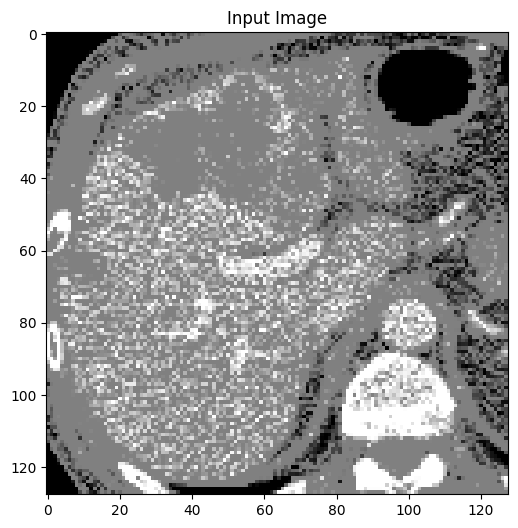

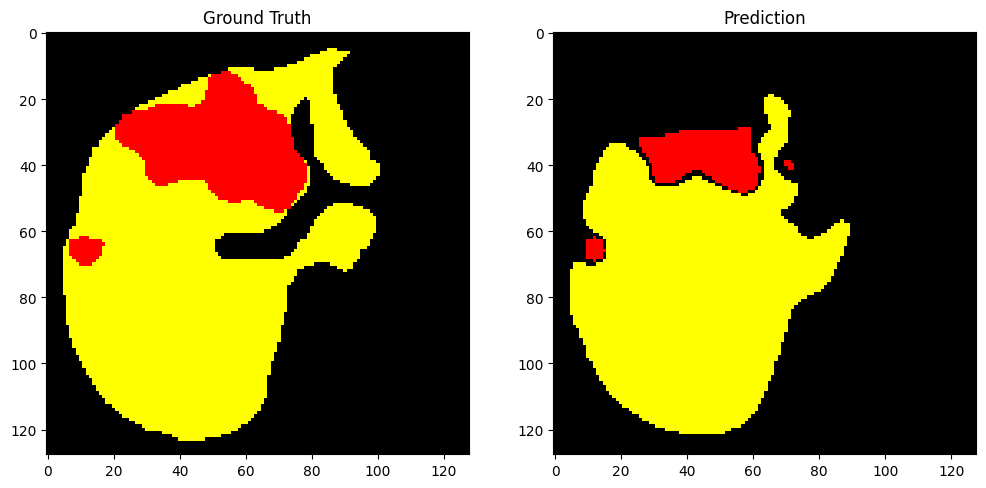

In [14]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth"
visualize_results(model, val_loader, weight_path, num_images, device)